# Why I Made This Project
* Our main project is about detecting content violations in set-top box systems, where the screen will be blocked if violent content is detected. Since that involves video processing, I wanted to first experiment with image processing using MobileViT before moving to video analysis.

* In this project, if a randomly selected image is of a cat, the screen will display a black box. If it’s a dog, the image will be shown normally.

# Setup Details
* This notebook is created on Google Colab and is configured to run on a CPU-only environment (with no GPU support) to simulate low-resource conditions.

* This setup is useful for testing the model’s performance (inference time, memory consumption) under limited computational resources, which is essential for eventual deployment on devices with constrained hardware (e.g., set-top boxes or IoT devices).

* **System Requirements:** A CPU-enabled environment is used in this notebook. While a GPU-enabled setup generally speeds up training and inference, running on CPU allows us to evaluate the model's performance in lower-resource conditions.

# Step 1
# Importing Libraries
We first import the necessary libraries.

In [ ]:
import os # For interacting with the operating system (e.g., file paths)
from glob import glob # For finding file patterns in directories
import torch # Core PyTorch library for tensor computation
from torch.utils.data import Dataset, DataLoader  # For creating and loading custom datasets
import torchvision.transforms as transforms # For image preprocessing and augmentation
from PIL import Image # For image loading and manipulation
import numpy as np  # For numerical operations and array handling
from transformers import AutoImageProcessor, AutoConfig, MobileViTForImageClassification # For using pretrained MobileViT models from HuggingFace
import random  # For generating random numbers (e.g., random seeds, shuffling)
import matplotlib.pyplot as plt # For plotting and visualizing data
import time                # To measure elapsed time during inference operations
import psutil              # To monitor system memory usage during model inference
from tqdm import tqdm      # To display a progress bar during iterative processes
import pandas as pd        # To handle data manipulation and export metrics as CSV





# Step 2
# Collecting Data from Kaggle Through Kaggle API

In [ ]:
# installing a Kaggle Library
!pip install kaggle

In [ ]:
# upload kaggle.json file
# configuring the path of kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog


Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 87% 190M/218M [00:00<00:00, 372MB/s]
100% 218M/218M [00:00<00:00, 352MB/s]


In [ ]:
import zipfile
dataset = '/content/cat-and-dog.zip'
with zipfile.ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset is extracted.")

The dataset is extracted.


# Step 3
#  Define the Labeling Function
Now we define a helper function named **assign_label** that extracts the parent folder name from each file path and assigns a label (for example, **0 for "cats" and 1 for "dogs**").

In [ ]:
def assign_label(path):
    # Extract the folder name which is the parent folder of the file
    folder_name = os.path.basename(os.path.dirname(path)).lower()
    if folder_name in ["cats", "cat"]:
        return 0
    elif folder_name in ["dogs", "dog"]:
        return 1
    else:
        raise ValueError(f"Unexpected folder name: {folder_name} in path: {path}")

# Quick test to ensure the function works:
sample_path = "/content/test_set/test_set/cats/cat.4001.jpg"
print("Sample label:", assign_label(sample_path))

Sample label: 0


# Step 4
# Create a Custom Dataset Class
This dataset loads an image, applies basic transforms (resizing, converting to tensor), then converts the image back to a NumPy array (in [0, 255] uint8 format) so that it can be processed by the Hugging Face processor. Finally, it returns the processed tensor and its label.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        # Resize images and convert the PIL images to tensors (values between 0 and 1)
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image from the file path.
        image = Image.open(self.image_paths[idx]).convert("RGB")
        # Apply basic transforms
        image_tensor = self.transform(image)  # shape: (3, 256, 256)

        # Convert the tensor back to a NumPy image in the range [0, 255]
        # (transpose dimensions from C x H x W to H x W x C)
        np_image = (image_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
        pil_image = Image.fromarray(np_image).convert("RGB")

        # Process the image with the Hugging Face processor. We use return_tensors="pt"
        processed = processor(images=pil_image, return_tensors="pt")
        # The processor returns a batch dimension (1, C, H, W), so we take the first element.
        input_tensor = processed['pixel_values'][0]

        # Return the processed tensor and its corresponding label.
        label = torch.tensor(self.labels[idx], dtype=torch.int64)
        return input_tensor, label


# Step 5
# Load the Pre-Trained Model and Reconfigure the Classification Head
We load the pre-trained MobileViT model from Hugging Face. We create a configuration that sets num_labels=2, and we use the flag ignore_mismatched_sizes=True to skip loading the classifier head (since it was originally set for a larger number of classes).

In [ ]:
# Load the processor and model.
processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

# Create a configuration with 2 output labels. Since Here we are working with two classes ('cats' and 'dogs')
config = AutoConfig.from_pretrained("apple/mobilevit-small", num_labels=2)

# Loading the MobileViT model for image classification with the new configuration.
model = MobileViTForImageClassification.from_pretrained(
    "apple/mobilevit-small",
    config=config,
    ignore_mismatched_sizes=True  # This overwrites the classifier head weights.
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([2, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Step 6
# Prepare File Paths, Assign Labels, and Create DataLoaders
Now we are going to use glob to collect all file paths from the training and test directories. Then we  will be assigning labels using our helper function and create dataset objects and DataLoaders.

In [ ]:
# Get file paths for training images. Adjust the base directory as needed (Here I am using the path of my own directory).
train_image_paths = glob("/content/training_set/training_set/*/*.jpg")
train_labels = [assign_label(path) for path in train_image_paths]

# Get file paths for testing images.
test_image_paths = glob("/content/test_set/test_set/*/*.jpg")
test_labels = [assign_label(path) for path in test_image_paths]

print(f"Found {len(train_image_paths)} training images.")
print(f"Found {len(test_image_paths)} testing images.")

# Create dataset instances.
train_dataset = CustomDataset(train_image_paths, train_labels)
test_dataset = CustomDataset(test_image_paths, test_labels)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Check one batch to confirm the size.
for x_batch, y_batch in train_loader:
    print("Processed batch shapes:", x_batch.shape, y_batch.shape)
    break


Found 8005 training images.
Found 2023 testing images.
Processed batch shapes: torch.Size([8, 3, 256, 256]) torch.Size([8])


# Step 7
# Train the Model
Set up the training loop. We move the model to the GPU if available, define the optimizer and loss function, and run a training loop (here, we are running the loop for 5 times).

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Sets device to GPU if available, else CPU
# model.to(device)  # Moves the model to the selected device

device = torch.device("cpu")  # the model will be running on cpu
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)  # Adam optimizer for adaptive learning rate
loss_fn = torch.nn.CrossEntropyLoss()  # Cross-entropy loss for binary classification

# Training loop (2 epochs)
model.train()  # Sets the model in training mode
for epoch in range(2):
    total_loss = 0  # Track total training loss
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Moves batches to device

        optimizer.zero_grad()  # Clears old gradients
        outputs = model(x_batch).logits  # Get logits
        loss = loss_fn(outputs, y_batch)  # Compute loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights

        total_loss += loss.item()  # Accumulate loss
        print(f"Batch Loss: {loss.item():.6f}")

    # End of epoch - Calculate Validation Loss
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient computation
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_outputs = model(x_val).logits
            val_loss = loss_fn(val_outputs, y_val)
            total_val_loss += val_loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(test_loader)

    print(f"\nEpoch {epoch+1} - Training Loss: {avg_train_loss:.6f} | Validation Loss: {avg_val_loss:.6f}\n")

# A gradient is the derivative of the loss with respect to the model’s parameters — it tells how much and in which direction each parameter should change to reduce the loss.

Batch Loss: 0.679433
Batch Loss: 0.691027
Batch Loss: 0.693112
Batch Loss: 0.700923
Batch Loss: 0.703800
Batch Loss: 0.710683
Batch Loss: 0.687861
Batch Loss: 0.723096
Batch Loss: 0.711903
Batch Loss: 0.701306
Batch Loss: 0.705662
Batch Loss: 0.656338
Batch Loss: 0.668053
Batch Loss: 0.665859
Batch Loss: 0.685030
Batch Loss: 0.709683
Batch Loss: 0.690529
Batch Loss: 0.677244
Batch Loss: 0.714655
Batch Loss: 0.666847
Batch Loss: 0.679494
Batch Loss: 0.657009
Batch Loss: 0.684351
Batch Loss: 0.665088
Batch Loss: 0.657731
Batch Loss: 0.653642
Batch Loss: 0.656031
Batch Loss: 0.684666
Batch Loss: 0.687213
Batch Loss: 0.644311
Batch Loss: 0.639790
Batch Loss: 0.653231
Batch Loss: 0.608628
Batch Loss: 0.646146
Batch Loss: 0.696508
Batch Loss: 0.641659
Batch Loss: 0.629180
Batch Loss: 0.642019
Batch Loss: 0.674155
Batch Loss: 0.656816
Batch Loss: 0.627434
Batch Loss: 0.677612
Batch Loss: 0.676652
Batch Loss: 0.687342
Batch Loss: 0.657557
Batch Loss: 0.607618
Batch Loss: 0.607967
Batch Loss: 0

# Step 8
# Model Evaluation
After training, compute predictions on the test set and evaluate the results. Here we also compute the confusion matrix and classification report.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(x_batch).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y_batch.cpu().tolist())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Since there are 2 classes, print classification report only if both exist.
unique_classes = sorted(set(all_labels))
print("Unique classes in test set:", unique_classes)

if len(unique_classes) == 1:
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, labels=unique_classes, target_names=[f"Class {unique_classes[0]}"]))
else:
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"]))


Confusion Matrix:
[[1007    4]
 [  11 1001]]
Unique classes in test set: [0, 1]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99      1011
     Class 1       1.00      0.99      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023



# Step 9  
# Define a Prediction Function
This function takes an input image tensor, applies necessary preprocessing, and passes it through a trained model to generate predictions. It also measures the computational cost of each inference, specifically:

- **Inference Time (milliseconds):** The time taken to classify each image.

- **Peak Memory Usage (KB):** The maximum memory allocated during the model's prediction step, measured using `tracemalloc`.

Each image's metrics are directly appended to a Pandas DataFrame instead of being collected in separate lists. After all test images are processed, the complete DataFrame is exported as a CSV file, containing:

- Image Index  
- Inference Time (ms) per Image  
- Memory Used (KB) per Image


In [ ]:
import tracemalloc
# Initialize an empty DataFrame globally to store results
df_metrics = pd.DataFrame(columns=["Image_Index", "Inference_Time_ms", "Memory_Used_KB"])
def predict_with_metrics(model, image, image_idx, device):
    global df_metrics
    model.eval()
    image = image.unsqueeze(0).to(device)

    # Start memory tracking
    tracemalloc.start()
    start_time = time.time()

    logits = model(image).logits  # Run inference

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    inference_time_ms = (end_time - start_time) * 1000  # ms
    memory_used_kb = peak / 1024  # Convert bytes to KB

    print(f"[Image {image_idx}] Time: {inference_time_ms:.2f} ms, Peak Memory: {memory_used_kb:.2f} KB")

    df_metrics = pd.concat([df_metrics, pd.DataFrame([{
        "Image_Index": image_idx,
        "Inference_Time_ms": inference_time_ms,
        "Memory_Used_KB": memory_used_kb
    }])], ignore_index=True)

    return logits


# Step 10
# Running the Function in a Loop for All Images In The Test Dataset

In [ ]:
# Set device and model
device = torch.device("cpu")
model.to(device)

# Loop through all images in the test dataset
for idx in tqdm(range(len(test_dataset)), desc="Processing Images"):
    image = test_dataset[idx][0]  # Extract the image from the dataset
    with torch.no_grad():
        _ = predict_with_metrics(model, image, idx, device)  # Run prediction and store metrics

# Save the DataFrame at the end
df_metrics.to_csv("test_inference_metrics.csv", index=False)
print("Metrics saved to test_inference_metrics.csv")


Processing Images:   0%|          | 0/2023 [00:00<?, ?it/s]<ipython-input-31-c491523c8b38>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([{
Processing Images:   0%|          | 2/2023 [00:00<06:15,  5.39it/s]

[Image 0] Time: 173.53 ms, Peak Memory: 11.20 KB
[Image 1] Time: 169.57 ms, Peak Memory: 13.48 KB


Processing Images:   0%|          | 4/2023 [00:00<06:14,  5.40it/s]

[Image 2] Time: 171.17 ms, Peak Memory: 10.77 KB
[Image 3] Time: 170.68 ms, Peak Memory: 10.63 KB


Processing Images:   0%|          | 6/2023 [00:01<06:26,  5.22it/s]

[Image 4] Time: 193.96 ms, Peak Memory: 10.59 KB
[Image 5] Time: 171.72 ms, Peak Memory: 93.23 KB


Processing Images:   0%|          | 8/2023 [00:01<06:15,  5.36it/s]

[Image 6] Time: 162.18 ms, Peak Memory: 15.21 KB
[Image 7] Time: 172.26 ms, Peak Memory: 9.43 KB


Processing Images:   0%|          | 10/2023 [00:01<06:16,  5.35it/s]

[Image 8] Time: 168.35 ms, Peak Memory: 11.23 KB
[Image 9] Time: 179.21 ms, Peak Memory: 6.19 KB


Processing Images:   1%|          | 12/2023 [00:02<06:11,  5.41it/s]

[Image 10] Time: 174.88 ms, Peak Memory: 67.28 KB
[Image 11] Time: 164.96 ms, Peak Memory: 7.01 KB


Processing Images:   1%|          | 14/2023 [00:02<06:08,  5.45it/s]

[Image 12] Time: 166.01 ms, Peak Memory: 10.54 KB
[Image 13] Time: 168.49 ms, Peak Memory: 90.13 KB


Processing Images:   1%|          | 16/2023 [00:02<06:08,  5.45it/s]

[Image 14] Time: 163.85 ms, Peak Memory: 10.48 KB
[Image 15] Time: 172.82 ms, Peak Memory: 10.17 KB


Processing Images:   1%|          | 18/2023 [00:03<06:01,  5.55it/s]

[Image 16] Time: 167.17 ms, Peak Memory: 89.92 KB
[Image 17] Time: 157.34 ms, Peak Memory: 12.86 KB


Processing Images:   1%|          | 20/2023 [00:03<05:57,  5.60it/s]

[Image 18] Time: 161.63 ms, Peak Memory: 11.64 KB
[Image 19] Time: 165.22 ms, Peak Memory: 6.52 KB


Processing Images:   1%|          | 22/2023 [00:04<06:05,  5.47it/s]

[Image 20] Time: 167.98 ms, Peak Memory: 86.92 KB
[Image 21] Time: 175.49 ms, Peak Memory: 9.84 KB


Processing Images:   1%|          | 24/2023 [00:04<06:01,  5.53it/s]

[Image 22] Time: 164.59 ms, Peak Memory: 13.84 KB
[Image 23] Time: 162.18 ms, Peak Memory: 10.53 KB


Processing Images:   1%|▏         | 26/2023 [00:04<06:09,  5.41it/s]

[Image 24] Time: 177.57 ms, Peak Memory: 10.54 KB
[Image 25] Time: 173.58 ms, Peak Memory: 10.00 KB


Processing Images:   1%|▏         | 28/2023 [00:05<06:07,  5.43it/s]

[Image 26] Time: 182.76 ms, Peak Memory: 81.12 KB
[Image 27] Time: 157.15 ms, Peak Memory: 9.38 KB


Processing Images:   1%|▏         | 30/2023 [00:05<06:01,  5.52it/s]

[Image 28] Time: 164.08 ms, Peak Memory: 14.25 KB
[Image 29] Time: 162.42 ms, Peak Memory: 9.43 KB


Processing Images:   2%|▏         | 32/2023 [00:05<05:59,  5.54it/s]

[Image 30] Time: 167.67 ms, Peak Memory: 10.60 KB
[Image 31] Time: 164.17 ms, Peak Memory: 86.49 KB


Processing Images:   2%|▏         | 34/2023 [00:06<05:54,  5.62it/s]

[Image 32] Time: 169.17 ms, Peak Memory: 7.37 KB
[Image 33] Time: 156.93 ms, Peak Memory: 14.34 KB


Processing Images:   2%|▏         | 36/2023 [00:06<05:52,  5.64it/s]

[Image 34] Time: 163.14 ms, Peak Memory: 10.65 KB
[Image 35] Time: 161.33 ms, Peak Memory: 10.64 KB


Processing Images:   2%|▏         | 38/2023 [00:06<05:55,  5.59it/s]

[Image 36] Time: 172.31 ms, Peak Memory: 95.12 KB
[Image 37] Time: 161.54 ms, Peak Memory: 9.38 KB


Processing Images:   2%|▏         | 40/2023 [00:07<05:57,  5.55it/s]

[Image 38] Time: 178.69 ms, Peak Memory: 11.06 KB
[Image 39] Time: 159.96 ms, Peak Memory: 12.62 KB


Processing Images:   2%|▏         | 42/2023 [00:07<05:54,  5.59it/s]

[Image 40] Time: 165.09 ms, Peak Memory: 11.81 KB
[Image 41] Time: 162.49 ms, Peak Memory: 8.70 KB


Processing Images:   2%|▏         | 44/2023 [00:08<05:57,  5.54it/s]

[Image 42] Time: 161.59 ms, Peak Memory: 10.64 KB
[Image 43] Time: 170.72 ms, Peak Memory: 96.72 KB


Processing Images:   2%|▏         | 45/2023 [00:08<06:43,  4.90it/s]

[Image 44] Time: 244.47 ms, Peak Memory: 15.61 KB


Processing Images:   2%|▏         | 46/2023 [00:08<07:18,  4.51it/s]

[Image 45] Time: 242.43 ms, Peak Memory: 11.21 KB


Processing Images:   2%|▏         | 47/2023 [00:08<07:42,  4.27it/s]

[Image 46] Time: 239.38 ms, Peak Memory: 11.21 KB


Processing Images:   2%|▏         | 48/2023 [00:09<08:05,  4.07it/s]

[Image 47] Time: 249.40 ms, Peak Memory: 84.97 KB


Processing Images:   2%|▏         | 49/2023 [00:09<08:20,  3.94it/s]

[Image 48] Time: 249.51 ms, Peak Memory: 13.53 KB


Processing Images:   2%|▏         | 50/2023 [00:09<08:25,  3.90it/s]

[Image 49] Time: 240.17 ms, Peak Memory: 13.15 KB


Processing Images:   3%|▎         | 51/2023 [00:09<08:34,  3.83it/s]

[Image 50] Time: 250.10 ms, Peak Memory: 80.05 KB


Processing Images:   3%|▎         | 52/2023 [00:10<08:40,  3.79it/s]

[Image 51] Time: 253.19 ms, Peak Memory: 11.29 KB


Processing Images:   3%|▎         | 53/2023 [00:10<08:59,  3.65it/s]

[Image 52] Time: 275.81 ms, Peak Memory: 14.89 KB


Processing Images:   3%|▎         | 55/2023 [00:10<08:18,  3.95it/s]

[Image 53] Time: 263.13 ms, Peak Memory: 11.84 KB
[Image 54] Time: 171.59 ms, Peak Memory: 9.46 KB


Processing Images:   3%|▎         | 57/2023 [00:11<07:15,  4.51it/s]

[Image 55] Time: 170.41 ms, Peak Memory: 84.82 KB
[Image 56] Time: 180.17 ms, Peak Memory: 12.96 KB


Processing Images:   3%|▎         | 59/2023 [00:11<06:34,  4.98it/s]

[Image 57] Time: 171.69 ms, Peak Memory: 9.26 KB
[Image 58] Time: 161.44 ms, Peak Memory: 7.21 KB


Processing Images:   3%|▎         | 61/2023 [00:12<06:21,  5.15it/s]

[Image 59] Time: 163.18 ms, Peak Memory: 7.61 KB
[Image 60] Time: 178.26 ms, Peak Memory: 67.93 KB


Processing Images:   3%|▎         | 63/2023 [00:12<06:20,  5.15it/s]

[Image 61] Time: 170.15 ms, Peak Memory: 13.93 KB
[Image 62] Time: 185.62 ms, Peak Memory: 9.58 KB


Processing Images:   3%|▎         | 65/2023 [00:12<06:11,  5.27it/s]

[Image 63] Time: 166.14 ms, Peak Memory: 10.27 KB
[Image 64] Time: 172.67 ms, Peak Memory: 84.60 KB


Processing Images:   3%|▎         | 67/2023 [00:13<05:59,  5.45it/s]

[Image 65] Time: 165.21 ms, Peak Memory: 9.26 KB
[Image 66] Time: 160.58 ms, Peak Memory: 9.84 KB


Processing Images:   3%|▎         | 69/2023 [00:13<06:01,  5.40it/s]

[Image 67] Time: 161.41 ms, Peak Memory: 13.62 KB
[Image 68] Time: 179.83 ms, Peak Memory: 10.44 KB


Processing Images:   4%|▎         | 71/2023 [00:13<05:51,  5.55it/s]

[Image 69] Time: 165.28 ms, Peak Memory: 10.29 KB
[Image 70] Time: 157.51 ms, Peak Memory: 6.25 KB


Processing Images:   4%|▎         | 73/2023 [00:14<05:55,  5.49it/s]

[Image 71] Time: 173.24 ms, Peak Memory: 91.18 KB
[Image 72] Time: 165.22 ms, Peak Memory: 13.45 KB


Processing Images:   4%|▎         | 75/2023 [00:14<05:58,  5.43it/s]

[Image 73] Time: 177.87 ms, Peak Memory: 11.70 KB
[Image 74] Time: 167.71 ms, Peak Memory: 11.51 KB


Processing Images:   4%|▍         | 76/2023 [00:14<05:56,  5.46it/s]

[Image 75] Time: 166.90 ms, Peak Memory: 10.59 KB
[Image 76] Time: 184.44 ms, Peak Memory: 89.14 KB


Processing Images:   4%|▍         | 79/2023 [00:15<06:00,  5.40it/s]

[Image 77] Time: 172.59 ms, Peak Memory: 9.46 KB
[Image 78] Time: 162.24 ms, Peak Memory: 9.26 KB


Processing Images:   4%|▍         | 80/2023 [00:15<06:04,  5.33it/s]

[Image 79] Time: 180.10 ms, Peak Memory: 11.83 KB


Processing Images:   4%|▍         | 82/2023 [00:15<06:12,  5.21it/s]

[Image 80] Time: 203.85 ms, Peak Memory: 10.82 KB
[Image 81] Time: 165.54 ms, Peak Memory: 85.51 KB


Processing Images:   4%|▍         | 84/2023 [00:16<05:51,  5.52it/s]

[Image 82] Time: 159.63 ms, Peak Memory: 11.62 KB
[Image 83] Time: 156.73 ms, Peak Memory: 12.58 KB


Processing Images:   4%|▍         | 86/2023 [00:16<05:57,  5.41it/s]

[Image 84] Time: 179.15 ms, Peak Memory: 12.03 KB
[Image 85] Time: 169.27 ms, Peak Memory: 6.22 KB


Processing Images:   4%|▍         | 88/2023 [00:17<05:53,  5.48it/s]

[Image 86] Time: 175.43 ms, Peak Memory: 86.27 KB
[Image 87] Time: 159.64 ms, Peak Memory: 9.84 KB


Processing Images:   4%|▍         | 90/2023 [00:17<05:50,  5.51it/s]

[Image 88] Time: 164.02 ms, Peak Memory: 14.75 KB
[Image 89] Time: 167.78 ms, Peak Memory: 10.96 KB


Processing Images:   5%|▍         | 92/2023 [00:17<05:48,  5.55it/s]

[Image 90] Time: 175.06 ms, Peak Memory: 10.86 KB
[Image 91] Time: 159.60 ms, Peak Memory: 10.19 KB


Processing Images:   5%|▍         | 94/2023 [00:18<05:53,  5.45it/s]

[Image 92] Time: 175.12 ms, Peak Memory: 101.51 KB
[Image 93] Time: 168.77 ms, Peak Memory: 9.46 KB


Processing Images:   5%|▍         | 96/2023 [00:18<05:50,  5.49it/s]

[Image 94] Time: 162.23 ms, Peak Memory: 14.07 KB
[Image 95] Time: 168.79 ms, Peak Memory: 9.69 KB


Processing Images:   5%|▍         | 98/2023 [00:18<05:59,  5.36it/s]

[Image 96] Time: 183.21 ms, Peak Memory: 11.41 KB
[Image 97] Time: 171.40 ms, Peak Memory: 78.18 KB


Processing Images:   5%|▍         | 100/2023 [00:19<05:55,  5.42it/s]

[Image 98] Time: 166.92 ms, Peak Memory: 6.30 KB
[Image 99] Time: 168.77 ms, Peak Memory: 13.80 KB


Processing Images:   5%|▌         | 102/2023 [00:19<06:01,  5.31it/s]

[Image 100] Time: 167.45 ms, Peak Memory: 10.80 KB
[Image 101] Time: 183.42 ms, Peak Memory: 9.43 KB


Processing Images:   5%|▌         | 104/2023 [00:20<06:05,  5.25it/s]

[Image 102] Time: 178.06 ms, Peak Memory: 92.99 KB
[Image 103] Time: 174.62 ms, Peak Memory: 9.40 KB


Processing Images:   5%|▌         | 106/2023 [00:20<05:50,  5.46it/s]

[Image 104] Time: 161.30 ms, Peak Memory: 12.54 KB
[Image 105] Time: 160.84 ms, Peak Memory: 10.75 KB


Processing Images:   5%|▌         | 108/2023 [00:20<05:56,  5.36it/s]

[Image 106] Time: 165.34 ms, Peak Memory: 10.80 KB
[Image 107] Time: 182.32 ms, Peak Memory: 10.46 KB


Processing Images:   5%|▌         | 109/2023 [00:21<06:45,  4.72it/s]

[Image 108] Time: 254.94 ms, Peak Memory: 89.05 KB


Processing Images:   5%|▌         | 110/2023 [00:21<07:15,  4.39it/s]

[Image 109] Time: 241.83 ms, Peak Memory: 15.05 KB


Processing Images:   5%|▌         | 111/2023 [00:21<07:35,  4.19it/s]

[Image 110] Time: 239.44 ms, Peak Memory: 10.77 KB


Processing Images:   6%|▌         | 112/2023 [00:21<08:07,  3.92it/s]

[Image 111] Time: 270.31 ms, Peak Memory: 11.27 KB


Processing Images:   6%|▌         | 113/2023 [00:22<08:18,  3.83it/s]

[Image 112] Time: 253.98 ms, Peak Memory: 84.95 KB


Processing Images:   6%|▌         | 114/2023 [00:22<08:18,  3.83it/s]

[Image 113] Time: 241.85 ms, Peak Memory: 14.91 KB


Processing Images:   6%|▌         | 115/2023 [00:22<08:24,  3.78it/s]

[Image 114] Time: 250.49 ms, Peak Memory: 11.52 KB


Processing Images:   6%|▌         | 116/2023 [00:22<08:51,  3.59it/s]

[Image 115] Time: 289.56 ms, Peak Memory: 99.71 KB


Processing Images:   6%|▌         | 117/2023 [00:23<09:05,  3.49it/s]

[Image 116] Time: 277.36 ms, Peak Memory: 14.18 KB


Processing Images:   6%|▌         | 119/2023 [00:23<08:05,  3.93it/s]

[Image 117] Time: 236.19 ms, Peak Memory: 11.76 KB
[Image 118] Time: 181.37 ms, Peak Memory: 94.75 KB


Processing Images:   6%|▌         | 121/2023 [00:24<07:07,  4.45it/s]

[Image 119] Time: 194.59 ms, Peak Memory: 9.64 KB
[Image 120] Time: 168.29 ms, Peak Memory: 9.52 KB


Processing Images:   6%|▌         | 123/2023 [00:24<06:22,  4.97it/s]

[Image 121] Time: 163.04 ms, Peak Memory: 10.85 KB
[Image 122] Time: 165.62 ms, Peak Memory: 6.99 KB


Processing Images:   6%|▌         | 125/2023 [00:24<06:11,  5.11it/s]

[Image 123] Time: 167.70 ms, Peak Memory: 12.70 KB
[Image 124] Time: 175.64 ms, Peak Memory: 9.64 KB


Processing Images:   6%|▋         | 127/2023 [00:25<06:05,  5.19it/s]

[Image 125] Time: 189.81 ms, Peak Memory: 88.70 KB
[Image 126] Time: 158.73 ms, Peak Memory: 12.84 KB


Processing Images:   6%|▋         | 129/2023 [00:25<05:57,  5.29it/s]

[Image 127] Time: 165.46 ms, Peak Memory: 10.86 KB
[Image 128] Time: 172.83 ms, Peak Memory: 11.15 KB


Processing Images:   6%|▋         | 131/2023 [00:25<05:56,  5.31it/s]

[Image 129] Time: 164.88 ms, Peak Memory: 9.60 KB
[Image 130] Time: 181.48 ms, Peak Memory: 85.70 KB


Processing Images:   7%|▋         | 133/2023 [00:26<05:45,  5.47it/s]

[Image 131] Time: 161.97 ms, Peak Memory: 9.46 KB
[Image 132] Time: 163.34 ms, Peak Memory: 12.51 KB


Processing Images:   7%|▋         | 135/2023 [00:26<05:38,  5.57it/s]

[Image 133] Time: 165.78 ms, Peak Memory: 11.60 KB
[Image 134] Time: 161.08 ms, Peak Memory: 6.45 KB


Processing Images:   7%|▋         | 136/2023 [00:26<05:45,  5.47it/s]

[Image 135] Time: 177.00 ms, Peak Memory: 90.28 KB


Processing Images:   7%|▋         | 138/2023 [00:27<05:51,  5.37it/s]

[Image 136] Time: 186.71 ms, Peak Memory: 10.95 KB
[Image 137] Time: 160.89 ms, Peak Memory: 13.84 KB


Processing Images:   7%|▋         | 140/2023 [00:27<05:43,  5.47it/s]

[Image 138] Time: 163.59 ms, Peak Memory: 11.54 KB
[Image 139] Time: 166.42 ms, Peak Memory: 9.43 KB


Processing Images:   7%|▋         | 142/2023 [00:28<05:55,  5.30it/s]

[Image 140] Time: 170.57 ms, Peak Memory: 11.14 KB
[Image 141] Time: 185.09 ms, Peak Memory: 89.08 KB


Processing Images:   7%|▋         | 144/2023 [00:28<05:40,  5.51it/s]

[Image 142] Time: 164.91 ms, Peak Memory: 9.46 KB
[Image 143] Time: 154.84 ms, Peak Memory: 10.37 KB


Processing Images:   7%|▋         | 146/2023 [00:28<05:37,  5.56it/s]

[Image 144] Time: 159.51 ms, Peak Memory: 10.49 KB
[Image 145] Time: 166.62 ms, Peak Memory: 9.98 KB


Processing Images:   7%|▋         | 148/2023 [00:29<05:47,  5.40it/s]

[Image 146] Time: 176.10 ms, Peak Memory: 87.43 KB
[Image 147] Time: 174.58 ms, Peak Memory: 6.27 KB


Processing Images:   7%|▋         | 150/2023 [00:29<05:43,  5.45it/s]

[Image 148] Time: 162.95 ms, Peak Memory: 10.53 KB
[Image 149] Time: 164.52 ms, Peak Memory: 9.58 KB


Processing Images:   8%|▊         | 152/2023 [00:29<05:43,  5.45it/s]

[Image 150] Time: 169.21 ms, Peak Memory: 10.86 KB
[Image 151] Time: 169.56 ms, Peak Memory: 95.68 KB


Processing Images:   8%|▊         | 154/2023 [00:30<05:46,  5.40it/s]

[Image 152] Time: 170.41 ms, Peak Memory: 10.66 KB
[Image 153] Time: 173.23 ms, Peak Memory: 14.62 KB


Processing Images:   8%|▊         | 156/2023 [00:30<05:40,  5.49it/s]

[Image 154] Time: 166.86 ms, Peak Memory: 12.53 KB
[Image 155] Time: 164.00 ms, Peak Memory: 9.69 KB


Processing Images:   8%|▊         | 158/2023 [00:30<05:43,  5.43it/s]

[Image 156] Time: 175.46 ms, Peak Memory: 11.45 KB
[Image 157] Time: 170.19 ms, Peak Memory: 9.26 KB


Processing Images:   8%|▊         | 160/2023 [00:31<05:45,  5.39it/s]

[Image 158] Time: 188.68 ms, Peak Memory: 87.17 KB
[Image 159] Time: 161.09 ms, Peak Memory: 10.85 KB


Processing Images:   8%|▊         | 162/2023 [00:31<05:47,  5.36it/s]

[Image 160] Time: 168.48 ms, Peak Memory: 7.67 KB
[Image 161] Time: 174.87 ms, Peak Memory: 10.18 KB


Processing Images:   8%|▊         | 164/2023 [00:32<05:42,  5.42it/s]

[Image 162] Time: 169.38 ms, Peak Memory: 9.20 KB
[Image 163] Time: 161.94 ms, Peak Memory: 9.46 KB


Processing Images:   8%|▊         | 166/2023 [00:32<05:39,  5.46it/s]

[Image 164] Time: 181.76 ms, Peak Memory: 15.27 KB
[Image 165] Time: 156.39 ms, Peak Memory: 9.20 KB


Processing Images:   8%|▊         | 168/2023 [00:32<05:36,  5.51it/s]

[Image 166] Time: 171.10 ms, Peak Memory: 11.54 KB
[Image 167] Time: 161.12 ms, Peak Memory: 9.43 KB


Processing Images:   8%|▊         | 170/2023 [00:33<05:30,  5.61it/s]

[Image 168] Time: 162.81 ms, Peak Memory: 11.79 KB
[Image 169] Time: 158.12 ms, Peak Memory: 9.69 KB


Processing Images:   8%|▊         | 171/2023 [00:33<05:36,  5.50it/s]

[Image 170] Time: 174.13 ms, Peak Memory: 13.06 KB


Processing Images:   9%|▊         | 172/2023 [00:33<05:52,  5.25it/s]

[Image 171] Time: 193.34 ms, Peak Memory: 11.55 KB


Processing Images:   9%|▊         | 173/2023 [00:33<06:34,  4.69it/s]

[Image 172] Time: 245.34 ms, Peak Memory: 12.70 KB


Processing Images:   9%|▊         | 174/2023 [00:34<07:10,  4.30it/s]

[Image 173] Time: 254.79 ms, Peak Memory: 81.09 KB


Processing Images:   9%|▊         | 175/2023 [00:34<07:34,  4.06it/s]

[Image 174] Time: 251.62 ms, Peak Memory: 14.95 KB


Processing Images:   9%|▊         | 176/2023 [00:34<07:48,  3.94it/s]

[Image 175] Time: 243.96 ms, Peak Memory: 11.36 KB


Processing Images:   9%|▊         | 177/2023 [00:34<07:51,  3.92it/s]

[Image 176] Time: 240.55 ms, Peak Memory: 12.13 KB


Processing Images:   9%|▉         | 178/2023 [00:35<08:02,  3.83it/s]

[Image 177] Time: 253.38 ms, Peak Memory: 10.95 KB


Processing Images:   9%|▉         | 179/2023 [00:35<08:07,  3.78it/s]

[Image 178] Time: 253.67 ms, Peak Memory: 14.57 KB


Processing Images:   9%|▉         | 180/2023 [00:35<08:07,  3.78it/s]

[Image 179] Time: 247.78 ms, Peak Memory: 12.58 KB


Processing Images:   9%|▉         | 181/2023 [00:36<08:20,  3.68it/s]

[Image 180] Time: 269.61 ms, Peak Memory: 89.89 KB


Processing Images:   9%|▉         | 183/2023 [00:36<07:22,  4.16it/s]

[Image 181] Time: 217.51 ms, Peak Memory: 15.47 KB
[Image 182] Time: 177.78 ms, Peak Memory: 9.26 KB


Processing Images:   9%|▉         | 185/2023 [00:36<06:29,  4.72it/s]

[Image 183] Time: 166.20 ms, Peak Memory: 9.46 KB
[Image 184] Time: 170.42 ms, Peak Memory: 82.41 KB


Processing Images:   9%|▉         | 187/2023 [00:37<06:07,  5.00it/s]

[Image 185] Time: 177.67 ms, Peak Memory: 10.54 KB
[Image 186] Time: 171.56 ms, Peak Memory: 9.66 KB


Processing Images:   9%|▉         | 189/2023 [00:37<05:53,  5.19it/s]

[Image 187] Time: 163.98 ms, Peak Memory: 15.11 KB
[Image 188] Time: 175.35 ms, Peak Memory: 9.18 KB


Processing Images:   9%|▉         | 191/2023 [00:37<05:42,  5.34it/s]

[Image 189] Time: 173.95 ms, Peak Memory: 8.27 KB
[Image 190] Time: 163.62 ms, Peak Memory: 6.25 KB


Processing Images:  10%|▉         | 193/2023 [00:38<05:37,  5.42it/s]

[Image 191] Time: 175.22 ms, Peak Memory: 88.87 KB
[Image 192] Time: 162.10 ms, Peak Memory: 13.77 KB


Processing Images:  10%|▉         | 195/2023 [00:38<05:40,  5.37it/s]

[Image 193] Time: 163.96 ms, Peak Memory: 10.60 KB
[Image 194] Time: 164.75 ms, Peak Memory: 10.10 KB


Processing Images:  10%|▉         | 197/2023 [00:39<05:35,  5.45it/s]

[Image 195] Time: 166.45 ms, Peak Memory: 9.26 KB
[Image 196] Time: 166.67 ms, Peak Memory: 86.13 KB


Processing Images:  10%|▉         | 199/2023 [00:39<05:29,  5.53it/s]

[Image 197] Time: 168.14 ms, Peak Memory: 10.95 KB
[Image 198] Time: 157.55 ms, Peak Memory: 9.38 KB


Processing Images:  10%|▉         | 201/2023 [00:39<05:30,  5.52it/s]

[Image 199] Time: 173.65 ms, Peak Memory: 11.90 KB
[Image 200] Time: 160.99 ms, Peak Memory: 6.07 KB


Processing Images:  10%|█         | 203/2023 [00:40<05:31,  5.50it/s]

[Image 201] Time: 172.62 ms, Peak Memory: 85.58 KB
[Image 202] Time: 162.80 ms, Peak Memory: 9.66 KB


Processing Images:  10%|█         | 205/2023 [00:40<05:26,  5.57it/s]

[Image 203] Time: 165.40 ms, Peak Memory: 15.17 KB
[Image 204] Time: 159.80 ms, Peak Memory: 11.42 KB


Processing Images:  10%|█         | 207/2023 [00:40<05:31,  5.47it/s]

[Image 205] Time: 178.55 ms, Peak Memory: 10.65 KB
[Image 206] Time: 164.70 ms, Peak Memory: 10.22 KB


Processing Images:  10%|█         | 209/2023 [00:41<05:31,  5.47it/s]

[Image 207] Time: 181.73 ms, Peak Memory: 88.86 KB
[Image 208] Time: 158.37 ms, Peak Memory: 9.32 KB


Processing Images:  10%|█         | 211/2023 [00:41<05:23,  5.60it/s]

[Image 209] Time: 164.63 ms, Peak Memory: 11.48 KB
[Image 210] Time: 155.57 ms, Peak Memory: 9.38 KB


Processing Images:  11%|█         | 213/2023 [00:41<05:35,  5.40it/s]

[Image 211] Time: 180.60 ms, Peak Memory: 8.17 KB
[Image 212] Time: 172.81 ms, Peak Memory: 78.00 KB


Processing Images:  11%|█         | 215/2023 [00:42<05:29,  5.48it/s]

[Image 213] Time: 166.57 ms, Peak Memory: 9.26 KB
[Image 214] Time: 162.47 ms, Peak Memory: 13.20 KB


Processing Images:  11%|█         | 217/2023 [00:42<05:33,  5.42it/s]

[Image 215] Time: 164.29 ms, Peak Memory: 10.60 KB
[Image 216] Time: 177.95 ms, Peak Memory: 10.06 KB


Processing Images:  11%|█         | 219/2023 [00:43<05:30,  5.46it/s]

[Image 217] Time: 169.70 ms, Peak Memory: 86.62 KB
[Image 218] Time: 163.30 ms, Peak Memory: 9.68 KB


Processing Images:  11%|█         | 221/2023 [00:43<05:22,  5.60it/s]

[Image 219] Time: 162.83 ms, Peak Memory: 15.00 KB
[Image 220] Time: 155.42 ms, Peak Memory: 9.43 KB


Processing Images:  11%|█         | 223/2023 [00:43<05:21,  5.60it/s]

[Image 221] Time: 161.42 ms, Peak Memory: 8.32 KB
[Image 222] Time: 167.68 ms, Peak Memory: 7.51 KB


Processing Images:  11%|█         | 225/2023 [00:44<05:27,  5.49it/s]

[Image 223] Time: 167.83 ms, Peak Memory: 10.64 KB
[Image 224] Time: 174.62 ms, Peak Memory: 88.20 KB


Processing Images:  11%|█         | 227/2023 [00:44<05:22,  5.58it/s]

[Image 225] Time: 160.44 ms, Peak Memory: 13.42 KB
[Image 226] Time: 161.24 ms, Peak Memory: 10.22 KB


Processing Images:  11%|█▏        | 229/2023 [00:44<05:27,  5.48it/s]

[Image 227] Time: 164.14 ms, Peak Memory: 12.85 KB
[Image 228] Time: 173.53 ms, Peak Memory: 9.43 KB


Processing Images:  11%|█▏        | 231/2023 [00:45<05:32,  5.38it/s]

[Image 229] Time: 181.33 ms, Peak Memory: 85.13 KB
[Image 230] Time: 167.54 ms, Peak Memory: 13.48 KB


Processing Images:  12%|█▏        | 233/2023 [00:45<05:31,  5.40it/s]

[Image 231] Time: 172.28 ms, Peak Memory: 10.60 KB
[Image 232] Time: 165.45 ms, Peak Memory: 10.22 KB


Processing Images:  12%|█▏        | 234/2023 [00:45<05:39,  5.27it/s]

[Image 233] Time: 184.53 ms, Peak Memory: 10.60 KB


Processing Images:  12%|█▏        | 236/2023 [00:46<05:37,  5.30it/s]

[Image 234] Time: 191.85 ms, Peak Memory: 85.03 KB
[Image 235] Time: 157.51 ms, Peak Memory: 7.98 KB


Processing Images:  12%|█▏        | 237/2023 [00:46<06:20,  4.69it/s]

[Image 236] Time: 255.38 ms, Peak Memory: 13.45 KB


Processing Images:  12%|█▏        | 238/2023 [00:46<06:52,  4.33it/s]

[Image 237] Time: 250.67 ms, Peak Memory: 10.59 KB


Processing Images:  12%|█▏        | 239/2023 [00:46<07:16,  4.09it/s]

[Image 238] Time: 253.80 ms, Peak Memory: 85.06 KB


Processing Images:  12%|█▏        | 240/2023 [00:47<07:26,  4.00it/s]

[Image 239] Time: 243.97 ms, Peak Memory: 15.33 KB


Processing Images:  12%|█▏        | 241/2023 [00:47<07:36,  3.90it/s]

[Image 240] Time: 248.71 ms, Peak Memory: 11.29 KB


Processing Images:  12%|█▏        | 242/2023 [00:47<07:38,  3.89it/s]

[Image 241] Time: 237.83 ms, Peak Memory: 12.88 KB


Processing Images:  12%|█▏        | 243/2023 [00:48<07:53,  3.76it/s]

[Image 242] Time: 267.35 ms, Peak Memory: 97.55 KB


Processing Images:  12%|█▏        | 244/2023 [00:48<07:55,  3.74it/s]

[Image 243] Time: 247.18 ms, Peak Memory: 14.09 KB


Processing Images:  12%|█▏        | 245/2023 [00:48<07:55,  3.74it/s]

[Image 244] Time: 245.25 ms, Peak Memory: 12.18 KB


Processing Images:  12%|█▏        | 246/2023 [00:48<08:05,  3.66it/s]

[Image 245] Time: 263.24 ms, Peak Memory: 82.75 KB


Processing Images:  12%|█▏        | 248/2023 [00:49<06:56,  4.26it/s]

[Image 246] Time: 198.20 ms, Peak Memory: 12.17 KB
[Image 247] Time: 164.00 ms, Peak Memory: 13.30 KB


Processing Images:  12%|█▏        | 250/2023 [00:49<06:10,  4.78it/s]

[Image 248] Time: 169.67 ms, Peak Memory: 12.40 KB
[Image 249] Time: 169.29 ms, Peak Memory: 9.38 KB


Processing Images:  12%|█▏        | 251/2023 [00:49<06:04,  4.87it/s]

[Image 250] Time: 179.34 ms, Peak Memory: 79.15 KB
[Image 251] Time: 185.86 ms, Peak Memory: 9.46 KB


Processing Images:  13%|█▎        | 254/2023 [00:50<05:45,  5.11it/s]

[Image 252] Time: 167.38 ms, Peak Memory: 13.40 KB
[Image 253] Time: 173.41 ms, Peak Memory: 10.84 KB


Processing Images:  13%|█▎        | 256/2023 [00:50<05:27,  5.39it/s]

[Image 254] Time: 166.22 ms, Peak Memory: 9.29 KB
[Image 255] Time: 157.40 ms, Peak Memory: 10.61 KB


Processing Images:  13%|█▎        | 258/2023 [00:51<05:28,  5.37it/s]

[Image 256] Time: 165.22 ms, Peak Memory: 7.61 KB
[Image 257] Time: 175.27 ms, Peak Memory: 6.63 KB


Processing Images:  13%|█▎        | 260/2023 [00:51<05:22,  5.47it/s]

[Image 258] Time: 164.51 ms, Peak Memory: 11.25 KB
[Image 259] Time: 160.61 ms, Peak Memory: 9.43 KB


Processing Images:  13%|█▎        | 262/2023 [00:51<05:16,  5.56it/s]

[Image 260] Time: 165.64 ms, Peak Memory: 11.61 KB
[Image 261] Time: 160.21 ms, Peak Memory: 9.64 KB


Processing Images:  13%|█▎        | 264/2023 [00:52<05:25,  5.40it/s]

[Image 262] Time: 172.01 ms, Peak Memory: 11.04 KB
[Image 263] Time: 170.01 ms, Peak Memory: 12.96 KB


Processing Images:  13%|█▎        | 266/2023 [00:52<05:21,  5.47it/s]

[Image 264] Time: 162.39 ms, Peak Memory: 9.26 KB
[Image 265] Time: 166.95 ms, Peak Memory: 10.44 KB


Processing Images:  13%|█▎        | 268/2023 [00:52<05:27,  5.36it/s]

[Image 266] Time: 176.80 ms, Peak Memory: 88.58 KB
[Image 267] Time: 173.23 ms, Peak Memory: 9.45 KB


Processing Images:  13%|█▎        | 270/2023 [00:53<05:33,  5.26it/s]

[Image 268] Time: 188.61 ms, Peak Memory: 9.75 KB
[Image 269] Time: 170.55 ms, Peak Memory: 9.46 KB


Processing Images:  13%|█▎        | 272/2023 [00:53<05:24,  5.39it/s]

[Image 270] Time: 172.04 ms, Peak Memory: 6.10 KB
[Image 271] Time: 160.77 ms, Peak Memory: 8.55 KB


Processing Images:  14%|█▎        | 274/2023 [00:54<05:21,  5.45it/s]

[Image 272] Time: 163.60 ms, Peak Memory: 10.59 KB
[Image 273] Time: 166.90 ms, Peak Memory: 89.61 KB


Processing Images:  14%|█▎        | 276/2023 [00:54<05:23,  5.40it/s]

[Image 274] Time: 178.45 ms, Peak Memory: 14.40 KB
[Image 275] Time: 164.64 ms, Peak Memory: 9.26 KB


Processing Images:  14%|█▎        | 278/2023 [00:54<05:20,  5.44it/s]

[Image 276] Time: 171.65 ms, Peak Memory: 12.99 KB
[Image 277] Time: 164.64 ms, Peak Memory: 9.58 KB


Processing Images:  14%|█▍        | 279/2023 [00:55<05:37,  5.16it/s]

[Image 278] Time: 198.95 ms, Peak Memory: 86.91 KB


Processing Images:  14%|█▍        | 281/2023 [00:55<05:40,  5.11it/s]

[Image 279] Time: 194.28 ms, Peak Memory: 15.01 KB
[Image 280] Time: 173.36 ms, Peak Memory: 9.46 KB


Processing Images:  14%|█▍        | 283/2023 [00:55<05:35,  5.19it/s]

[Image 281] Time: 177.36 ms, Peak Memory: 11.59 KB
[Image 282] Time: 171.33 ms, Peak Memory: 97.03 KB


Processing Images:  14%|█▍        | 285/2023 [00:56<05:21,  5.41it/s]

[Image 283] Time: 166.47 ms, Peak Memory: 9.20 KB
[Image 284] Time: 156.86 ms, Peak Memory: 12.78 KB


Processing Images:  14%|█▍        | 287/2023 [00:56<05:34,  5.20it/s]

[Image 285] Time: 193.00 ms, Peak Memory: 11.26 KB
[Image 286] Time: 173.89 ms, Peak Memory: 9.14 KB


Processing Images:  14%|█▍        | 289/2023 [00:57<05:34,  5.18it/s]

[Image 287] Time: 182.93 ms, Peak Memory: 98.24 KB
[Image 288] Time: 174.10 ms, Peak Memory: 9.40 KB


Processing Images:  14%|█▍        | 291/2023 [00:57<05:36,  5.14it/s]

[Image 289] Time: 174.25 ms, Peak Memory: 9.46 KB
[Image 290] Time: 182.70 ms, Peak Memory: 10.33 KB


Processing Images:  14%|█▍        | 293/2023 [00:57<05:45,  5.01it/s]

[Image 291] Time: 191.36 ms, Peak Memory: 9.64 KB
[Image 292] Time: 180.70 ms, Peak Memory: 10.07 KB


Processing Images:  15%|█▍        | 295/2023 [00:58<05:38,  5.11it/s]

[Image 293] Time: 180.52 ms, Peak Memory: 90.83 KB
[Image 294] Time: 173.27 ms, Peak Memory: 7.61 KB


Processing Images:  15%|█▍        | 297/2023 [00:58<05:33,  5.17it/s]

[Image 295] Time: 180.72 ms, Peak Memory: 8.06 KB
[Image 296] Time: 168.71 ms, Peak Memory: 8.05 KB


Processing Images:  15%|█▍        | 299/2023 [00:58<05:25,  5.30it/s]

[Image 297] Time: 164.83 ms, Peak Memory: 7.50 KB
[Image 298] Time: 172.94 ms, Peak Memory: 88.83 KB


Processing Images:  15%|█▍        | 300/2023 [00:59<06:02,  4.75it/s]

[Image 299] Time: 242.57 ms, Peak Memory: 9.89 KB


Processing Images:  15%|█▍        | 301/2023 [00:59<06:43,  4.27it/s]

[Image 300] Time: 263.08 ms, Peak Memory: 12.79 KB


Processing Images:  15%|█▍        | 302/2023 [00:59<07:06,  4.04it/s]

[Image 301] Time: 257.65 ms, Peak Memory: 90.12 KB


Processing Images:  15%|█▍        | 303/2023 [01:00<07:23,  3.88it/s]

[Image 302] Time: 256.53 ms, Peak Memory: 10.66 KB


Processing Images:  15%|█▌        | 304/2023 [01:00<07:31,  3.81it/s]

[Image 303] Time: 252.55 ms, Peak Memory: 15.42 KB


Processing Images:  15%|█▌        | 305/2023 [01:00<07:51,  3.64it/s]

[Image 304] Time: 268.75 ms, Peak Memory: 11.73 KB


Processing Images:  15%|█▌        | 306/2023 [01:00<08:05,  3.54it/s]

[Image 305] Time: 271.83 ms, Peak Memory: 12.64 KB


Processing Images:  15%|█▌        | 307/2023 [01:01<08:11,  3.49it/s]

[Image 306] Time: 265.28 ms, Peak Memory: 64.47 KB


Processing Images:  15%|█▌        | 308/2023 [01:01<08:11,  3.49it/s]

[Image 307] Time: 265.46 ms, Peak Memory: 11.29 KB


Processing Images:  15%|█▌        | 309/2023 [01:01<08:07,  3.51it/s]

[Image 308] Time: 254.45 ms, Peak Memory: 12.50 KB


Processing Images:  15%|█▌        | 311/2023 [01:02<06:53,  4.14it/s]

[Image 309] Time: 197.30 ms, Peak Memory: 86.14 KB
[Image 310] Time: 174.67 ms, Peak Memory: 9.66 KB


Processing Images:  15%|█▌        | 313/2023 [01:02<06:02,  4.71it/s]

[Image 311] Time: 170.89 ms, Peak Memory: 6.22 KB
[Image 312] Time: 162.73 ms, Peak Memory: 7.18 KB


Processing Images:  16%|█▌        | 315/2023 [01:02<05:42,  4.98it/s]

[Image 313] Time: 178.56 ms, Peak Memory: 10.74 KB
[Image 314] Time: 170.14 ms, Peak Memory: 67.90 KB


Processing Images:  16%|█▌        | 317/2023 [01:03<05:25,  5.24it/s]

[Image 315] Time: 168.76 ms, Peak Memory: 10.86 KB
[Image 316] Time: 163.72 ms, Peak Memory: 12.78 KB


Processing Images:  16%|█▌        | 319/2023 [01:03<05:28,  5.19it/s]

[Image 317] Time: 166.28 ms, Peak Memory: 11.55 KB
[Image 318] Time: 185.44 ms, Peak Memory: 12.03 KB


Processing Images:  16%|█▌        | 321/2023 [01:04<05:18,  5.35it/s]

[Image 319] Time: 160.64 ms, Peak Memory: 9.46 KB
[Image 320] Time: 172.84 ms, Peak Memory: 90.59 KB


Processing Images:  16%|█▌        | 323/2023 [01:04<05:10,  5.47it/s]

[Image 321] Time: 162.54 ms, Peak Memory: 13.90 KB
[Image 322] Time: 165.74 ms, Peak Memory: 10.17 KB


Processing Images:  16%|█▌        | 325/2023 [01:04<05:14,  5.40it/s]

[Image 323] Time: 165.87 ms, Peak Memory: 7.61 KB
[Image 324] Time: 178.20 ms, Peak Memory: 6.50 KB


Processing Images:  16%|█▌        | 327/2023 [01:05<05:22,  5.26it/s]

[Image 325] Time: 187.91 ms, Peak Memory: 87.05 KB
[Image 326] Time: 169.52 ms, Peak Memory: 6.22 KB


Processing Images:  16%|█▋        | 329/2023 [01:05<05:20,  5.28it/s]

[Image 327] Time: 172.92 ms, Peak Memory: 12.79 KB
[Image 328] Time: 170.29 ms, Peak Memory: 11.26 KB


Processing Images:  16%|█▋        | 331/2023 [01:05<05:27,  5.17it/s]

[Image 329] Time: 187.19 ms, Peak Memory: 9.40 KB
[Image 330] Time: 172.98 ms, Peak Memory: 87.72 KB


Processing Images:  16%|█▋        | 333/2023 [01:06<05:10,  5.45it/s]

[Image 331] Time: 160.26 ms, Peak Memory: 9.52 KB
[Image 332] Time: 157.25 ms, Peak Memory: 12.78 KB


Processing Images:  17%|█▋        | 335/2023 [01:06<05:14,  5.38it/s]

[Image 333] Time: 168.16 ms, Peak Memory: 12.87 KB
[Image 334] Time: 172.52 ms, Peak Memory: 9.52 KB


Processing Images:  17%|█▋        | 337/2023 [01:07<05:16,  5.32it/s]

[Image 335] Time: 183.10 ms, Peak Memory: 85.87 KB
[Image 336] Time: 165.08 ms, Peak Memory: 9.52 KB


Processing Images:  17%|█▋        | 339/2023 [01:07<05:14,  5.36it/s]

[Image 337] Time: 170.49 ms, Peak Memory: 14.10 KB
[Image 338] Time: 165.79 ms, Peak Memory: 9.99 KB


Processing Images:  17%|█▋        | 341/2023 [01:07<05:20,  5.25it/s]

[Image 339] Time: 181.65 ms, Peak Memory: 13.00 KB
[Image 340] Time: 176.71 ms, Peak Memory: 9.46 KB


Processing Images:  17%|█▋        | 343/2023 [01:08<05:22,  5.21it/s]

[Image 341] Time: 182.44 ms, Peak Memory: 85.37 KB
[Image 342] Time: 166.68 ms, Peak Memory: 12.77 KB


Processing Images:  17%|█▋        | 345/2023 [01:08<05:08,  5.44it/s]

[Image 343] Time: 162.92 ms, Peak Memory: 7.61 KB
[Image 344] Time: 160.96 ms, Peak Memory: 11.45 KB


Processing Images:  17%|█▋        | 346/2023 [01:08<05:07,  5.46it/s]

[Image 345] Time: 165.31 ms, Peak Memory: 10.74 KB


Processing Images:  17%|█▋        | 348/2023 [01:09<05:20,  5.23it/s]

[Image 346] Time: 194.54 ms, Peak Memory: 89.92 KB
[Image 347] Time: 173.19 ms, Peak Memory: 9.77 KB


Processing Images:  17%|█▋        | 349/2023 [01:09<05:14,  5.33it/s]

[Image 348] Time: 163.44 ms, Peak Memory: 12.55 KB


Processing Images:  17%|█▋        | 350/2023 [01:09<06:00,  4.64it/s]

[Image 349] Time: 259.76 ms, Peak Memory: 13.27 KB


Processing Images:  17%|█▋        | 351/2023 [01:09<06:15,  4.45it/s]

[Image 350] Time: 222.27 ms, Peak Memory: 87.98 KB


Processing Images:  17%|█▋        | 353/2023 [01:10<05:58,  4.65it/s]

[Image 351] Time: 206.54 ms, Peak Memory: 11.58 KB
[Image 352] Time: 173.92 ms, Peak Memory: 12.77 KB


Processing Images:  18%|█▊        | 355/2023 [01:10<05:31,  5.03it/s]

[Image 353] Time: 166.60 ms, Peak Memory: 10.14 KB
[Image 354] Time: 167.26 ms, Peak Memory: 9.38 KB


Processing Images:  18%|█▊        | 357/2023 [01:11<05:26,  5.10it/s]

[Image 355] Time: 168.84 ms, Peak Memory: 10.74 KB
[Image 356] Time: 183.87 ms, Peak Memory: 90.59 KB


Processing Images:  18%|█▊        | 359/2023 [01:11<05:12,  5.33it/s]

[Image 357] Time: 170.20 ms, Peak Memory: 12.09 KB
[Image 358] Time: 158.54 ms, Peak Memory: 7.18 KB


Processing Images:  18%|█▊        | 361/2023 [01:11<05:06,  5.42it/s]

[Image 359] Time: 163.20 ms, Peak Memory: 12.03 KB
[Image 360] Time: 164.10 ms, Peak Memory: 9.58 KB


Processing Images:  18%|█▊        | 362/2023 [01:12<05:57,  4.64it/s]

[Image 361] Time: 269.76 ms, Peak Memory: 89.05 KB


Processing Images:  18%|█▊        | 363/2023 [01:12<06:25,  4.31it/s]

[Image 362] Time: 249.25 ms, Peak Memory: 14.34 KB


Processing Images:  18%|█▊        | 364/2023 [01:12<06:41,  4.13it/s]

[Image 363] Time: 243.93 ms, Peak Memory: 12.89 KB


Processing Images:  18%|█▊        | 365/2023 [01:12<06:58,  3.96it/s]

[Image 364] Time: 250.12 ms, Peak Memory: 87.89 KB


Processing Images:  18%|█▊        | 366/2023 [01:13<07:11,  3.84it/s]

[Image 365] Time: 258.11 ms, Peak Memory: 11.11 KB


Processing Images:  18%|█▊        | 367/2023 [01:13<07:18,  3.78it/s]

[Image 366] Time: 249.04 ms, Peak Memory: 14.04 KB


Processing Images:  18%|█▊        | 368/2023 [01:13<07:22,  3.74it/s]

[Image 367] Time: 248.15 ms, Peak Memory: 10.71 KB


Processing Images:  18%|█▊        | 369/2023 [01:13<07:22,  3.74it/s]

[Image 368] Time: 249.46 ms, Peak Memory: 10.65 KB


Processing Images:  18%|█▊        | 370/2023 [01:14<07:43,  3.56it/s]

[Image 369] Time: 284.19 ms, Peak Memory: 84.89 KB


Processing Images:  18%|█▊        | 372/2023 [01:14<06:55,  3.97it/s]

[Image 370] Time: 248.98 ms, Peak Memory: 11.19 KB
[Image 371] Time: 170.22 ms, Peak Memory: 10.00 KB


Processing Images:  18%|█▊        | 373/2023 [01:14<06:29,  4.23it/s]

[Image 372] Time: 184.56 ms, Peak Memory: 81.24 KB


Processing Images:  18%|█▊        | 374/2023 [01:15<06:16,  4.38it/s]

[Image 373] Time: 188.28 ms, Peak Memory: 11.01 KB


Processing Images:  19%|█▊        | 376/2023 [01:15<05:52,  4.67it/s]

[Image 374] Time: 194.10 ms, Peak Memory: 14.92 KB
[Image 375] Time: 173.57 ms, Peak Memory: 11.50 KB


Processing Images:  19%|█▊        | 377/2023 [01:15<05:44,  4.77it/s]

[Image 376] Time: 180.57 ms, Peak Memory: 9.40 KB
[Image 377] Time: 183.83 ms, Peak Memory: 77.25 KB


Processing Images:  19%|█▉        | 380/2023 [01:16<05:33,  4.93it/s]

[Image 378] Time: 176.73 ms, Peak Memory: 9.52 KB
[Image 379] Time: 179.82 ms, Peak Memory: 12.77 KB


Processing Images:  19%|█▉        | 382/2023 [01:16<05:26,  5.03it/s]

[Image 380] Time: 172.30 ms, Peak Memory: 10.36 KB
[Image 381] Time: 180.60 ms, Peak Memory: 96.62 KB


Processing Images:  19%|█▉        | 384/2023 [01:17<05:14,  5.22it/s]

[Image 382] Time: 168.83 ms, Peak Memory: 9.40 KB
[Image 383] Time: 168.35 ms, Peak Memory: 9.84 KB


Processing Images:  19%|█▉        | 386/2023 [01:17<05:13,  5.22it/s]

[Image 384] Time: 169.08 ms, Peak Memory: 13.78 KB
[Image 385] Time: 177.70 ms, Peak Memory: 10.20 KB


Processing Images:  19%|█▉        | 388/2023 [01:17<05:09,  5.28it/s]

[Image 386] Time: 177.81 ms, Peak Memory: 10.23 KB
[Image 387] Time: 164.04 ms, Peak Memory: 9.14 KB


Processing Images:  19%|█▉        | 390/2023 [01:18<05:09,  5.28it/s]

[Image 388] Time: 180.94 ms, Peak Memory: 87.97 KB
[Image 389] Time: 166.10 ms, Peak Memory: 13.76 KB


Processing Images:  19%|█▉        | 392/2023 [01:18<05:06,  5.33it/s]

[Image 390] Time: 180.54 ms, Peak Memory: 10.12 KB
[Image 391] Time: 163.77 ms, Peak Memory: 8.21 KB


Processing Images:  19%|█▉        | 394/2023 [01:18<05:07,  5.29it/s]

[Image 392] Time: 168.70 ms, Peak Memory: 7.37 KB
[Image 393] Time: 177.01 ms, Peak Memory: 87.81 KB


Processing Images:  20%|█▉        | 396/2023 [01:19<05:03,  5.35it/s]

[Image 394] Time: 173.84 ms, Peak Memory: 9.61 KB
[Image 395] Time: 164.07 ms, Peak Memory: 12.50 KB


Processing Images:  20%|█▉        | 398/2023 [01:19<04:59,  5.42it/s]

[Image 396] Time: 173.87 ms, Peak Memory: 11.90 KB
[Image 397] Time: 162.17 ms, Peak Memory: 9.26 KB


Processing Images:  20%|█▉        | 400/2023 [01:20<04:57,  5.45it/s]

[Image 398] Time: 166.42 ms, Peak Memory: 86.14 KB
[Image 399] Time: 167.62 ms, Peak Memory: 9.78 KB


Processing Images:  20%|█▉        | 402/2023 [01:20<05:03,  5.34it/s]

[Image 400] Time: 170.06 ms, Peak Memory: 13.84 KB
[Image 401] Time: 179.66 ms, Peak Memory: 10.46 KB


Processing Images:  20%|█▉        | 404/2023 [01:20<04:57,  5.43it/s]

[Image 402] Time: 165.25 ms, Peak Memory: 9.26 KB
[Image 403] Time: 164.09 ms, Peak Memory: 8.96 KB


Processing Images:  20%|██        | 406/2023 [01:21<04:55,  5.48it/s]

[Image 404] Time: 174.62 ms, Peak Memory: 94.95 KB
[Image 405] Time: 159.98 ms, Peak Memory: 6.07 KB


Processing Images:  20%|██        | 408/2023 [01:21<04:59,  5.39it/s]

[Image 406] Time: 167.39 ms, Peak Memory: 11.48 KB
[Image 407] Time: 176.20 ms, Peak Memory: 10.71 KB


Processing Images:  20%|██        | 410/2023 [01:21<05:03,  5.31it/s]

[Image 408] Time: 172.33 ms, Peak Memory: 9.20 KB
[Image 409] Time: 176.38 ms, Peak Memory: 93.11 KB


Processing Images:  20%|██        | 412/2023 [01:22<04:55,  5.46it/s]

[Image 410] Time: 165.17 ms, Peak Memory: 9.26 KB
[Image 411] Time: 161.53 ms, Peak Memory: 13.08 KB


Processing Images:  20%|██        | 414/2023 [01:22<05:00,  5.36it/s]

[Image 412] Time: 166.28 ms, Peak Memory: 12.58 KB
[Image 413] Time: 176.70 ms, Peak Memory: 9.38 KB


Processing Images:  21%|██        | 416/2023 [01:23<04:56,  5.42it/s]

[Image 414] Time: 165.83 ms, Peak Memory: 85.76 KB
[Image 415] Time: 165.44 ms, Peak Memory: 9.38 KB


Processing Images:  21%|██        | 418/2023 [01:23<04:54,  5.45it/s]

[Image 416] Time: 167.03 ms, Peak Memory: 14.35 KB
[Image 417] Time: 166.29 ms, Peak Memory: 8.90 KB


Processing Images:  21%|██        | 420/2023 [01:23<04:53,  5.46it/s]

[Image 418] Time: 182.38 ms, Peak Memory: 7.41 KB
[Image 419] Time: 155.37 ms, Peak Memory: 6.97 KB


Processing Images:  21%|██        | 422/2023 [01:24<04:48,  5.55it/s]

[Image 420] Time: 159.71 ms, Peak Memory: 10.54 KB
[Image 421] Time: 160.97 ms, Peak Memory: 9.43 KB


Processing Images:  21%|██        | 424/2023 [01:24<04:50,  5.50it/s]

[Image 422] Time: 170.96 ms, Peak Memory: 15.82 KB
[Image 423] Time: 159.74 ms, Peak Memory: 9.20 KB


Processing Images:  21%|██        | 425/2023 [01:24<05:37,  4.74it/s]

[Image 424] Time: 263.75 ms, Peak Memory: 11.44 KB


Processing Images:  21%|██        | 426/2023 [01:25<06:13,  4.28it/s]

[Image 425] Time: 259.56 ms, Peak Memory: 89.59 KB


Processing Images:  21%|██        | 427/2023 [01:25<06:32,  4.06it/s]

[Image 426] Time: 250.22 ms, Peak Memory: 13.86 KB


Processing Images:  21%|██        | 428/2023 [01:25<06:43,  3.95it/s]

[Image 427] Time: 246.53 ms, Peak Memory: 13.07 KB


Processing Images:  21%|██        | 429/2023 [01:25<07:15,  3.66it/s]

[Image 428] Time: 293.59 ms, Peak Memory: 76.86 KB


Processing Images:  21%|██▏       | 430/2023 [01:26<07:07,  3.72it/s]

[Image 429] Time: 239.50 ms, Peak Memory: 13.05 KB


Processing Images:  21%|██▏       | 431/2023 [01:26<07:09,  3.71it/s]

[Image 430] Time: 253.07 ms, Peak Memory: 13.01 KB


Processing Images:  21%|██▏       | 432/2023 [01:26<07:20,  3.61it/s]

[Image 431] Time: 271.49 ms, Peak Memory: 94.17 KB


Processing Images:  21%|██▏       | 433/2023 [01:27<07:20,  3.61it/s]

[Image 432] Time: 253.86 ms, Peak Memory: 11.03 KB


Processing Images:  22%|██▏       | 435/2023 [01:27<06:32,  4.04it/s]

[Image 433] Time: 243.49 ms, Peak Memory: 14.31 KB
[Image 434] Time: 168.08 ms, Peak Memory: 9.20 KB


Processing Images:  22%|██▏       | 437/2023 [01:27<05:41,  4.65it/s]

[Image 435] Time: 179.86 ms, Peak Memory: 11.78 KB
[Image 436] Time: 161.25 ms, Peak Memory: 9.20 KB


Processing Images:  22%|██▏       | 439/2023 [01:28<05:18,  4.98it/s]

[Image 437] Time: 172.22 ms, Peak Memory: 84.99 KB
[Image 438] Time: 162.43 ms, Peak Memory: 12.99 KB


Processing Images:  22%|██▏       | 441/2023 [01:28<05:00,  5.27it/s]

[Image 439] Time: 167.13 ms, Peak Memory: 7.37 KB
[Image 440] Time: 160.95 ms, Peak Memory: 8.53 KB


Processing Images:  22%|██▏       | 443/2023 [01:28<05:00,  5.27it/s]

[Image 441] Time: 163.49 ms, Peak Memory: 10.54 KB
[Image 442] Time: 181.11 ms, Peak Memory: 85.71 KB


Processing Images:  22%|██▏       | 445/2023 [01:29<04:48,  5.48it/s]

[Image 443] Time: 161.62 ms, Peak Memory: 9.72 KB
[Image 444] Time: 157.66 ms, Peak Memory: 12.62 KB


Processing Images:  22%|██▏       | 447/2023 [01:29<04:44,  5.53it/s]

[Image 445] Time: 159.49 ms, Peak Memory: 13.09 KB
[Image 446] Time: 165.33 ms, Peak Memory: 9.58 KB


Processing Images:  22%|██▏       | 449/2023 [01:30<04:47,  5.48it/s]

[Image 447] Time: 166.82 ms, Peak Memory: 87.95 KB
[Image 448] Time: 169.56 ms, Peak Memory: 9.84 KB


Processing Images:  22%|██▏       | 451/2023 [01:30<04:41,  5.59it/s]

[Image 449] Time: 163.51 ms, Peak Memory: 12.01 KB
[Image 450] Time: 156.62 ms, Peak Memory: 8.84 KB


Processing Images:  22%|██▏       | 453/2023 [01:30<04:40,  5.60it/s]

[Image 451] Time: 166.06 ms, Peak Memory: 10.74 KB
[Image 452] Time: 159.87 ms, Peak Memory: 10.46 KB


Processing Images:  22%|██▏       | 455/2023 [01:31<04:48,  5.43it/s]

[Image 453] Time: 171.84 ms, Peak Memory: 96.03 KB
[Image 454] Time: 172.45 ms, Peak Memory: 9.26 KB


Processing Images:  23%|██▎       | 457/2023 [01:31<04:43,  5.53it/s]

[Image 455] Time: 161.61 ms, Peak Memory: 14.12 KB
[Image 456] Time: 159.95 ms, Peak Memory: 9.64 KB


Processing Images:  23%|██▎       | 459/2023 [01:31<04:45,  5.48it/s]

[Image 457] Time: 164.94 ms, Peak Memory: 11.35 KB
[Image 458] Time: 169.84 ms, Peak Memory: 95.56 KB


Processing Images:  23%|██▎       | 461/2023 [01:32<04:47,  5.44it/s]

[Image 459] Time: 181.35 ms, Peak Memory: 9.26 KB
[Image 460] Time: 159.96 ms, Peak Memory: 12.81 KB


Processing Images:  23%|██▎       | 463/2023 [01:32<04:40,  5.56it/s]

[Image 461] Time: 162.91 ms, Peak Memory: 7.61 KB
[Image 462] Time: 161.00 ms, Peak Memory: 10.44 KB


Processing Images:  23%|██▎       | 465/2023 [01:32<04:45,  5.46it/s]

[Image 463] Time: 172.92 ms, Peak Memory: 82.76 KB
[Image 464] Time: 166.56 ms, Peak Memory: 9.26 KB


Processing Images:  23%|██▎       | 467/2023 [01:33<04:43,  5.48it/s]

[Image 465] Time: 170.93 ms, Peak Memory: 11.10 KB
[Image 466] Time: 160.74 ms, Peak Memory: 12.69 KB


Processing Images:  23%|██▎       | 469/2023 [01:33<04:42,  5.49it/s]

[Image 467] Time: 163.81 ms, Peak Memory: 11.60 KB
[Image 468] Time: 167.74 ms, Peak Memory: 12.21 KB


Processing Images:  23%|██▎       | 471/2023 [01:34<04:41,  5.52it/s]

[Image 469] Time: 162.09 ms, Peak Memory: 10.54 KB
[Image 470] Time: 166.31 ms, Peak Memory: 93.91 KB


Processing Images:  23%|██▎       | 473/2023 [01:34<04:47,  5.39it/s]

[Image 471] Time: 182.03 ms, Peak Memory: 14.10 KB
[Image 472] Time: 170.32 ms, Peak Memory: 6.74 KB


Processing Images:  23%|██▎       | 475/2023 [01:34<04:43,  5.46it/s]

[Image 473] Time: 168.67 ms, Peak Memory: 8.48 KB
[Image 474] Time: 161.57 ms, Peak Memory: 9.58 KB


Processing Images:  24%|██▎       | 477/2023 [01:35<04:50,  5.32it/s]

[Image 475] Time: 173.46 ms, Peak Memory: 89.07 KB
[Image 476] Time: 178.61 ms, Peak Memory: 9.40 KB


Processing Images:  24%|██▎       | 479/2023 [01:35<04:44,  5.44it/s]

[Image 477] Time: 160.36 ms, Peak Memory: 9.20 KB
[Image 478] Time: 163.67 ms, Peak Memory: 11.64 KB


Processing Images:  24%|██▍       | 481/2023 [01:35<04:39,  5.51it/s]

[Image 479] Time: 163.99 ms, Peak Memory: 10.79 KB
[Image 480] Time: 162.74 ms, Peak Memory: 85.72 KB


Processing Images:  24%|██▍       | 483/2023 [01:36<04:41,  5.47it/s]

[Image 481] Time: 164.73 ms, Peak Memory: 10.79 KB
[Image 482] Time: 171.83 ms, Peak Memory: 13.05 KB


Processing Images:  24%|██▍       | 485/2023 [01:36<04:36,  5.56it/s]

[Image 483] Time: 167.00 ms, Peak Memory: 12.03 KB
[Image 484] Time: 159.17 ms, Peak Memory: 6.50 KB


Processing Images:  24%|██▍       | 487/2023 [01:37<04:35,  5.58it/s]

[Image 485] Time: 165.12 ms, Peak Memory: 90.01 KB
[Image 486] Time: 159.56 ms, Peak Memory: 9.58 KB


Processing Images:  24%|██▍       | 488/2023 [01:37<04:33,  5.61it/s]

[Image 487] Time: 160.68 ms, Peak Memory: 10.80 KB


Processing Images:  24%|██▍       | 489/2023 [01:37<04:57,  5.15it/s]

[Image 488] Time: 213.25 ms, Peak Memory: 14.50 KB


Processing Images:  24%|██▍       | 490/2023 [01:37<05:34,  4.58it/s]

[Image 489] Time: 256.27 ms, Peak Memory: 12.75 KB


Processing Images:  24%|██▍       | 491/2023 [01:37<06:00,  4.25it/s]

[Image 490] Time: 247.72 ms, Peak Memory: 82.72 KB


Processing Images:  24%|██▍       | 492/2023 [01:38<06:18,  4.05it/s]

[Image 491] Time: 247.06 ms, Peak Memory: 14.02 KB


Processing Images:  24%|██▍       | 493/2023 [01:38<06:32,  3.90it/s]

[Image 492] Time: 257.58 ms, Peak Memory: 10.98 KB


Processing Images:  24%|██▍       | 494/2023 [01:38<06:41,  3.81it/s]

[Image 493] Time: 252.64 ms, Peak Memory: 13.02 KB


Processing Images:  24%|██▍       | 495/2023 [01:39<06:45,  3.76it/s]

[Image 494] Time: 251.99 ms, Peak Memory: 85.12 KB


Processing Images:  25%|██▍       | 496/2023 [01:39<06:52,  3.70it/s]

[Image 495] Time: 256.06 ms, Peak Memory: 13.36 KB


Processing Images:  25%|██▍       | 497/2023 [01:39<06:53,  3.69it/s]

[Image 496] Time: 250.48 ms, Peak Memory: 11.35 KB


Processing Images:  25%|██▍       | 498/2023 [01:39<06:56,  3.66it/s]

[Image 497] Time: 251.95 ms, Peak Memory: 68.84 KB


Processing Images:  25%|██▍       | 500/2023 [01:40<06:01,  4.22it/s]

[Image 498] Time: 211.27 ms, Peak Memory: 12.88 KB
[Image 499] Time: 162.97 ms, Peak Memory: 13.01 KB


Processing Images:  25%|██▍       | 502/2023 [01:40<05:21,  4.73it/s]

[Image 500] Time: 180.06 ms, Peak Memory: 11.59 KB
[Image 501] Time: 161.46 ms, Peak Memory: 10.51 KB


Processing Images:  25%|██▍       | 504/2023 [01:41<04:58,  5.09it/s]

[Image 502] Time: 162.06 ms, Peak Memory: 7.72 KB
[Image 503] Time: 168.82 ms, Peak Memory: 96.88 KB


Processing Images:  25%|██▌       | 506/2023 [01:41<04:41,  5.38it/s]

[Image 504] Time: 159.43 ms, Peak Memory: 12.78 KB
[Image 505] Time: 158.48 ms, Peak Memory: 10.17 KB


Processing Images:  25%|██▌       | 508/2023 [01:41<04:40,  5.40it/s]

[Image 506] Time: 169.26 ms, Peak Memory: 12.45 KB
[Image 507] Time: 167.57 ms, Peak Memory: 9.64 KB


Processing Images:  25%|██▌       | 510/2023 [01:42<04:39,  5.42it/s]

[Image 508] Time: 171.60 ms, Peak Memory: 68.22 KB
[Image 509] Time: 163.76 ms, Peak Memory: 9.46 KB


Processing Images:  25%|██▌       | 512/2023 [01:42<04:41,  5.36it/s]

[Image 510] Time: 182.49 ms, Peak Memory: 14.09 KB
[Image 511] Time: 163.70 ms, Peak Memory: 10.48 KB


Processing Images:  25%|██▌       | 514/2023 [01:42<04:41,  5.36it/s]

[Image 512] Time: 170.92 ms, Peak Memory: 10.62 KB
[Image 513] Time: 165.49 ms, Peak Memory: 86.49 KB


Processing Images:  26%|██▌       | 516/2023 [01:43<04:33,  5.51it/s]

[Image 514] Time: 167.29 ms, Peak Memory: 7.95 KB
[Image 515] Time: 159.83 ms, Peak Memory: 9.48 KB


Processing Images:  26%|██▌       | 518/2023 [01:43<04:33,  5.51it/s]

[Image 516] Time: 159.88 ms, Peak Memory: 11.70 KB
[Image 517] Time: 172.28 ms, Peak Memory: 9.64 KB


Processing Images:  26%|██▌       | 520/2023 [01:43<04:32,  5.51it/s]

[Image 518] Time: 166.99 ms, Peak Memory: 10.16 KB
[Image 519] Time: 163.65 ms, Peak Memory: 9.69 KB


Processing Images:  26%|██▌       | 522/2023 [01:44<04:33,  5.49it/s]

[Image 520] Time: 166.67 ms, Peak Memory: 10.86 KB
[Image 521] Time: 165.09 ms, Peak Memory: 14.14 KB


Processing Images:  26%|██▌       | 524/2023 [01:44<04:33,  5.48it/s]

[Image 522] Time: 159.32 ms, Peak Memory: 10.85 KB
[Image 523] Time: 171.68 ms, Peak Memory: 10.25 KB


Processing Images:  26%|██▌       | 526/2023 [01:45<04:30,  5.53it/s]

[Image 524] Time: 161.38 ms, Peak Memory: 8.61 KB
[Image 525] Time: 163.54 ms, Peak Memory: 6.82 KB


Processing Images:  26%|██▌       | 528/2023 [01:45<04:30,  5.53it/s]

[Image 526] Time: 162.38 ms, Peak Memory: 14.99 KB
[Image 527] Time: 163.90 ms, Peak Memory: 9.64 KB


Processing Images:  26%|██▌       | 530/2023 [01:45<04:37,  5.39it/s]

[Image 528] Time: 169.76 ms, Peak Memory: 11.61 KB
[Image 529] Time: 177.30 ms, Peak Memory: 82.02 KB


Processing Images:  26%|██▌       | 531/2023 [01:45<04:38,  5.36it/s]

[Image 530] Time: 169.69 ms, Peak Memory: 9.35 KB


Processing Images:  26%|██▋       | 533/2023 [01:46<04:42,  5.27it/s]

[Image 531] Time: 196.76 ms, Peak Memory: 12.54 KB
[Image 532] Time: 159.08 ms, Peak Memory: 9.26 KB


Processing Images:  26%|██▋       | 535/2023 [01:46<04:40,  5.30it/s]

[Image 533] Time: 165.46 ms, Peak Memory: 11.28 KB
[Image 534] Time: 176.78 ms, Peak Memory: 10.15 KB


Processing Images:  27%|██▋       | 537/2023 [01:47<04:31,  5.47it/s]

[Image 535] Time: 161.45 ms, Peak Memory: 9.40 KB
[Image 536] Time: 161.56 ms, Peak Memory: 85.28 KB


Processing Images:  27%|██▋       | 539/2023 [01:47<04:27,  5.55it/s]

[Image 537] Time: 169.41 ms, Peak Memory: 14.26 KB
[Image 538] Time: 156.67 ms, Peak Memory: 6.27 KB


Processing Images:  27%|██▋       | 541/2023 [01:47<04:33,  5.41it/s]

[Image 539] Time: 164.48 ms, Peak Memory: 8.11 KB
[Image 540] Time: 178.11 ms, Peak Memory: 9.58 KB


Processing Images:  27%|██▋       | 543/2023 [01:48<04:36,  5.35it/s]

[Image 541] Time: 173.35 ms, Peak Memory: 87.68 KB
[Image 542] Time: 170.91 ms, Peak Memory: 13.71 KB


Processing Images:  27%|██▋       | 545/2023 [01:48<04:26,  5.54it/s]

[Image 543] Time: 161.94 ms, Peak Memory: 9.81 KB
[Image 544] Time: 157.55 ms, Peak Memory: 11.24 KB


Processing Images:  27%|██▋       | 546/2023 [01:48<04:31,  5.45it/s]

[Image 545] Time: 173.30 ms, Peak Memory: 10.86 KB


Processing Images:  27%|██▋       | 548/2023 [01:49<04:37,  5.31it/s]

[Image 546] Time: 184.99 ms, Peak Memory: 85.98 KB
[Image 547] Time: 163.38 ms, Peak Memory: 9.80 KB


Processing Images:  27%|██▋       | 550/2023 [01:49<04:31,  5.43it/s]

[Image 548] Time: 170.24 ms, Peak Memory: 13.61 KB
[Image 549] Time: 159.80 ms, Peak Memory: 10.69 KB


Processing Images:  27%|██▋       | 552/2023 [01:49<04:34,  5.37it/s]

[Image 550] Time: 164.91 ms, Peak Memory: 10.59 KB
[Image 551] Time: 178.50 ms, Peak Memory: 87.10 KB


Processing Images:  27%|██▋       | 553/2023 [01:50<04:41,  5.23it/s]

[Image 552] Time: 185.18 ms, Peak Memory: 8.90 KB


Processing Images:  27%|██▋       | 554/2023 [01:50<05:14,  4.67it/s]

[Image 553] Time: 246.54 ms, Peak Memory: 13.90 KB


Processing Images:  27%|██▋       | 555/2023 [01:50<05:36,  4.36it/s]

[Image 554] Time: 245.06 ms, Peak Memory: 12.37 KB


Processing Images:  27%|██▋       | 556/2023 [01:50<05:57,  4.10it/s]

[Image 555] Time: 256.09 ms, Peak Memory: 11.59 KB


Processing Images:  28%|██▊       | 557/2023 [01:51<06:08,  3.98it/s]

[Image 556] Time: 252.55 ms, Peak Memory: 84.94 KB


Processing Images:  28%|██▊       | 558/2023 [01:51<06:09,  3.96it/s]

[Image 557] Time: 239.15 ms, Peak Memory: 15.36 KB


Processing Images:  28%|██▊       | 559/2023 [01:51<06:07,  3.98it/s]

[Image 558] Time: 230.64 ms, Peak Memory: 12.41 KB


Processing Images:  28%|██▊       | 560/2023 [01:51<06:25,  3.79it/s]

[Image 559] Time: 272.28 ms, Peak Memory: 89.60 KB


Processing Images:  28%|██▊       | 561/2023 [01:52<06:23,  3.82it/s]

[Image 560] Time: 239.04 ms, Peak Memory: 14.12 KB


Processing Images:  28%|██▊       | 562/2023 [01:52<06:24,  3.80it/s]

[Image 561] Time: 245.87 ms, Peak Memory: 13.36 KB


Processing Images:  28%|██▊       | 564/2023 [01:52<05:52,  4.14it/s]

[Image 562] Time: 240.62 ms, Peak Memory: 11.84 KB
[Image 563] Time: 163.11 ms, Peak Memory: 10.59 KB


Processing Images:  28%|██▊       | 566/2023 [01:53<05:09,  4.71it/s]

[Image 564] Time: 177.91 ms, Peak Memory: 9.66 KB
[Image 565] Time: 158.32 ms, Peak Memory: 12.68 KB


Processing Images:  28%|██▊       | 568/2023 [01:53<04:42,  5.15it/s]

[Image 566] Time: 168.19 ms, Peak Memory: 11.54 KB
[Image 567] Time: 155.64 ms, Peak Memory: 7.16 KB


Processing Images:  28%|██▊       | 570/2023 [01:54<04:39,  5.20it/s]

[Image 568] Time: 160.88 ms, Peak Memory: 7.61 KB
[Image 569] Time: 181.94 ms, Peak Memory: 98.20 KB


Processing Images:  28%|██▊       | 572/2023 [01:54<04:25,  5.46it/s]

[Image 570] Time: 162.47 ms, Peak Memory: 13.72 KB
[Image 571] Time: 156.96 ms, Peak Memory: 10.37 KB


Processing Images:  28%|██▊       | 574/2023 [01:54<04:21,  5.54it/s]

[Image 572] Time: 162.03 ms, Peak Memory: 11.57 KB
[Image 573] Time: 160.36 ms, Peak Memory: 9.63 KB


Processing Images:  28%|██▊       | 576/2023 [01:55<04:25,  5.44it/s]

[Image 574] Time: 168.93 ms, Peak Memory: 98.50 KB
[Image 575] Time: 171.36 ms, Peak Memory: 9.43 KB


Processing Images:  29%|██▊       | 578/2023 [01:55<04:23,  5.48it/s]

[Image 576] Time: 162.07 ms, Peak Memory: 12.75 KB
[Image 577] Time: 166.64 ms, Peak Memory: 7.86 KB


Processing Images:  29%|██▊       | 580/2023 [01:55<04:23,  5.48it/s]

[Image 578] Time: 160.14 ms, Peak Memory: 7.72 KB
[Image 579] Time: 170.01 ms, Peak Memory: 92.74 KB


Processing Images:  29%|██▉       | 582/2023 [01:56<04:25,  5.43it/s]

[Image 580] Time: 169.15 ms, Peak Memory: 9.26 KB
[Image 581] Time: 170.33 ms, Peak Memory: 14.34 KB


Processing Images:  29%|██▉       | 584/2023 [01:56<04:19,  5.54it/s]

[Image 582] Time: 162.17 ms, Peak Memory: 11.46 KB
[Image 583] Time: 158.69 ms, Peak Memory: 9.64 KB


Processing Images:  29%|██▉       | 586/2023 [01:56<04:22,  5.48it/s]

[Image 584] Time: 168.08 ms, Peak Memory: 11.51 KB
[Image 585] Time: 168.48 ms, Peak Memory: 9.38 KB


Processing Images:  29%|██▉       | 588/2023 [01:57<04:24,  5.42it/s]

[Image 586] Time: 185.09 ms, Peak Memory: 86.54 KB
[Image 587] Time: 160.82 ms, Peak Memory: 12.85 KB


Processing Images:  29%|██▉       | 590/2023 [01:57<04:18,  5.54it/s]

[Image 588] Time: 159.30 ms, Peak Memory: 10.60 KB
[Image 589] Time: 158.90 ms, Peak Memory: 6.99 KB


Processing Images:  29%|██▉       | 592/2023 [01:58<04:21,  5.46it/s]

[Image 590] Time: 170.20 ms, Peak Memory: 7.60 KB
[Image 591] Time: 167.84 ms, Peak Memory: 88.75 KB


Processing Images:  29%|██▉       | 594/2023 [01:58<04:21,  5.46it/s]

[Image 592] Time: 178.03 ms, Peak Memory: 14.15 KB
[Image 593] Time: 159.52 ms, Peak Memory: 9.14 KB


Processing Images:  29%|██▉       | 596/2023 [01:58<04:17,  5.55it/s]

[Image 594] Time: 161.85 ms, Peak Memory: 11.54 KB
[Image 595] Time: 160.56 ms, Peak Memory: 9.43 KB


Processing Images:  30%|██▉       | 598/2023 [01:59<04:16,  5.55it/s]

[Image 596] Time: 174.57 ms, Peak Memory: 78.01 KB
[Image 597] Time: 157.85 ms, Peak Memory: 9.80 KB


Processing Images:  30%|██▉       | 600/2023 [01:59<04:22,  5.43it/s]

[Image 598] Time: 182.44 ms, Peak Memory: 13.87 KB
[Image 599] Time: 167.54 ms, Peak Memory: 10.34 KB


Processing Images:  30%|██▉       | 602/2023 [01:59<04:20,  5.46it/s]

[Image 600] Time: 172.66 ms, Peak Memory: 9.92 KB
[Image 601] Time: 162.17 ms, Peak Memory: 7.16 KB


Processing Images:  30%|██▉       | 604/2023 [02:00<04:23,  5.39it/s]

[Image 602] Time: 168.58 ms, Peak Memory: 7.64 KB
[Image 603] Time: 171.82 ms, Peak Memory: 12.62 KB


Processing Images:  30%|██▉       | 606/2023 [02:00<04:20,  5.43it/s]

[Image 604] Time: 167.79 ms, Peak Memory: 11.68 KB
[Image 605] Time: 165.50 ms, Peak Memory: 10.57 KB


Processing Images:  30%|███       | 608/2023 [02:01<04:21,  5.42it/s]

[Image 606] Time: 171.11 ms, Peak Memory: 10.65 KB
[Image 607] Time: 170.04 ms, Peak Memory: 93.73 KB


Processing Images:  30%|███       | 610/2023 [02:01<04:19,  5.45it/s]

[Image 608] Time: 160.94 ms, Peak Memory: 10.59 KB
[Image 609] Time: 169.13 ms, Peak Memory: 12.74 KB


Processing Images:  30%|███       | 612/2023 [02:01<04:17,  5.48it/s]

[Image 610] Time: 159.41 ms, Peak Memory: 10.22 KB
[Image 611] Time: 167.29 ms, Peak Memory: 9.38 KB


Processing Images:  30%|███       | 614/2023 [02:02<04:17,  5.46it/s]

[Image 612] Time: 175.74 ms, Peak Memory: 69.27 KB
[Image 613] Time: 162.18 ms, Peak Memory: 6.07 KB


Processing Images:  30%|███       | 615/2023 [02:02<04:17,  5.46it/s]

[Image 614] Time: 167.30 ms, Peak Memory: 12.18 KB


Processing Images:  30%|███       | 617/2023 [02:02<04:24,  5.31it/s]

[Image 615] Time: 188.07 ms, Peak Memory: 10.79 KB
[Image 616] Time: 165.51 ms, Peak Memory: 9.14 KB


Processing Images:  31%|███       | 618/2023 [02:02<04:43,  4.96it/s]

[Image 617] Time: 214.09 ms, Peak Memory: 87.84 KB


Processing Images:  31%|███       | 619/2023 [02:03<05:12,  4.49it/s]

[Image 618] Time: 249.30 ms, Peak Memory: 10.97 KB


Processing Images:  31%|███       | 620/2023 [02:03<05:35,  4.18it/s]

[Image 619] Time: 252.87 ms, Peak Memory: 14.21 KB


Processing Images:  31%|███       | 621/2023 [02:03<05:46,  4.04it/s]

[Image 620] Time: 241.98 ms, Peak Memory: 11.12 KB


Processing Images:  31%|███       | 622/2023 [02:03<05:56,  3.93it/s]

[Image 621] Time: 250.87 ms, Peak Memory: 100.99 KB


Processing Images:  31%|███       | 623/2023 [02:04<05:58,  3.90it/s]

[Image 622] Time: 236.63 ms, Peak Memory: 14.67 KB


Processing Images:  31%|███       | 624/2023 [02:04<06:07,  3.81it/s]

[Image 623] Time: 256.98 ms, Peak Memory: 12.02 KB


Processing Images:  31%|███       | 625/2023 [02:04<06:12,  3.76it/s]

[Image 624] Time: 251.85 ms, Peak Memory: 11.39 KB


Processing Images:  31%|███       | 626/2023 [02:05<06:12,  3.75it/s]

[Image 625] Time: 248.75 ms, Peak Memory: 85.74 KB


Processing Images:  31%|███       | 627/2023 [02:05<06:13,  3.74it/s]

[Image 626] Time: 247.67 ms, Peak Memory: 15.25 KB


Processing Images:  31%|███       | 629/2023 [02:05<05:38,  4.12it/s]

[Image 627] Time: 246.22 ms, Peak Memory: 11.66 KB
[Image 628] Time: 161.10 ms, Peak Memory: 81.51 KB


Processing Images:  31%|███       | 631/2023 [02:06<04:52,  4.76it/s]

[Image 629] Time: 163.70 ms, Peak Memory: 10.65 KB
[Image 630] Time: 159.13 ms, Peak Memory: 9.84 KB


Processing Images:  31%|███▏      | 633/2023 [02:06<04:32,  5.09it/s]

[Image 631] Time: 161.86 ms, Peak Memory: 13.86 KB
[Image 632] Time: 166.39 ms, Peak Memory: 8.64 KB


Processing Images:  31%|███▏      | 635/2023 [02:06<04:23,  5.27it/s]

[Image 633] Time: 182.13 ms, Peak Memory: 9.47 KB
[Image 634] Time: 160.63 ms, Peak Memory: 6.01 KB


Processing Images:  31%|███▏      | 637/2023 [02:07<04:16,  5.41it/s]

[Image 635] Time: 169.45 ms, Peak Memory: 81.99 KB
[Image 636] Time: 157.79 ms, Peak Memory: 12.53 KB


Processing Images:  32%|███▏      | 639/2023 [02:07<04:16,  5.39it/s]

[Image 637] Time: 168.67 ms, Peak Memory: 11.60 KB
[Image 638] Time: 168.19 ms, Peak Memory: 11.51 KB


Processing Images:  32%|███▏      | 641/2023 [02:08<04:21,  5.28it/s]

[Image 639] Time: 173.95 ms, Peak Memory: 9.26 KB
[Image 640] Time: 167.17 ms, Peak Memory: 86.21 KB


Processing Images:  32%|███▏      | 643/2023 [02:08<04:17,  5.35it/s]

[Image 641] Time: 168.93 ms, Peak Memory: 9.46 KB
[Image 642] Time: 162.92 ms, Peak Memory: 9.20 KB


Processing Images:  32%|███▏      | 645/2023 [02:08<04:17,  5.34it/s]

[Image 643] Time: 169.59 ms, Peak Memory: 11.69 KB
[Image 644] Time: 168.40 ms, Peak Memory: 9.26 KB


Processing Images:  32%|███▏      | 647/2023 [02:09<04:15,  5.38it/s]

[Image 645] Time: 177.98 ms, Peak Memory: 84.98 KB
[Image 646] Time: 157.70 ms, Peak Memory: 9.66 KB


Processing Images:  32%|███▏      | 649/2023 [02:09<04:10,  5.49it/s]

[Image 647] Time: 161.92 ms, Peak Memory: 10.59 KB
[Image 648] Time: 161.27 ms, Peak Memory: 8.93 KB


Processing Images:  32%|███▏      | 651/2023 [02:09<04:17,  5.34it/s]

[Image 649] Time: 170.53 ms, Peak Memory: 10.68 KB
[Image 650] Time: 179.57 ms, Peak Memory: 85.33 KB


Processing Images:  32%|███▏      | 653/2023 [02:10<04:16,  5.34it/s]

[Image 651] Time: 170.18 ms, Peak Memory: 9.92 KB
[Image 652] Time: 172.61 ms, Peak Memory: 13.51 KB


Processing Images:  32%|███▏      | 655/2023 [02:10<04:14,  5.38it/s]

[Image 653] Time: 178.67 ms, Peak Memory: 10.75 KB
[Image 654] Time: 159.66 ms, Peak Memory: 9.46 KB


Processing Images:  32%|███▏      | 657/2023 [02:11<04:17,  5.30it/s]

[Image 655] Time: 176.18 ms, Peak Memory: 10.65 KB
[Image 656] Time: 172.91 ms, Peak Memory: 96.63 KB


Processing Images:  33%|███▎      | 659/2023 [02:11<04:10,  5.45it/s]

[Image 657] Time: 162.81 ms, Peak Memory: 9.46 KB
[Image 658] Time: 161.75 ms, Peak Memory: 12.75 KB


Processing Images:  33%|███▎      | 661/2023 [02:11<04:10,  5.44it/s]

[Image 659] Time: 170.61 ms, Peak Memory: 12.69 KB
[Image 660] Time: 164.42 ms, Peak Memory: 6.01 KB


Processing Images:  33%|███▎      | 663/2023 [02:12<04:14,  5.34it/s]

[Image 661] Time: 194.09 ms, Peak Memory: 86.79 KB
[Image 662] Time: 158.59 ms, Peak Memory: 6.22 KB


Processing Images:  33%|███▎      | 665/2023 [02:12<04:12,  5.39it/s]

[Image 663] Time: 165.85 ms, Peak Memory: 10.91 KB
[Image 664] Time: 168.28 ms, Peak Memory: 11.61 KB


Processing Images:  33%|███▎      | 666/2023 [02:12<04:14,  5.34it/s]

[Image 665] Time: 173.61 ms, Peak Memory: 10.74 KB


Processing Images:  33%|███▎      | 668/2023 [02:13<04:23,  5.13it/s]

[Image 666] Time: 205.84 ms, Peak Memory: 88.37 KB
[Image 667] Time: 170.53 ms, Peak Memory: 9.94 KB


Processing Images:  33%|███▎      | 669/2023 [02:13<04:29,  5.03it/s]

[Image 668] Time: 188.49 ms, Peak Memory: 13.53 KB


Processing Images:  33%|███▎      | 671/2023 [02:13<04:27,  5.05it/s]

[Image 669] Time: 200.79 ms, Peak Memory: 13.04 KB
[Image 670] Time: 165.07 ms, Peak Memory: 11.60 KB


Processing Images:  33%|███▎      | 672/2023 [02:13<04:29,  5.02it/s]

[Image 671] Time: 185.61 ms, Peak Memory: 10.80 KB


Processing Images:  33%|███▎      | 674/2023 [02:14<04:35,  4.90it/s]

[Image 672] Time: 205.46 ms, Peak Memory: 89.07 KB
[Image 673] Time: 175.11 ms, Peak Memory: 9.81 KB


Processing Images:  33%|███▎      | 676/2023 [02:14<04:25,  5.07it/s]

[Image 674] Time: 176.91 ms, Peak Memory: 6.27 KB
[Image 675] Time: 171.80 ms, Peak Memory: 10.01 KB


Processing Images:  33%|███▎      | 677/2023 [02:14<04:30,  4.97it/s]

[Image 676] Time: 191.44 ms, Peak Memory: 100.96 KB


Processing Images:  34%|███▎      | 679/2023 [02:15<04:32,  4.93it/s]

[Image 677] Time: 189.85 ms, Peak Memory: 9.23 KB
[Image 678] Time: 177.69 ms, Peak Memory: 9.57 KB


Processing Images:  34%|███▎      | 680/2023 [02:15<04:26,  5.03it/s]

[Image 679] Time: 170.64 ms, Peak Memory: 8.67 KB


Processing Images:  34%|███▎      | 681/2023 [02:15<04:44,  4.72it/s]

[Image 680] Time: 225.38 ms, Peak Memory: 12.08 KB


Processing Images:  34%|███▎      | 682/2023 [02:16<05:20,  4.18it/s]

[Image 681] Time: 282.12 ms, Peak Memory: 84.86 KB


Processing Images:  34%|███▍      | 683/2023 [02:16<05:36,  3.98it/s]

[Image 682] Time: 255.84 ms, Peak Memory: 14.15 KB


Processing Images:  34%|███▍      | 684/2023 [02:16<05:46,  3.87it/s]

[Image 683] Time: 255.05 ms, Peak Memory: 11.31 KB


Processing Images:  34%|███▍      | 685/2023 [02:16<05:52,  3.80it/s]

[Image 684] Time: 257.69 ms, Peak Memory: 12.73 KB


Processing Images:  34%|███▍      | 686/2023 [02:17<06:07,  3.64it/s]

[Image 685] Time: 279.04 ms, Peak Memory: 88.21 KB


Processing Images:  34%|███▍      | 687/2023 [02:17<06:05,  3.65it/s]

[Image 686] Time: 246.36 ms, Peak Memory: 11.19 KB


Processing Images:  34%|███▍      | 688/2023 [02:17<06:07,  3.63it/s]

[Image 687] Time: 259.76 ms, Peak Memory: 11.16 KB


Processing Images:  34%|███▍      | 689/2023 [02:18<06:09,  3.62it/s]

[Image 688] Time: 253.18 ms, Peak Memory: 84.71 KB


Processing Images:  34%|███▍      | 690/2023 [02:18<06:10,  3.60it/s]

[Image 689] Time: 258.87 ms, Peak Memory: 14.20 KB


Processing Images:  34%|███▍      | 692/2023 [02:18<05:27,  4.06it/s]

[Image 690] Time: 246.99 ms, Peak Memory: 12.70 KB
[Image 691] Time: 160.61 ms, Peak Memory: 8.79 KB


Processing Images:  34%|███▍      | 694/2023 [02:19<04:46,  4.63it/s]

[Image 692] Time: 185.75 ms, Peak Memory: 86.71 KB
[Image 693] Time: 162.30 ms, Peak Memory: 6.27 KB


Processing Images:  34%|███▍      | 696/2023 [02:19<04:25,  4.99it/s]

[Image 694] Time: 176.53 ms, Peak Memory: 13.85 KB
[Image 695] Time: 163.28 ms, Peak Memory: 11.59 KB


Processing Images:  35%|███▍      | 698/2023 [02:19<04:15,  5.18it/s]

[Image 696] Time: 165.46 ms, Peak Memory: 10.86 KB
[Image 697] Time: 171.61 ms, Peak Memory: 86.07 KB


Processing Images:  35%|███▍      | 700/2023 [02:20<04:05,  5.39it/s]

[Image 698] Time: 159.57 ms, Peak Memory: 9.52 KB
[Image 699] Time: 160.06 ms, Peak Memory: 14.16 KB


Processing Images:  35%|███▍      | 702/2023 [02:20<04:09,  5.29it/s]

[Image 700] Time: 178.74 ms, Peak Memory: 12.64 KB
[Image 701] Time: 173.21 ms, Peak Memory: 9.46 KB


Processing Images:  35%|███▍      | 704/2023 [02:20<04:07,  5.32it/s]

[Image 702] Time: 161.53 ms, Peak Memory: 10.23 KB
[Image 703] Time: 173.13 ms, Peak Memory: 86.32 KB


Processing Images:  35%|███▍      | 706/2023 [02:21<04:06,  5.34it/s]

[Image 704] Time: 161.01 ms, Peak Memory: 9.46 KB
[Image 705] Time: 176.63 ms, Peak Memory: 12.81 KB


Processing Images:  35%|███▍      | 708/2023 [02:21<04:04,  5.38it/s]

[Image 706] Time: 158.84 ms, Peak Memory: 6.16 KB
[Image 707] Time: 169.50 ms, Peak Memory: 6.45 KB


Processing Images:  35%|███▌      | 710/2023 [02:22<04:03,  5.40it/s]

[Image 708] Time: 177.66 ms, Peak Memory: 92.99 KB
[Image 709] Time: 162.70 ms, Peak Memory: 9.46 KB


Processing Images:  35%|███▌      | 712/2023 [02:22<04:03,  5.38it/s]

[Image 710] Time: 168.03 ms, Peak Memory: 14.88 KB
[Image 711] Time: 171.81 ms, Peak Memory: 10.60 KB


Processing Images:  35%|███▌      | 714/2023 [02:22<04:02,  5.40it/s]

[Image 712] Time: 166.39 ms, Peak Memory: 9.46 KB
[Image 713] Time: 168.16 ms, Peak Memory: 93.20 KB


Processing Images:  35%|███▌      | 716/2023 [02:23<04:03,  5.37it/s]

[Image 714] Time: 172.84 ms, Peak Memory: 10.80 KB
[Image 715] Time: 165.52 ms, Peak Memory: 12.31 KB


Processing Images:  35%|███▌      | 718/2023 [02:23<04:05,  5.31it/s]

[Image 716] Time: 171.04 ms, Peak Memory: 12.34 KB
[Image 717] Time: 166.21 ms, Peak Memory: 9.46 KB


Processing Images:  36%|███▌      | 720/2023 [02:23<03:58,  5.47it/s]

[Image 718] Time: 160.18 ms, Peak Memory: 10.07 KB
[Image 719] Time: 161.41 ms, Peak Memory: 6.13 KB


Processing Images:  36%|███▌      | 722/2023 [02:24<03:55,  5.53it/s]

[Image 720] Time: 164.90 ms, Peak Memory: 7.79 KB
[Image 721] Time: 159.25 ms, Peak Memory: 13.33 KB


Processing Images:  36%|███▌      | 724/2023 [02:24<04:01,  5.37it/s]

[Image 722] Time: 178.38 ms, Peak Memory: 10.80 KB
[Image 723] Time: 167.75 ms, Peak Memory: 10.01 KB


Processing Images:  36%|███▌      | 726/2023 [02:25<04:00,  5.39it/s]

[Image 724] Time: 170.90 ms, Peak Memory: 99.89 KB
[Image 725] Time: 163.94 ms, Peak Memory: 9.40 KB


Processing Images:  36%|███▌      | 728/2023 [02:25<04:01,  5.36it/s]

[Image 726] Time: 170.94 ms, Peak Memory: 14.22 KB
[Image 727] Time: 171.15 ms, Peak Memory: 9.46 KB


Processing Images:  36%|███▌      | 730/2023 [02:25<04:03,  5.31it/s]

[Image 728] Time: 181.34 ms, Peak Memory: 10.28 KB
[Image 729] Time: 164.83 ms, Peak Memory: 82.85 KB


Processing Images:  36%|███▌      | 732/2023 [02:26<04:00,  5.36it/s]

[Image 730] Time: 166.47 ms, Peak Memory: 9.46 KB
[Image 731] Time: 160.98 ms, Peak Memory: 9.66 KB


Processing Images:  36%|███▋      | 734/2023 [02:26<04:02,  5.30it/s]

[Image 732] Time: 164.47 ms, Peak Memory: 10.60 KB
[Image 733] Time: 179.01 ms, Peak Memory: 9.69 KB


Processing Images:  36%|███▋      | 736/2023 [02:26<03:54,  5.49it/s]

[Image 734] Time: 164.02 ms, Peak Memory: 8.21 KB
[Image 735] Time: 157.30 ms, Peak Memory: 6.50 KB


Processing Images:  36%|███▋      | 738/2023 [02:27<03:53,  5.50it/s]

[Image 736] Time: 171.92 ms, Peak Memory: 89.07 KB
[Image 737] Time: 159.09 ms, Peak Memory: 13.84 KB


Processing Images:  37%|███▋      | 740/2023 [02:27<03:57,  5.41it/s]

[Image 738] Time: 167.45 ms, Peak Memory: 10.75 KB
[Image 739] Time: 175.73 ms, Peak Memory: 11.57 KB


Processing Images:  37%|███▋      | 742/2023 [02:28<03:55,  5.45it/s]

[Image 740] Time: 170.36 ms, Peak Memory: 9.46 KB
[Image 741] Time: 163.67 ms, Peak Memory: 85.79 KB


Processing Images:  37%|███▋      | 744/2023 [02:28<03:50,  5.55it/s]

[Image 742] Time: 164.60 ms, Peak Memory: 14.87 KB
[Image 743] Time: 156.09 ms, Peak Memory: 9.69 KB


Processing Images:  37%|███▋      | 745/2023 [02:28<03:56,  5.41it/s]

[Image 744] Time: 172.39 ms, Peak Memory: 11.63 KB


Processing Images:  37%|███▋      | 746/2023 [02:28<04:31,  4.70it/s]

[Image 745] Time: 252.43 ms, Peak Memory: 93.90 KB


Processing Images:  37%|███▋      | 747/2023 [02:29<05:03,  4.21it/s]

[Image 746] Time: 261.77 ms, Peak Memory: 11.44 KB


Processing Images:  37%|███▋      | 748/2023 [02:29<05:13,  4.07it/s]

[Image 747] Time: 237.05 ms, Peak Memory: 13.25 KB


Processing Images:  37%|███▋      | 749/2023 [02:29<05:30,  3.85it/s]

[Image 748] Time: 269.31 ms, Peak Memory: 11.09 KB


Processing Images:  37%|███▋      | 750/2023 [02:29<05:32,  3.83it/s]

[Image 749] Time: 242.89 ms, Peak Memory: 11.54 KB


Processing Images:  37%|███▋      | 751/2023 [02:30<05:34,  3.80it/s]

[Image 750] Time: 243.52 ms, Peak Memory: 16.10 KB


Processing Images:  37%|███▋      | 752/2023 [02:30<05:36,  3.78it/s]

[Image 751] Time: 246.34 ms, Peak Memory: 12.66 KB


Processing Images:  37%|███▋      | 753/2023 [02:30<05:39,  3.74it/s]

[Image 752] Time: 251.40 ms, Peak Memory: 12.51 KB


Processing Images:  37%|███▋      | 754/2023 [02:31<05:48,  3.65it/s]

[Image 753] Time: 269.01 ms, Peak Memory: 65.87 KB


Processing Images:  37%|███▋      | 756/2023 [02:31<05:09,  4.09it/s]

[Image 754] Time: 234.81 ms, Peak Memory: 15.70 KB
[Image 755] Time: 168.47 ms, Peak Memory: 9.26 KB


Processing Images:  37%|███▋      | 758/2023 [02:31<04:35,  4.59it/s]

[Image 756] Time: 170.07 ms, Peak Memory: 10.86 KB
[Image 757] Time: 180.41 ms, Peak Memory: 94.55 KB


Processing Images:  38%|███▊      | 760/2023 [02:32<04:08,  5.08it/s]

[Image 758] Time: 165.46 ms, Peak Memory: 9.26 KB
[Image 759] Time: 157.83 ms, Peak Memory: 13.20 KB


Processing Images:  38%|███▊      | 762/2023 [02:32<03:57,  5.31it/s]

[Image 760] Time: 169.65 ms, Peak Memory: 10.59 KB
[Image 761] Time: 157.51 ms, Peak Memory: 9.35 KB


Processing Images:  38%|███▊      | 764/2023 [02:33<04:01,  5.21it/s]

[Image 762] Time: 175.33 ms, Peak Memory: 91.75 KB
[Image 763] Time: 179.10 ms, Peak Memory: 9.26 KB


Processing Images:  38%|███▊      | 766/2023 [02:33<03:55,  5.34it/s]

[Image 764] Time: 179.16 ms, Peak Memory: 11.71 KB
[Image 765] Time: 155.99 ms, Peak Memory: 10.21 KB


Processing Images:  38%|███▊      | 768/2023 [02:33<03:50,  5.44it/s]

[Image 766] Time: 165.98 ms, Peak Memory: 7.40 KB
[Image 767] Time: 162.49 ms, Peak Memory: 8.21 KB


Processing Images:  38%|███▊      | 770/2023 [02:34<03:51,  5.42it/s]

[Image 768] Time: 182.09 ms, Peak Memory: 10.54 KB
[Image 769] Time: 158.32 ms, Peak Memory: 9.46 KB


Processing Images:  38%|███▊      | 772/2023 [02:34<03:47,  5.50it/s]

[Image 770] Time: 161.50 ms, Peak Memory: 14.68 KB
[Image 771] Time: 160.81 ms, Peak Memory: 9.43 KB


Processing Images:  38%|███▊      | 774/2023 [02:34<03:51,  5.39it/s]

[Image 772] Time: 171.81 ms, Peak Memory: 11.50 KB
[Image 773] Time: 170.73 ms, Peak Memory: 9.26 KB


Processing Images:  38%|███▊      | 776/2023 [02:35<03:55,  5.30it/s]

[Image 774] Time: 190.50 ms, Peak Memory: 9.64 KB
[Image 775] Time: 161.05 ms, Peak Memory: 13.93 KB


Processing Images:  38%|███▊      | 778/2023 [02:35<03:49,  5.43it/s]

[Image 776] Time: 162.27 ms, Peak Memory: 10.60 KB
[Image 777] Time: 166.55 ms, Peak Memory: 10.31 KB


Processing Images:  39%|███▊      | 780/2023 [02:35<03:47,  5.47it/s]

[Image 778] Time: 165.85 ms, Peak Memory: 87.14 KB
[Image 779] Time: 164.65 ms, Peak Memory: 6.25 KB


Processing Images:  39%|███▊      | 782/2023 [02:36<03:47,  5.44it/s]

[Image 780] Time: 168.41 ms, Peak Memory: 7.70 KB
[Image 781] Time: 164.17 ms, Peak Memory: 12.56 KB


Processing Images:  39%|███▉      | 784/2023 [02:36<03:47,  5.44it/s]

[Image 782] Time: 165.29 ms, Peak Memory: 11.53 KB
[Image 783] Time: 166.35 ms, Peak Memory: 11.48 KB


Processing Images:  39%|███▉      | 785/2023 [02:36<03:46,  5.47it/s]

[Image 784] Time: 164.16 ms, Peak Memory: 10.54 KB


Processing Images:  39%|███▉      | 787/2023 [02:37<03:51,  5.35it/s]

[Image 785] Time: 196.90 ms, Peak Memory: 88.80 KB
[Image 786] Time: 158.29 ms, Peak Memory: 13.89 KB


Processing Images:  39%|███▉      | 789/2023 [02:37<03:53,  5.27it/s]

[Image 787] Time: 170.58 ms, Peak Memory: 10.80 KB
[Image 788] Time: 176.04 ms, Peak Memory: 11.40 KB


Processing Images:  39%|███▉      | 791/2023 [02:38<03:55,  5.23it/s]

[Image 789] Time: 171.85 ms, Peak Memory: 9.20 KB
[Image 790] Time: 177.60 ms, Peak Memory: 84.91 KB


Processing Images:  39%|███▉      | 793/2023 [02:38<04:01,  5.10it/s]

[Image 791] Time: 200.43 ms, Peak Memory: 12.85 KB
[Image 792] Time: 169.43 ms, Peak Memory: 9.20 KB


Processing Images:  39%|███▉      | 795/2023 [02:38<03:54,  5.23it/s]

[Image 793] Time: 166.47 ms, Peak Memory: 10.14 KB
[Image 794] Time: 170.93 ms, Peak Memory: 93.18 KB


Processing Images:  39%|███▉      | 797/2023 [02:39<03:56,  5.19it/s]

[Image 795] Time: 169.17 ms, Peak Memory: 9.26 KB
[Image 796] Time: 181.58 ms, Peak Memory: 12.81 KB


Processing Images:  39%|███▉      | 799/2023 [02:39<03:48,  5.35it/s]

[Image 797] Time: 162.53 ms, Peak Memory: 9.26 KB
[Image 798] Time: 161.90 ms, Peak Memory: 6.39 KB


Processing Images:  40%|███▉      | 801/2023 [02:39<03:46,  5.40it/s]

[Image 799] Time: 176.58 ms, Peak Memory: 9.73 KB
[Image 800] Time: 161.58 ms, Peak Memory: 9.20 KB


Processing Images:  40%|███▉      | 803/2023 [02:40<03:50,  5.30it/s]

[Image 801] Time: 174.93 ms, Peak Memory: 89.05 KB
[Image 802] Time: 171.26 ms, Peak Memory: 12.84 KB


Processing Images:  40%|███▉      | 805/2023 [02:40<03:44,  5.41it/s]

[Image 803] Time: 165.64 ms, Peak Memory: 9.41 KB
[Image 804] Time: 161.77 ms, Peak Memory: 11.68 KB


Processing Images:  40%|███▉      | 807/2023 [02:41<03:47,  5.33it/s]

[Image 805] Time: 165.92 ms, Peak Memory: 10.42 KB
[Image 806] Time: 172.02 ms, Peak Memory: 86.72 KB


Processing Images:  40%|███▉      | 808/2023 [02:41<03:51,  5.26it/s]

[Image 807] Time: 179.06 ms, Peak Memory: 12.84 KB


Processing Images:  40%|███▉      | 809/2023 [02:41<04:05,  4.94it/s]

[Image 808] Time: 211.20 ms, Peak Memory: 10.81 KB


Processing Images:  40%|████      | 810/2023 [02:41<04:31,  4.46it/s]

[Image 809] Time: 256.21 ms, Peak Memory: 10.88 KB


Processing Images:  40%|████      | 811/2023 [02:42<04:54,  4.11it/s]

[Image 810] Time: 259.80 ms, Peak Memory: 84.77 KB


Processing Images:  40%|████      | 812/2023 [02:42<05:07,  3.94it/s]

[Image 811] Time: 253.20 ms, Peak Memory: 13.84 KB


Processing Images:  40%|████      | 813/2023 [02:42<05:14,  3.85it/s]

[Image 812] Time: 246.94 ms, Peak Memory: 12.68 KB


Processing Images:  40%|████      | 814/2023 [02:42<05:21,  3.76it/s]

[Image 813] Time: 255.88 ms, Peak Memory: 66.07 KB


Processing Images:  40%|████      | 815/2023 [02:43<05:26,  3.70it/s]

[Image 814] Time: 252.50 ms, Peak Memory: 11.14 KB


Processing Images:  40%|████      | 816/2023 [02:43<05:33,  3.62it/s]

[Image 815] Time: 265.74 ms, Peak Memory: 13.50 KB


Processing Images:  40%|████      | 817/2023 [02:43<05:33,  3.61it/s]

[Image 816] Time: 256.81 ms, Peak Memory: 12.11 KB


Processing Images:  40%|████      | 818/2023 [02:44<05:36,  3.58it/s]

[Image 817] Time: 261.38 ms, Peak Memory: 101.37 KB


Processing Images:  41%|████      | 820/2023 [02:44<04:50,  4.14it/s]

[Image 818] Time: 202.21 ms, Peak Memory: 13.26 KB
[Image 819] Time: 178.37 ms, Peak Memory: 10.27 KB


Processing Images:  41%|████      | 822/2023 [02:44<04:09,  4.82it/s]

[Image 820] Time: 159.45 ms, Peak Memory: 10.44 KB
[Image 821] Time: 157.60 ms, Peak Memory: 6.58 KB


Processing Images:  41%|████      | 824/2023 [02:45<03:56,  5.08it/s]

[Image 822] Time: 179.20 ms, Peak Memory: 86.67 KB
[Image 823] Time: 164.01 ms, Peak Memory: 6.27 KB


Processing Images:  41%|████      | 826/2023 [02:45<03:52,  5.16it/s]

[Image 824] Time: 170.40 ms, Peak Memory: 13.78 KB
[Image 825] Time: 174.63 ms, Peak Memory: 11.88 KB


Processing Images:  41%|████      | 828/2023 [02:45<03:44,  5.32it/s]

[Image 826] Time: 166.23 ms, Peak Memory: 9.26 KB
[Image 827] Time: 165.34 ms, Peak Memory: 86.83 KB


Processing Images:  41%|████      | 830/2023 [02:46<03:40,  5.41it/s]

[Image 828] Time: 166.01 ms, Peak Memory: 11.06 KB
[Image 829] Time: 161.23 ms, Peak Memory: 13.78 KB


Processing Images:  41%|████      | 832/2023 [02:46<03:54,  5.09it/s]

[Image 830] Time: 216.36 ms, Peak Memory: 11.69 KB
[Image 831] Time: 171.28 ms, Peak Memory: 10.44 KB


Processing Images:  41%|████      | 834/2023 [02:47<03:45,  5.27it/s]

[Image 832] Time: 162.26 ms, Peak Memory: 9.26 KB
[Image 833] Time: 168.94 ms, Peak Memory: 91.14 KB


Processing Images:  41%|████▏     | 836/2023 [02:47<03:42,  5.34it/s]

[Image 834] Time: 165.39 ms, Peak Memory: 13.68 KB
[Image 835] Time: 169.89 ms, Peak Memory: 10.44 KB


Processing Images:  41%|████▏     | 838/2023 [02:47<03:41,  5.34it/s]

[Image 836] Time: 185.63 ms, Peak Memory: 11.66 KB
[Image 837] Time: 162.61 ms, Peak Memory: 9.20 KB


Processing Images:  42%|████▏     | 840/2023 [02:48<03:42,  5.33it/s]

[Image 838] Time: 177.07 ms, Peak Memory: 86.53 KB
[Image 839] Time: 165.57 ms, Peak Memory: 6.22 KB


Processing Images:  42%|████▏     | 842/2023 [02:48<03:35,  5.48it/s]

[Image 840] Time: 164.65 ms, Peak Memory: 7.41 KB
[Image 841] Time: 156.30 ms, Peak Memory: 10.59 KB


Processing Images:  42%|████▏     | 844/2023 [02:48<03:40,  5.34it/s]

[Image 842] Time: 174.10 ms, Peak Memory: 10.54 KB
[Image 843] Time: 173.56 ms, Peak Memory: 88.31 KB


Processing Images:  42%|████▏     | 846/2023 [02:49<03:38,  5.40it/s]

[Image 844] Time: 169.87 ms, Peak Memory: 9.66 KB
[Image 845] Time: 163.03 ms, Peak Memory: 12.55 KB


Processing Images:  42%|████▏     | 848/2023 [02:49<03:39,  5.35it/s]

[Image 846] Time: 163.96 ms, Peak Memory: 12.89 KB
[Image 847] Time: 174.70 ms, Peak Memory: 9.58 KB


Processing Images:  42%|████▏     | 850/2023 [02:50<03:40,  5.33it/s]

[Image 848] Time: 177.71 ms, Peak Memory: 85.12 KB
[Image 849] Time: 164.17 ms, Peak Memory: 9.83 KB


Processing Images:  42%|████▏     | 852/2023 [02:50<03:35,  5.44it/s]

[Image 850] Time: 164.88 ms, Peak Memory: 14.26 KB
[Image 851] Time: 162.67 ms, Peak Memory: 10.72 KB


Processing Images:  42%|████▏     | 854/2023 [02:50<03:35,  5.44it/s]

[Image 852] Time: 166.36 ms, Peak Memory: 7.67 KB
[Image 853] Time: 169.99 ms, Peak Memory: 7.03 KB


Processing Images:  42%|████▏     | 856/2023 [02:51<03:33,  5.47it/s]

[Image 854] Time: 169.26 ms, Peak Memory: 80.08 KB
[Image 855] Time: 159.13 ms, Peak Memory: 9.26 KB


Processing Images:  42%|████▏     | 858/2023 [02:51<03:29,  5.55it/s]

[Image 856] Time: 160.53 ms, Peak Memory: 14.13 KB
[Image 857] Time: 159.79 ms, Peak Memory: 9.64 KB


Processing Images:  43%|████▎     | 860/2023 [02:51<03:38,  5.31it/s]

[Image 858] Time: 177.68 ms, Peak Memory: 11.21 KB
[Image 859] Time: 168.95 ms, Peak Memory: 96.63 KB


Processing Images:  43%|████▎     | 862/2023 [02:52<03:34,  5.42it/s]

[Image 860] Time: 165.36 ms, Peak Memory: 9.40 KB
[Image 861] Time: 160.56 ms, Peak Memory: 13.62 KB


Processing Images:  43%|████▎     | 864/2023 [02:52<03:32,  5.46it/s]

[Image 862] Time: 171.94 ms, Peak Memory: 11.91 KB
[Image 863] Time: 161.90 ms, Peak Memory: 9.14 KB


Processing Images:  43%|████▎     | 866/2023 [02:53<03:36,  5.35it/s]

[Image 864] Time: 183.44 ms, Peak Memory: 95.01 KB
[Image 865] Time: 168.05 ms, Peak Memory: 7.67 KB


Processing Images:  43%|████▎     | 868/2023 [02:53<03:37,  5.32it/s]

[Image 866] Time: 171.80 ms, Peak Memory: 7.67 KB
[Image 867] Time: 170.13 ms, Peak Memory: 8.75 KB


Processing Images:  43%|████▎     | 870/2023 [02:53<03:36,  5.32it/s]

[Image 868] Time: 170.23 ms, Peak Memory: 9.40 KB
[Image 869] Time: 164.65 ms, Peak Memory: 10.17 KB


Processing Images:  43%|████▎     | 872/2023 [02:54<03:35,  5.35it/s]

[Image 870] Time: 172.40 ms, Peak Memory: 94.55 KB
[Image 871] Time: 159.03 ms, Peak Memory: 9.26 KB


Processing Images:  43%|████▎     | 873/2023 [02:54<04:02,  4.74it/s]

[Image 872] Time: 247.78 ms, Peak Memory: 13.98 KB


Processing Images:  43%|████▎     | 874/2023 [02:54<04:21,  4.39it/s]

[Image 873] Time: 247.74 ms, Peak Memory: 11.22 KB


Processing Images:  43%|████▎     | 875/2023 [02:54<04:46,  4.01it/s]

[Image 874] Time: 272.33 ms, Peak Memory: 90.13 KB


Processing Images:  43%|████▎     | 876/2023 [02:55<04:53,  3.90it/s]

[Image 875] Time: 247.31 ms, Peak Memory: 15.13 KB


Processing Images:  43%|████▎     | 877/2023 [02:55<04:57,  3.85it/s]

[Image 876] Time: 247.04 ms, Peak Memory: 12.75 KB


Processing Images:  43%|████▎     | 878/2023 [02:55<04:55,  3.88it/s]

[Image 877] Time: 233.70 ms, Peak Memory: 12.38 KB


Processing Images:  43%|████▎     | 879/2023 [02:56<05:06,  3.74it/s]

[Image 878] Time: 267.69 ms, Peak Memory: 10.92 KB


Processing Images:  43%|████▎     | 880/2023 [02:56<05:06,  3.73it/s]

[Image 879] Time: 248.28 ms, Peak Memory: 15.55 KB


Processing Images:  44%|████▎     | 881/2023 [02:56<05:10,  3.68it/s]

[Image 880] Time: 256.42 ms, Peak Memory: 11.62 KB


Processing Images:  44%|████▎     | 882/2023 [02:56<05:10,  3.67it/s]

[Image 881] Time: 253.80 ms, Peak Memory: 11.17 KB


Processing Images:  44%|████▎     | 884/2023 [02:57<04:25,  4.29it/s]

[Image 882] Time: 197.36 ms, Peak Memory: 85.96 KB
[Image 883] Time: 163.58 ms, Peak Memory: 12.82 KB


Processing Images:  44%|████▍     | 886/2023 [02:57<04:00,  4.73it/s]

[Image 884] Time: 176.75 ms, Peak Memory: 9.55 KB
[Image 885] Time: 168.95 ms, Peak Memory: 10.07 KB


Processing Images:  44%|████▍     | 887/2023 [02:57<03:51,  4.90it/s]

[Image 886] Time: 169.84 ms, Peak Memory: 10.62 KB


Processing Images:  44%|████▍     | 889/2023 [02:58<03:46,  5.02it/s]

[Image 887] Time: 193.78 ms, Peak Memory: 86.65 KB
[Image 888] Time: 164.61 ms, Peak Memory: 12.88 KB


Processing Images:  44%|████▍     | 891/2023 [02:58<03:33,  5.30it/s]

[Image 889] Time: 166.09 ms, Peak Memory: 10.60 KB
[Image 890] Time: 158.84 ms, Peak Memory: 7.25 KB


Processing Images:  44%|████▍     | 893/2023 [02:58<03:33,  5.30it/s]

[Image 891] Time: 163.36 ms, Peak Memory: 10.74 KB
[Image 892] Time: 171.07 ms, Peak Memory: 9.52 KB


Processing Images:  44%|████▍     | 895/2023 [02:59<03:31,  5.32it/s]

[Image 893] Time: 173.61 ms, Peak Memory: 9.52 KB
[Image 894] Time: 164.12 ms, Peak Memory: 13.11 KB


Processing Images:  44%|████▍     | 897/2023 [02:59<03:29,  5.37it/s]

[Image 895] Time: 165.54 ms, Peak Memory: 12.56 KB
[Image 896] Time: 170.05 ms, Peak Memory: 11.77 KB


Processing Images:  44%|████▍     | 899/2023 [03:00<03:33,  5.27it/s]

[Image 897] Time: 168.13 ms, Peak Memory: 9.46 KB
[Image 898] Time: 179.31 ms, Peak Memory: 77.77 KB


Processing Images:  45%|████▍     | 901/2023 [03:00<03:25,  5.47it/s]

[Image 899] Time: 163.65 ms, Peak Memory: 12.82 KB
[Image 900] Time: 158.33 ms, Peak Memory: 10.06 KB


Processing Images:  45%|████▍     | 903/2023 [03:00<03:22,  5.52it/s]

[Image 901] Time: 163.29 ms, Peak Memory: 11.84 KB
[Image 902] Time: 161.89 ms, Peak Memory: 6.50 KB


Processing Images:  45%|████▍     | 905/2023 [03:01<03:29,  5.33it/s]

[Image 903] Time: 177.46 ms, Peak Memory: 73.69 KB
[Image 904] Time: 175.50 ms, Peak Memory: 12.10 KB


Processing Images:  45%|████▍     | 907/2023 [03:01<03:22,  5.51it/s]

[Image 905] Time: 160.73 ms, Peak Memory: 9.40 KB
[Image 906] Time: 154.16 ms, Peak Memory: 10.41 KB


Processing Images:  45%|████▍     | 909/2023 [03:01<03:24,  5.45it/s]

[Image 907] Time: 162.80 ms, Peak Memory: 10.69 KB
[Image 908] Time: 172.84 ms, Peak Memory: 86.39 KB


Processing Images:  45%|████▌     | 911/2023 [03:02<03:25,  5.42it/s]

[Image 909] Time: 162.61 ms, Peak Memory: 9.46 KB
[Image 910] Time: 171.05 ms, Peak Memory: 12.73 KB


Processing Images:  45%|████▌     | 913/2023 [03:02<03:22,  5.49it/s]

[Image 911] Time: 166.92 ms, Peak Memory: 10.48 KB
[Image 912] Time: 157.16 ms, Peak Memory: 9.46 KB


Processing Images:  45%|████▌     | 915/2023 [03:03<03:25,  5.39it/s]

[Image 913] Time: 180.51 ms, Peak Memory: 87.48 KB
[Image 914] Time: 166.93 ms, Peak Memory: 8.84 KB


Processing Images:  45%|████▌     | 917/2023 [03:03<03:23,  5.44it/s]

[Image 915] Time: 181.11 ms, Peak Memory: 12.36 KB
[Image 916] Time: 155.10 ms, Peak Memory: 8.07 KB


Processing Images:  45%|████▌     | 919/2023 [03:03<03:20,  5.50it/s]

[Image 917] Time: 164.44 ms, Peak Memory: 10.68 KB
[Image 918] Time: 163.59 ms, Peak Memory: 10.25 KB


Processing Images:  46%|████▌     | 921/2023 [03:04<03:23,  5.41it/s]

[Image 919] Time: 183.43 ms, Peak Memory: 94.25 KB
[Image 920] Time: 157.82 ms, Peak Memory: 9.46 KB


Processing Images:  46%|████▌     | 923/2023 [03:04<03:21,  5.45it/s]

[Image 921] Time: 175.51 ms, Peak Memory: 14.08 KB
[Image 922] Time: 157.83 ms, Peak Memory: 9.46 KB


Processing Images:  46%|████▌     | 925/2023 [03:04<03:21,  5.45it/s]

[Image 923] Time: 162.48 ms, Peak Memory: 11.15 KB
[Image 924] Time: 171.04 ms, Peak Memory: 94.56 KB


Processing Images:  46%|████▌     | 927/2023 [03:05<03:25,  5.33it/s]

[Image 925] Time: 174.26 ms, Peak Memory: 9.46 KB
[Image 926] Time: 172.63 ms, Peak Memory: 12.82 KB


Processing Images:  46%|████▌     | 929/2023 [03:05<03:23,  5.37it/s]

[Image 927] Time: 171.74 ms, Peak Memory: 11.56 KB
[Image 928] Time: 161.53 ms, Peak Memory: 6.22 KB


Processing Images:  46%|████▌     | 931/2023 [03:06<03:23,  5.38it/s]

[Image 929] Time: 171.67 ms, Peak Memory: 88.47 KB
[Image 930] Time: 164.78 ms, Peak Memory: 6.27 KB


Processing Images:  46%|████▌     | 933/2023 [03:06<03:21,  5.41it/s]

[Image 931] Time: 161.16 ms, Peak Memory: 10.88 KB
[Image 932] Time: 171.71 ms, Peak Memory: 10.44 KB


Processing Images:  46%|████▌     | 935/2023 [03:06<03:20,  5.44it/s]

[Image 933] Time: 168.41 ms, Peak Memory: 9.46 KB
[Image 934] Time: 162.56 ms, Peak Memory: 11.31 KB


Processing Images:  46%|████▋     | 936/2023 [03:06<03:20,  5.42it/s]

[Image 935] Time: 168.47 ms, Peak Memory: 10.80 KB


Processing Images:  46%|████▋     | 937/2023 [03:07<03:51,  4.70it/s]

[Image 936] Time: 263.97 ms, Peak Memory: 85.14 KB


Processing Images:  46%|████▋     | 938/2023 [03:07<04:08,  4.37it/s]

[Image 937] Time: 248.75 ms, Peak Memory: 12.84 KB


Processing Images:  46%|████▋     | 939/2023 [03:07<04:18,  4.19it/s]

[Image 938] Time: 242.32 ms, Peak Memory: 12.35 KB


Processing Images:  46%|████▋     | 940/2023 [03:08<04:33,  3.97it/s]

[Image 939] Time: 263.54 ms, Peak Memory: 79.84 KB


Processing Images:  47%|████▋     | 941/2023 [03:08<04:36,  3.91it/s]

[Image 940] Time: 245.48 ms, Peak Memory: 13.40 KB


Processing Images:  47%|████▋     | 942/2023 [03:08<04:44,  3.80it/s]

[Image 941] Time: 261.95 ms, Peak Memory: 11.99 KB


Processing Images:  47%|████▋     | 943/2023 [03:08<04:51,  3.70it/s]

[Image 942] Time: 260.24 ms, Peak Memory: 99.07 KB


Processing Images:  47%|████▋     | 944/2023 [03:09<05:02,  3.57it/s]

[Image 943] Time: 273.50 ms, Peak Memory: 10.93 KB


Processing Images:  47%|████▋     | 945/2023 [03:09<05:01,  3.58it/s]

[Image 944] Time: 254.01 ms, Peak Memory: 13.64 KB


Processing Images:  47%|████▋     | 946/2023 [03:09<04:57,  3.62it/s]

[Image 945] Time: 249.70 ms, Peak Memory: 10.77 KB


Processing Images:  47%|████▋     | 948/2023 [03:10<04:15,  4.20it/s]

[Image 946] Time: 185.89 ms, Peak Memory: 10.60 KB
[Image 947] Time: 177.77 ms, Peak Memory: 77.83 KB


Processing Images:  47%|████▋     | 950/2023 [03:10<03:43,  4.80it/s]

[Image 948] Time: 164.68 ms, Peak Memory: 12.55 KB
[Image 949] Time: 159.79 ms, Peak Memory: 10.52 KB


Processing Images:  47%|████▋     | 952/2023 [03:10<03:31,  5.05it/s]

[Image 950] Time: 180.36 ms, Peak Memory: 11.67 KB
[Image 951] Time: 163.13 ms, Peak Memory: 6.01 KB


Processing Images:  47%|████▋     | 954/2023 [03:11<03:23,  5.27it/s]

[Image 952] Time: 174.17 ms, Peak Memory: 86.59 KB
[Image 953] Time: 158.10 ms, Peak Memory: 9.43 KB


Processing Images:  47%|████▋     | 956/2023 [03:11<03:15,  5.45it/s]

[Image 954] Time: 163.96 ms, Peak Memory: 10.80 KB
[Image 955] Time: 157.15 ms, Peak Memory: 10.46 KB


Processing Images:  47%|████▋     | 958/2023 [03:11<03:19,  5.33it/s]

[Image 956] Time: 183.33 ms, Peak Memory: 10.42 KB
[Image 957] Time: 167.76 ms, Peak Memory: 85.71 KB


Processing Images:  47%|████▋     | 960/2023 [03:12<03:16,  5.41it/s]

[Image 958] Time: 171.57 ms, Peak Memory: 11.17 KB
[Image 959] Time: 159.92 ms, Peak Memory: 12.70 KB


Processing Images:  48%|████▊     | 962/2023 [03:12<03:18,  5.34it/s]

[Image 960] Time: 160.57 ms, Peak Memory: 11.64 KB
[Image 961] Time: 174.29 ms, Peak Memory: 9.38 KB


Processing Images:  48%|████▊     | 964/2023 [03:13<03:21,  5.26it/s]

[Image 962] Time: 172.73 ms, Peak Memory: 85.26 KB
[Image 963] Time: 174.75 ms, Peak Memory: 9.61 KB


Processing Images:  48%|████▊     | 966/2023 [03:13<03:17,  5.36it/s]

[Image 964] Time: 171.69 ms, Peak Memory: 12.56 KB
[Image 965] Time: 160.60 ms, Peak Memory: 7.11 KB


Processing Images:  48%|████▊     | 968/2023 [03:13<03:21,  5.23it/s]

[Image 966] Time: 175.29 ms, Peak Memory: 7.60 KB
[Image 967] Time: 173.01 ms, Peak Memory: 6.27 KB


Processing Images:  48%|████▊     | 970/2023 [03:14<03:21,  5.24it/s]

[Image 968] Time: 191.33 ms, Peak Memory: 88.63 KB
[Image 969] Time: 161.95 ms, Peak Memory: 10.52 KB


Processing Images:  48%|████▊     | 972/2023 [03:14<03:19,  5.28it/s]

[Image 970] Time: 170.14 ms, Peak Memory: 11.34 KB
[Image 971] Time: 173.80 ms, Peak Memory: 10.41 KB


Processing Images:  48%|████▊     | 973/2023 [03:14<03:23,  5.15it/s]

[Image 972] Time: 183.59 ms, Peak Memory: 9.26 KB


Processing Images:  48%|████▊     | 974/2023 [03:15<03:31,  4.96it/s]

[Image 973] Time: 195.39 ms, Peak Memory: 85.45 KB


Processing Images:  48%|████▊     | 976/2023 [03:15<03:29,  5.01it/s]

[Image 974] Time: 187.25 ms, Peak Memory: 14.33 KB
[Image 975] Time: 172.33 ms, Peak Memory: 9.26 KB


Processing Images:  48%|████▊     | 977/2023 [03:15<03:26,  5.07it/s]

[Image 976] Time: 175.84 ms, Peak Memory: 10.14 KB


Processing Images:  48%|████▊     | 979/2023 [03:16<03:27,  5.04it/s]

[Image 977] Time: 187.87 ms, Peak Memory: 81.65 KB
[Image 978] Time: 175.06 ms, Peak Memory: 9.20 KB


Processing Images:  48%|████▊     | 981/2023 [03:16<03:18,  5.25it/s]

[Image 979] Time: 169.54 ms, Peak Memory: 13.56 KB
[Image 980] Time: 163.15 ms, Peak Memory: 10.36 KB


Processing Images:  49%|████▊     | 983/2023 [03:16<03:22,  5.15it/s]

[Image 981] Time: 203.06 ms, Peak Memory: 10.57 KB
[Image 982] Time: 166.98 ms, Peak Memory: 9.94 KB


Processing Images:  49%|████▊     | 985/2023 [03:17<03:19,  5.19it/s]

[Image 983] Time: 185.96 ms, Peak Memory: 82.98 KB
[Image 984] Time: 165.56 ms, Peak Memory: 9.26 KB


Processing Images:  49%|████▉     | 987/2023 [03:17<03:13,  5.36it/s]

[Image 985] Time: 163.22 ms, Peak Memory: 15.05 KB
[Image 986] Time: 161.07 ms, Peak Memory: 9.38 KB


Processing Images:  49%|████▉     | 989/2023 [03:17<03:16,  5.25it/s]

[Image 987] Time: 170.60 ms, Peak Memory: 11.39 KB
[Image 988] Time: 180.67 ms, Peak Memory: 92.61 KB


Processing Images:  49%|████▉     | 991/2023 [03:18<03:13,  5.33it/s]

[Image 989] Time: 174.31 ms, Peak Memory: 9.26 KB
[Image 990] Time: 159.38 ms, Peak Memory: 12.96 KB


Processing Images:  49%|████▉     | 993/2023 [03:18<03:10,  5.40it/s]

[Image 991] Time: 162.84 ms, Peak Memory: 10.48 KB
[Image 992] Time: 162.07 ms, Peak Memory: 6.07 KB


Processing Images:  49%|████▉     | 995/2023 [03:19<03:16,  5.24it/s]

[Image 993] Time: 178.02 ms, Peak Memory: 89.87 KB
[Image 994] Time: 178.97 ms, Peak Memory: 6.07 KB


Processing Images:  49%|████▉     | 997/2023 [03:19<03:14,  5.28it/s]

[Image 995] Time: 176.18 ms, Peak Memory: 10.58 KB
[Image 996] Time: 164.54 ms, Peak Memory: 11.01 KB


Processing Images:  49%|████▉     | 999/2023 [03:19<03:13,  5.30it/s]

[Image 997] Time: 168.05 ms, Peak Memory: 10.69 KB
[Image 998] Time: 173.97 ms, Peak Memory: 10.39 KB


Processing Images:  49%|████▉     | 1000/2023 [03:20<03:52,  4.41it/s]

[Image 999] Time: 289.52 ms, Peak Memory: 99.62 KB


Processing Images:  49%|████▉     | 1001/2023 [03:20<04:07,  4.13it/s]

[Image 1000] Time: 252.76 ms, Peak Memory: 14.68 KB


Processing Images:  50%|████▉     | 1002/2023 [03:20<04:15,  3.99it/s]

[Image 1001] Time: 244.51 ms, Peak Memory: 12.04 KB


Processing Images:  50%|████▉     | 1003/2023 [03:20<04:21,  3.90it/s]

[Image 1002] Time: 245.40 ms, Peak Memory: 89.10 KB


Processing Images:  50%|████▉     | 1004/2023 [03:21<04:27,  3.80it/s]

[Image 1003] Time: 254.57 ms, Peak Memory: 13.87 KB


Processing Images:  50%|████▉     | 1005/2023 [03:21<04:26,  3.82it/s]

[Image 1004] Time: 236.32 ms, Peak Memory: 12.24 KB


Processing Images:  50%|████▉     | 1006/2023 [03:21<04:27,  3.81it/s]

[Image 1005] Time: 242.12 ms, Peak Memory: 12.74 KB


Processing Images:  50%|████▉     | 1007/2023 [03:22<04:37,  3.66it/s]

[Image 1006] Time: 275.58 ms, Peak Memory: 85.21 KB


Processing Images:  50%|████▉     | 1008/2023 [03:22<04:42,  3.59it/s]

[Image 1007] Time: 259.56 ms, Peak Memory: 14.02 KB


Processing Images:  50%|████▉     | 1009/2023 [03:22<04:41,  3.60it/s]

[Image 1008] Time: 246.74 ms, Peak Memory: 11.36 KB


Processing Images:  50%|████▉     | 1011/2023 [03:23<04:02,  4.17it/s]

[Image 1009] Time: 199.68 ms, Peak Memory: 92.89 KB
[Image 1010] Time: 174.87 ms, Peak Memory: 9.26 KB


Processing Images:  50%|█████     | 1013/2023 [03:23<03:39,  4.61it/s]

[Image 1011] Time: 195.93 ms, Peak Memory: 13.68 KB
[Image 1012] Time: 163.18 ms, Peak Memory: 11.65 KB


Processing Images:  50%|█████     | 1015/2023 [03:23<03:21,  5.01it/s]

[Image 1013] Time: 175.92 ms, Peak Memory: 10.59 KB
[Image 1014] Time: 157.86 ms, Peak Memory: 10.22 KB


Processing Images:  50%|█████     | 1017/2023 [03:24<03:19,  5.05it/s]

[Image 1015] Time: 180.88 ms, Peak Memory: 101.63 KB
[Image 1016] Time: 174.99 ms, Peak Memory: 9.26 KB


Processing Images:  50%|█████     | 1019/2023 [03:24<03:13,  5.19it/s]

[Image 1017] Time: 184.38 ms, Peak Memory: 10.16 KB
[Image 1018] Time: 158.36 ms, Peak Memory: 10.44 KB


Processing Images:  50%|█████     | 1021/2023 [03:24<03:07,  5.33it/s]

[Image 1019] Time: 163.12 ms, Peak Memory: 10.65 KB
[Image 1020] Time: 169.02 ms, Peak Memory: 84.45 KB


Processing Images:  51%|█████     | 1023/2023 [03:25<03:10,  5.25it/s]

[Image 1021] Time: 168.79 ms, Peak Memory: 10.59 KB
[Image 1022] Time: 180.78 ms, Peak Memory: 12.88 KB


Processing Images:  51%|█████     | 1025/2023 [03:25<03:07,  5.32it/s]

[Image 1023] Time: 167.92 ms, Peak Memory: 10.58 KB
[Image 1024] Time: 168.49 ms, Peak Memory: 6.01 KB


Processing Images:  51%|█████     | 1027/2023 [03:26<03:09,  5.27it/s]

[Image 1025] Time: 175.77 ms, Peak Memory: 84.96 KB
[Image 1026] Time: 168.18 ms, Peak Memory: 6.27 KB


Processing Images:  51%|█████     | 1029/2023 [03:26<03:08,  5.26it/s]

[Image 1027] Time: 161.49 ms, Peak Memory: 9.43 KB
[Image 1028] Time: 174.08 ms, Peak Memory: 11.88 KB


Processing Images:  51%|█████     | 1031/2023 [03:26<03:07,  5.30it/s]

[Image 1029] Time: 164.08 ms, Peak Memory: 9.26 KB
[Image 1030] Time: 172.95 ms, Peak Memory: 10.25 KB


Processing Images:  51%|█████     | 1033/2023 [03:27<03:11,  5.18it/s]

[Image 1031] Time: 180.62 ms, Peak Memory: 94.97 KB
[Image 1032] Time: 175.37 ms, Peak Memory: 12.34 KB


Processing Images:  51%|█████     | 1035/2023 [03:27<03:08,  5.25it/s]

[Image 1033] Time: 184.66 ms, Peak Memory: 10.36 KB
[Image 1034] Time: 161.62 ms, Peak Memory: 11.64 KB


Processing Images:  51%|█████▏    | 1037/2023 [03:27<03:06,  5.30it/s]

[Image 1035] Time: 168.28 ms, Peak Memory: 10.53 KB
[Image 1036] Time: 170.59 ms, Peak Memory: 100.80 KB


Processing Images:  51%|█████▏    | 1039/2023 [03:28<03:03,  5.37it/s]

[Image 1037] Time: 169.40 ms, Peak Memory: 9.46 KB
[Image 1038] Time: 160.79 ms, Peak Memory: 12.60 KB


Processing Images:  51%|█████▏    | 1041/2023 [03:28<03:02,  5.39it/s]

[Image 1039] Time: 178.90 ms, Peak Memory: 13.05 KB
[Image 1040] Time: 158.72 ms, Peak Memory: 9.20 KB


Processing Images:  52%|█████▏    | 1043/2023 [03:29<03:03,  5.35it/s]

[Image 1041] Time: 171.07 ms, Peak Memory: 86.88 KB
[Image 1042] Time: 170.18 ms, Peak Memory: 6.27 KB


Processing Images:  52%|█████▏    | 1045/2023 [03:29<03:05,  5.26it/s]

[Image 1043] Time: 167.50 ms, Peak Memory: 9.94 KB
[Image 1044] Time: 177.54 ms, Peak Memory: 7.54 KB


Processing Images:  52%|█████▏    | 1047/2023 [03:29<03:03,  5.33it/s]

[Image 1045] Time: 160.70 ms, Peak Memory: 9.26 KB
[Image 1046] Time: 169.49 ms, Peak Memory: 88.26 KB


Processing Images:  52%|█████▏    | 1049/2023 [03:30<03:00,  5.38it/s]

[Image 1047] Time: 164.96 ms, Peak Memory: 9.72 KB
[Image 1048] Time: 165.49 ms, Peak Memory: 13.42 KB


Processing Images:  52%|█████▏    | 1051/2023 [03:30<03:01,  5.34it/s]

[Image 1049] Time: 169.13 ms, Peak Memory: 13.19 KB
[Image 1050] Time: 172.91 ms, Peak Memory: 9.46 KB


Processing Images:  52%|█████▏    | 1053/2023 [03:30<03:00,  5.36it/s]

[Image 1051] Time: 168.63 ms, Peak Memory: 10.23 KB
[Image 1052] Time: 166.86 ms, Peak Memory: 71.07 KB


Processing Images:  52%|█████▏    | 1055/2023 [03:31<02:59,  5.40it/s]

[Image 1053] Time: 169.09 ms, Peak Memory: 9.26 KB
[Image 1054] Time: 161.08 ms, Peak Memory: 12.91 KB


Processing Images:  52%|█████▏    | 1057/2023 [03:31<02:59,  5.39it/s]

[Image 1055] Time: 176.31 ms, Peak Memory: 11.83 KB
[Image 1056] Time: 164.11 ms, Peak Memory: 9.20 KB


Processing Images:  52%|█████▏    | 1059/2023 [03:32<03:02,  5.29it/s]

[Image 1057] Time: 173.80 ms, Peak Memory: 89.20 KB
[Image 1058] Time: 174.76 ms, Peak Memory: 6.22 KB


Processing Images:  52%|█████▏    | 1061/2023 [03:32<02:58,  5.38it/s]

[Image 1059] Time: 168.12 ms, Peak Memory: 10.71 KB
[Image 1060] Time: 161.24 ms, Peak Memory: 11.85 KB


Processing Images:  52%|█████▏    | 1062/2023 [03:32<03:03,  5.23it/s]

[Image 1061] Time: 182.89 ms, Peak Memory: 10.68 KB


Processing Images:  53%|█████▎    | 1063/2023 [03:32<03:29,  4.58it/s]

[Image 1062] Time: 258.17 ms, Peak Memory: 87.96 KB


Processing Images:  53%|█████▎    | 1064/2023 [03:33<03:45,  4.25it/s]

[Image 1063] Time: 255.91 ms, Peak Memory: 15.19 KB


Processing Images:  53%|█████▎    | 1065/2023 [03:33<03:53,  4.10it/s]

[Image 1064] Time: 239.93 ms, Peak Memory: 13.16 KB


Processing Images:  53%|█████▎    | 1066/2023 [03:33<04:00,  3.97it/s]

[Image 1065] Time: 250.92 ms, Peak Memory: 11.60 KB


Processing Images:  53%|█████▎    | 1067/2023 [03:34<04:11,  3.81it/s]

[Image 1066] Time: 259.19 ms, Peak Memory: 81.51 KB


Processing Images:  53%|█████▎    | 1068/2023 [03:34<04:16,  3.73it/s]

[Image 1067] Time: 248.16 ms, Peak Memory: 14.54 KB


Processing Images:  53%|█████▎    | 1069/2023 [03:34<04:16,  3.71it/s]

[Image 1068] Time: 251.22 ms, Peak Memory: 12.99 KB


Processing Images:  53%|█████▎    | 1070/2023 [03:34<04:27,  3.56it/s]

[Image 1069] Time: 283.94 ms, Peak Memory: 101.24 KB


Processing Images:  53%|█████▎    | 1071/2023 [03:35<04:32,  3.49it/s]

[Image 1070] Time: 276.65 ms, Peak Memory: 10.97 KB


Processing Images:  53%|█████▎    | 1072/2023 [03:35<04:27,  3.55it/s]

[Image 1071] Time: 242.97 ms, Peak Memory: 11.79 KB
[Image 1072] Time: 176.92 ms, Peak Memory: 9.46 KB


Processing Images:  53%|█████▎    | 1075/2023 [03:36<03:29,  4.52it/s]

[Image 1073] Time: 180.09 ms, Peak Memory: 87.71 KB
[Image 1074] Time: 159.82 ms, Peak Memory: 9.46 KB


Processing Images:  53%|█████▎    | 1077/2023 [03:36<03:12,  4.92it/s]

[Image 1075] Time: 173.52 ms, Peak Memory: 15.02 KB
[Image 1076] Time: 162.52 ms, Peak Memory: 10.37 KB


Processing Images:  53%|█████▎    | 1079/2023 [03:36<03:03,  5.13it/s]

[Image 1077] Time: 174.47 ms, Peak Memory: 10.63 KB
[Image 1078] Time: 166.31 ms, Peak Memory: 10.01 KB


Processing Images:  53%|█████▎    | 1081/2023 [03:37<03:01,  5.19it/s]

[Image 1079] Time: 173.03 ms, Peak Memory: 94.66 KB
[Image 1080] Time: 168.62 ms, Peak Memory: 9.46 KB


Processing Images:  54%|█████▎    | 1083/2023 [03:37<02:55,  5.35it/s]

[Image 1081] Time: 160.81 ms, Peak Memory: 12.60 KB
[Image 1082] Time: 162.08 ms, Peak Memory: 9.69 KB


Processing Images:  54%|█████▎    | 1085/2023 [03:37<02:57,  5.30it/s]

[Image 1083] Time: 164.27 ms, Peak Memory: 11.41 KB
[Image 1084] Time: 180.91 ms, Peak Memory: 87.70 KB


Processing Images:  54%|█████▎    | 1087/2023 [03:38<02:56,  5.31it/s]

[Image 1085] Time: 166.68 ms, Peak Memory: 6.27 KB
[Image 1086] Time: 166.06 ms, Peak Memory: 9.69 KB


Processing Images:  54%|█████▍    | 1089/2023 [03:38<02:50,  5.49it/s]

[Image 1087] Time: 161.36 ms, Peak Memory: 10.39 KB
[Image 1088] Time: 155.15 ms, Peak Memory: 9.43 KB


Processing Images:  54%|█████▍    | 1091/2023 [03:39<02:55,  5.31it/s]

[Image 1089] Time: 172.49 ms, Peak Memory: 101.25 KB
[Image 1090] Time: 179.68 ms, Peak Memory: 9.64 KB


Processing Images:  54%|█████▍    | 1093/2023 [03:39<02:51,  5.43it/s]

[Image 1091] Time: 167.67 ms, Peak Memory: 12.82 KB
[Image 1092] Time: 159.84 ms, Peak Memory: 9.69 KB


Processing Images:  54%|█████▍    | 1095/2023 [03:39<02:50,  5.44it/s]

[Image 1093] Time: 170.42 ms, Peak Memory: 10.89 KB
[Image 1094] Time: 160.72 ms, Peak Memory: 10.29 KB


Processing Images:  54%|█████▍    | 1097/2023 [03:40<02:53,  5.35it/s]

[Image 1095] Time: 174.94 ms, Peak Memory: 10.85 KB
[Image 1096] Time: 171.53 ms, Peak Memory: 86.25 KB


Processing Images:  54%|█████▍    | 1099/2023 [03:40<02:51,  5.37it/s]

[Image 1097] Time: 171.24 ms, Peak Memory: 12.91 KB
[Image 1098] Time: 161.22 ms, Peak Memory: 7.82 KB


Processing Images:  54%|█████▍    | 1101/2023 [03:40<02:49,  5.42it/s]

[Image 1099] Time: 164.55 ms, Peak Memory: 8.66 KB
[Image 1100] Time: 164.23 ms, Peak Memory: 6.50 KB


Processing Images:  55%|█████▍    | 1103/2023 [03:41<02:52,  5.33it/s]

[Image 1101] Time: 185.35 ms, Peak Memory: 88.68 KB
[Image 1102] Time: 163.34 ms, Peak Memory: 13.95 KB


Processing Images:  55%|█████▍    | 1105/2023 [03:41<02:48,  5.45it/s]

[Image 1103] Time: 160.92 ms, Peak Memory: 10.80 KB
[Image 1104] Time: 164.27 ms, Peak Memory: 10.35 KB


Processing Images:  55%|█████▍    | 1106/2023 [03:41<02:49,  5.42it/s]

[Image 1105] Time: 167.38 ms, Peak Memory: 10.91 KB
[Image 1106] Time: 181.64 ms, Peak Memory: 9.90 KB


Processing Images:  55%|█████▍    | 1109/2023 [03:42<02:49,  5.39it/s]

[Image 1107] Time: 167.78 ms, Peak Memory: 14.06 KB
[Image 1108] Time: 158.15 ms, Peak Memory: 9.35 KB


Processing Images:  55%|█████▍    | 1111/2023 [03:42<02:49,  5.39it/s]

[Image 1109] Time: 160.67 ms, Peak Memory: 11.60 KB
[Image 1110] Time: 168.57 ms, Peak Memory: 99.53 KB


Processing Images:  55%|█████▌    | 1113/2023 [03:43<02:47,  5.42it/s]

[Image 1111] Time: 164.43 ms, Peak Memory: 9.40 KB
[Image 1112] Time: 168.96 ms, Peak Memory: 6.45 KB


Processing Images:  55%|█████▌    | 1115/2023 [03:43<02:45,  5.47it/s]

[Image 1113] Time: 169.80 ms, Peak Memory: 10.04 KB
[Image 1114] Time: 161.01 ms, Peak Memory: 10.37 KB


Processing Images:  55%|█████▌    | 1117/2023 [03:43<02:44,  5.52it/s]

[Image 1115] Time: 163.44 ms, Peak Memory: 12.79 KB
[Image 1116] Time: 157.72 ms, Peak Memory: 9.46 KB


Processing Images:  55%|█████▌    | 1119/2023 [03:44<02:52,  5.23it/s]

[Image 1117] Time: 185.46 ms, Peak Memory: 89.17 KB
[Image 1118] Time: 174.69 ms, Peak Memory: 12.80 KB


Processing Images:  55%|█████▌    | 1121/2023 [03:44<02:46,  5.43it/s]

[Image 1119] Time: 160.61 ms, Peak Memory: 9.40 KB
[Image 1120] Time: 157.87 ms, Peak Memory: 11.60 KB


Processing Images:  56%|█████▌    | 1123/2023 [03:44<02:46,  5.39it/s]

[Image 1121] Time: 161.89 ms, Peak Memory: 10.86 KB
[Image 1122] Time: 175.32 ms, Peak Memory: 85.85 KB


Processing Images:  56%|█████▌    | 1125/2023 [03:45<02:49,  5.29it/s]

[Image 1123] Time: 184.99 ms, Peak Memory: 9.80 KB
[Image 1124] Time: 164.30 ms, Peak Memory: 12.39 KB


Processing Images:  56%|█████▌    | 1126/2023 [03:45<02:47,  5.35it/s]

[Image 1125] Time: 160.96 ms, Peak Memory: 10.27 KB


Processing Images:  56%|█████▌    | 1127/2023 [03:45<03:12,  4.65it/s]

[Image 1126] Time: 256.28 ms, Peak Memory: 89.98 KB


Processing Images:  56%|█████▌    | 1128/2023 [03:46<03:25,  4.36it/s]

[Image 1127] Time: 242.76 ms, Peak Memory: 12.34 KB


Processing Images:  56%|█████▌    | 1129/2023 [03:46<03:35,  4.15it/s]

[Image 1128] Time: 251.50 ms, Peak Memory: 14.00 KB


Processing Images:  56%|█████▌    | 1130/2023 [03:46<03:39,  4.06it/s]

[Image 1129] Time: 239.68 ms, Peak Memory: 12.46 KB


Processing Images:  56%|█████▌    | 1131/2023 [03:46<03:47,  3.92it/s]

[Image 1130] Time: 252.81 ms, Peak Memory: 11.00 KB


Processing Images:  56%|█████▌    | 1132/2023 [03:47<03:49,  3.88it/s]

[Image 1131] Time: 245.48 ms, Peak Memory: 87.78 KB


Processing Images:  56%|█████▌    | 1133/2023 [03:47<03:53,  3.81it/s]

[Image 1132] Time: 251.56 ms, Peak Memory: 14.08 KB


Processing Images:  56%|█████▌    | 1134/2023 [03:47<03:52,  3.83it/s]

[Image 1133] Time: 239.86 ms, Peak Memory: 12.56 KB


Processing Images:  56%|█████▌    | 1135/2023 [03:47<03:53,  3.81it/s]

[Image 1134] Time: 246.99 ms, Peak Memory: 68.68 KB


Processing Images:  56%|█████▌    | 1136/2023 [03:48<03:56,  3.74it/s]

[Image 1135] Time: 257.36 ms, Peak Memory: 14.89 KB


Processing Images:  56%|█████▌    | 1137/2023 [03:48<04:04,  3.63it/s]

[Image 1136] Time: 272.91 ms, Peak Memory: 13.16 KB


Processing Images:  56%|█████▋    | 1139/2023 [03:48<03:30,  4.20it/s]

[Image 1137] Time: 194.26 ms, Peak Memory: 8.93 KB
[Image 1138] Time: 173.87 ms, Peak Memory: 85.94 KB


Processing Images:  56%|█████▋    | 1141/2023 [03:49<03:05,  4.75it/s]

[Image 1139] Time: 169.12 ms, Peak Memory: 6.55 KB
[Image 1140] Time: 163.51 ms, Peak Memory: 12.76 KB


Processing Images:  57%|█████▋    | 1143/2023 [03:49<02:53,  5.08it/s]

[Image 1141] Time: 177.94 ms, Peak Memory: 12.64 KB
[Image 1142] Time: 156.94 ms, Peak Memory: 9.26 KB


Processing Images:  57%|█████▋    | 1145/2023 [03:50<02:47,  5.25it/s]

[Image 1143] Time: 166.58 ms, Peak Memory: 11.50 KB
[Image 1144] Time: 168.17 ms, Peak Memory: 100.27 KB


Processing Images:  57%|█████▋    | 1147/2023 [03:50<02:44,  5.33it/s]

[Image 1145] Time: 167.98 ms, Peak Memory: 13.88 KB
[Image 1146] Time: 163.62 ms, Peak Memory: 10.56 KB


Processing Images:  57%|█████▋    | 1149/2023 [03:50<02:42,  5.37it/s]

[Image 1147] Time: 169.74 ms, Peak Memory: 9.26 KB
[Image 1148] Time: 160.85 ms, Peak Memory: 9.46 KB


Processing Images:  57%|█████▋    | 1151/2023 [03:51<02:39,  5.46it/s]

[Image 1149] Time: 167.89 ms, Peak Memory: 79.71 KB
[Image 1150] Time: 158.89 ms, Peak Memory: 6.07 KB


Processing Images:  57%|█████▋    | 1153/2023 [03:51<02:41,  5.38it/s]

[Image 1151] Time: 169.84 ms, Peak Memory: 10.89 KB
[Image 1152] Time: 170.62 ms, Peak Memory: 11.25 KB


Processing Images:  57%|█████▋    | 1155/2023 [03:51<02:39,  5.43it/s]

[Image 1153] Time: 168.85 ms, Peak Memory: 9.46 KB
[Image 1154] Time: 162.53 ms, Peak Memory: 93.29 KB


Processing Images:  57%|█████▋    | 1157/2023 [03:52<02:39,  5.42it/s]

[Image 1155] Time: 165.65 ms, Peak Memory: 10.60 KB
[Image 1156] Time: 162.78 ms, Peak Memory: 13.03 KB


Processing Images:  57%|█████▋    | 1159/2023 [03:52<02:39,  5.42it/s]

[Image 1157] Time: 167.61 ms, Peak Memory: 11.60 KB
[Image 1158] Time: 167.06 ms, Peak Memory: 9.63 KB


Processing Images:  57%|█████▋    | 1161/2023 [03:53<02:40,  5.38it/s]

[Image 1159] Time: 164.20 ms, Peak Memory: 90.15 KB
[Image 1160] Time: 166.24 ms, Peak Memory: 9.26 KB


Processing Images:  57%|█████▋    | 1163/2023 [03:53<02:40,  5.35it/s]

[Image 1161] Time: 175.53 ms, Peak Memory: 9.61 KB
[Image 1162] Time: 162.89 ms, Peak Memory: 9.96 KB


Processing Images:  58%|█████▊    | 1165/2023 [03:53<02:40,  5.33it/s]

[Image 1163] Time: 189.99 ms, Peak Memory: 9.49 KB
[Image 1164] Time: 155.18 ms, Peak Memory: 6.92 KB


Processing Images:  58%|█████▊    | 1167/2023 [03:54<02:38,  5.40it/s]

[Image 1165] Time: 174.36 ms, Peak Memory: 99.60 KB
[Image 1166] Time: 159.24 ms, Peak Memory: 6.27 KB


Processing Images:  58%|█████▊    | 1169/2023 [03:54<02:37,  5.42it/s]

[Image 1167] Time: 169.61 ms, Peak Memory: 15.02 KB
[Image 1168] Time: 163.13 ms, Peak Memory: 9.26 KB


Processing Images:  58%|█████▊    | 1171/2023 [03:54<02:40,  5.30it/s]

[Image 1169] Time: 190.24 ms, Peak Memory: 11.34 KB
[Image 1170] Time: 168.11 ms, Peak Memory: 95.03 KB


Processing Images:  58%|█████▊    | 1173/2023 [03:55<02:37,  5.39it/s]

[Image 1171] Time: 164.82 ms, Peak Memory: 9.29 KB
[Image 1172] Time: 162.47 ms, Peak Memory: 12.97 KB


Processing Images:  58%|█████▊    | 1175/2023 [03:55<02:41,  5.24it/s]

[Image 1173] Time: 169.77 ms, Peak Memory: 10.54 KB
[Image 1174] Time: 181.61 ms, Peak Memory: 9.46 KB


Processing Images:  58%|█████▊    | 1177/2023 [03:56<02:40,  5.28it/s]

[Image 1175] Time: 178.33 ms, Peak Memory: 97.92 KB
[Image 1176] Time: 165.59 ms, Peak Memory: 9.26 KB


Processing Images:  58%|█████▊    | 1179/2023 [03:56<02:37,  5.36it/s]

[Image 1177] Time: 172.92 ms, Peak Memory: 15.02 KB
[Image 1178] Time: 160.61 ms, Peak Memory: 10.27 KB


Processing Images:  58%|█████▊    | 1181/2023 [03:56<02:38,  5.32it/s]

[Image 1179] Time: 165.18 ms, Peak Memory: 10.59 KB
[Image 1180] Time: 168.40 ms, Peak Memory: 6.90 KB


Processing Images:  58%|█████▊    | 1183/2023 [03:57<02:35,  5.40it/s]

[Image 1181] Time: 168.29 ms, Peak Memory: 6.07 KB
[Image 1182] Time: 158.67 ms, Peak Memory: 6.46 KB


Processing Images:  59%|█████▊    | 1185/2023 [03:57<02:34,  5.41it/s]

[Image 1183] Time: 169.86 ms, Peak Memory: 14.57 KB
[Image 1184] Time: 162.72 ms, Peak Memory: 9.20 KB


Processing Images:  59%|█████▊    | 1187/2023 [03:57<02:37,  5.29it/s]

[Image 1185] Time: 179.47 ms, Peak Memory: 11.34 KB
[Image 1186] Time: 166.06 ms, Peak Memory: 83.40 KB


Processing Images:  59%|█████▉    | 1189/2023 [03:58<02:35,  5.36it/s]

[Image 1187] Time: 170.25 ms, Peak Memory: 9.26 KB
[Image 1188] Time: 162.70 ms, Peak Memory: 13.03 KB


Processing Images:  59%|█████▉    | 1191/2023 [03:58<02:32,  5.45it/s]

[Image 1189] Time: 166.52 ms, Peak Memory: 10.65 KB
[Image 1190] Time: 158.52 ms, Peak Memory: 10.20 KB


Processing Images:  59%|█████▉    | 1192/2023 [03:58<02:55,  4.74it/s]

[Image 1191] Time: 255.23 ms, Peak Memory: 100.96 KB


Processing Images:  59%|█████▉    | 1193/2023 [03:59<03:13,  4.28it/s]

[Image 1192] Time: 257.27 ms, Peak Memory: 11.04 KB


Processing Images:  59%|█████▉    | 1194/2023 [03:59<03:21,  4.11it/s]

[Image 1193] Time: 243.47 ms, Peak Memory: 14.32 KB


Processing Images:  59%|█████▉    | 1195/2023 [03:59<03:26,  4.01it/s]

[Image 1194] Time: 240.11 ms, Peak Memory: 12.09 KB


Processing Images:  59%|█████▉    | 1196/2023 [04:00<03:37,  3.81it/s]

[Image 1195] Time: 269.66 ms, Peak Memory: 82.65 KB


Processing Images:  59%|█████▉    | 1197/2023 [04:00<03:36,  3.81it/s]

[Image 1196] Time: 238.77 ms, Peak Memory: 15.39 KB


Processing Images:  59%|█████▉    | 1198/2023 [04:00<03:38,  3.77it/s]

[Image 1197] Time: 250.54 ms, Peak Memory: 11.52 KB


Processing Images:  59%|█████▉    | 1199/2023 [04:00<03:41,  3.72it/s]

[Image 1198] Time: 245.70 ms, Peak Memory: 11.58 KB


Processing Images:  59%|█████▉    | 1200/2023 [04:01<03:48,  3.60it/s]

[Image 1199] Time: 277.38 ms, Peak Memory: 84.97 KB


Processing Images:  59%|█████▉    | 1201/2023 [04:01<03:49,  3.57it/s]

[Image 1200] Time: 260.52 ms, Peak Memory: 14.01 KB


Processing Images:  59%|█████▉    | 1203/2023 [04:01<03:15,  4.19it/s]

[Image 1201] Time: 199.83 ms, Peak Memory: 11.77 KB
[Image 1202] Time: 166.30 ms, Peak Memory: 9.26 KB


Processing Images:  60%|█████▉    | 1205/2023 [04:02<02:53,  4.70it/s]

[Image 1203] Time: 174.14 ms, Peak Memory: 11.10 KB
[Image 1204] Time: 163.99 ms, Peak Memory: 7.81 KB


Processing Images:  60%|█████▉    | 1207/2023 [04:02<02:40,  5.08it/s]

[Image 1205] Time: 167.99 ms, Peak Memory: 9.32 KB
[Image 1206] Time: 159.41 ms, Peak Memory: 7.11 KB


Processing Images:  60%|█████▉    | 1209/2023 [04:02<02:35,  5.23it/s]

[Image 1207] Time: 175.56 ms, Peak Memory: 83.37 KB
[Image 1208] Time: 161.18 ms, Peak Memory: 9.26 KB


Processing Images:  60%|█████▉    | 1211/2023 [04:03<02:35,  5.21it/s]

[Image 1209] Time: 183.73 ms, Peak Memory: 11.06 KB
[Image 1210] Time: 166.96 ms, Peak Memory: 12.62 KB


Processing Images:  60%|█████▉    | 1213/2023 [04:03<02:33,  5.27it/s]

[Image 1211] Time: 169.17 ms, Peak Memory: 9.26 KB
[Image 1212] Time: 165.71 ms, Peak Memory: 10.65 KB


Processing Images:  60%|██████    | 1215/2023 [04:04<02:30,  5.38it/s]

[Image 1213] Time: 163.47 ms, Peak Memory: 9.35 KB
[Image 1214] Time: 165.42 ms, Peak Memory: 85.63 KB


Processing Images:  60%|██████    | 1217/2023 [04:04<02:32,  5.30it/s]

[Image 1215] Time: 175.32 ms, Peak Memory: 13.00 KB
[Image 1216] Time: 170.19 ms, Peak Memory: 9.26 KB


Processing Images:  60%|██████    | 1219/2023 [04:04<02:28,  5.43it/s]

[Image 1217] Time: 168.78 ms, Peak Memory: 10.38 KB
[Image 1218] Time: 157.41 ms, Peak Memory: 9.26 KB


Processing Images:  60%|██████    | 1220/2023 [04:05<02:32,  5.26it/s]

[Image 1219] Time: 186.28 ms, Peak Memory: 88.23 KB


Processing Images:  60%|██████    | 1221/2023 [04:05<02:37,  5.08it/s]

[Image 1220] Time: 188.88 ms, Peak Memory: 15.76 KB


Processing Images:  60%|██████    | 1223/2023 [04:05<02:36,  5.10it/s]

[Image 1221] Time: 184.53 ms, Peak Memory: 9.74 KB
[Image 1222] Time: 168.91 ms, Peak Memory: 10.27 KB


Processing Images:  61%|██████    | 1225/2023 [04:06<02:35,  5.14it/s]

[Image 1223] Time: 176.94 ms, Peak Memory: 78.57 KB
[Image 1224] Time: 174.07 ms, Peak Memory: 9.20 KB


Processing Images:  61%|██████    | 1227/2023 [04:06<02:36,  5.09it/s]

[Image 1225] Time: 185.84 ms, Peak Memory: 9.45 KB
[Image 1226] Time: 176.06 ms, Peak Memory: 9.77 KB


Processing Images:  61%|██████    | 1229/2023 [04:06<02:35,  5.12it/s]

[Image 1227] Time: 187.53 ms, Peak Memory: 9.26 KB
[Image 1228] Time: 167.58 ms, Peak Memory: 7.03 KB


Processing Images:  61%|██████    | 1231/2023 [04:07<02:31,  5.23it/s]

[Image 1229] Time: 176.93 ms, Peak Memory: 87.14 KB
[Image 1230] Time: 161.08 ms, Peak Memory: 6.01 KB


Processing Images:  61%|██████    | 1233/2023 [04:07<02:30,  5.26it/s]

[Image 1231] Time: 184.28 ms, Peak Memory: 14.28 KB
[Image 1232] Time: 163.82 ms, Peak Memory: 9.46 KB


Processing Images:  61%|██████    | 1235/2023 [04:07<02:28,  5.31it/s]

[Image 1233] Time: 175.11 ms, Peak Memory: 11.10 KB
[Image 1234] Time: 164.25 ms, Peak Memory: 81.39 KB


Processing Images:  61%|██████    | 1237/2023 [04:08<02:30,  5.22it/s]

[Image 1235] Time: 173.30 ms, Peak Memory: 10.66 KB
[Image 1236] Time: 181.04 ms, Peak Memory: 12.69 KB


Processing Images:  61%|██████    | 1239/2023 [04:08<02:29,  5.25it/s]

[Image 1237] Time: 177.68 ms, Peak Memory: 10.90 KB
[Image 1238] Time: 166.53 ms, Peak Memory: 9.20 KB


Processing Images:  61%|██████▏   | 1241/2023 [04:09<02:27,  5.30it/s]

[Image 1239] Time: 177.50 ms, Peak Memory: 86.38 KB
[Image 1240] Time: 162.71 ms, Peak Memory: 9.46 KB


Processing Images:  61%|██████▏   | 1243/2023 [04:09<02:29,  5.22it/s]

[Image 1241] Time: 172.43 ms, Peak Memory: 13.95 KB
[Image 1242] Time: 178.68 ms, Peak Memory: 10.41 KB


Processing Images:  62%|██████▏   | 1245/2023 [04:09<02:25,  5.35it/s]

[Image 1243] Time: 167.65 ms, Peak Memory: 9.26 KB
[Image 1244] Time: 164.00 ms, Peak Memory: 10.29 KB


Processing Images:  62%|██████▏   | 1247/2023 [04:10<02:25,  5.33it/s]

[Image 1245] Time: 177.56 ms, Peak Memory: 99.02 KB
[Image 1246] Time: 159.74 ms, Peak Memory: 6.46 KB


Processing Images:  62%|██████▏   | 1249/2023 [04:10<02:27,  5.26it/s]

[Image 1247] Time: 192.14 ms, Peak Memory: 11.81 KB
[Image 1248] Time: 160.47 ms, Peak Memory: 6.27 KB


Processing Images:  62%|██████▏   | 1251/2023 [04:10<02:27,  5.22it/s]

[Image 1249] Time: 170.61 ms, Peak Memory: 7.41 KB
[Image 1250] Time: 176.35 ms, Peak Memory: 93.76 KB


Processing Images:  62%|██████▏   | 1253/2023 [04:11<02:24,  5.33it/s]

[Image 1251] Time: 159.26 ms, Peak Memory: 9.40 KB
[Image 1252] Time: 164.53 ms, Peak Memory: 12.87 KB


Processing Images:  62%|██████▏   | 1254/2023 [04:11<02:29,  5.16it/s]

[Image 1253] Time: 185.02 ms, Peak Memory: 11.77 KB


Processing Images:  62%|██████▏   | 1255/2023 [04:11<02:48,  4.56it/s]

[Image 1254] Time: 255.14 ms, Peak Memory: 89.05 KB


Processing Images:  62%|██████▏   | 1256/2023 [04:12<02:58,  4.30it/s]

[Image 1255] Time: 244.54 ms, Peak Memory: 12.31 KB


Processing Images:  62%|██████▏   | 1257/2023 [04:12<03:03,  4.17it/s]

[Image 1256] Time: 236.18 ms, Peak Memory: 15.06 KB


Processing Images:  62%|██████▏   | 1258/2023 [04:12<03:10,  4.02it/s]

[Image 1257] Time: 253.48 ms, Peak Memory: 11.97 KB


Processing Images:  62%|██████▏   | 1259/2023 [04:12<03:15,  3.91it/s]

[Image 1258] Time: 252.59 ms, Peak Memory: 85.26 KB


Processing Images:  62%|██████▏   | 1260/2023 [04:13<03:17,  3.86it/s]

[Image 1259] Time: 241.30 ms, Peak Memory: 11.03 KB


Processing Images:  62%|██████▏   | 1261/2023 [04:13<03:20,  3.80it/s]

[Image 1260] Time: 252.33 ms, Peak Memory: 14.16 KB


Processing Images:  62%|██████▏   | 1262/2023 [04:13<03:26,  3.68it/s]

[Image 1261] Time: 270.21 ms, Peak Memory: 11.71 KB


Processing Images:  62%|██████▏   | 1263/2023 [04:14<03:33,  3.56it/s]

[Image 1262] Time: 276.19 ms, Peak Memory: 84.25 KB


Processing Images:  62%|██████▏   | 1264/2023 [04:14<03:31,  3.59it/s]

[Image 1263] Time: 254.84 ms, Peak Memory: 14.33 KB


Processing Images:  63%|██████▎   | 1266/2023 [04:14<03:02,  4.15it/s]

[Image 1264] Time: 208.79 ms, Peak Memory: 10.95 KB
[Image 1265] Time: 168.58 ms, Peak Memory: 9.26 KB


Processing Images:  63%|██████▎   | 1268/2023 [04:15<02:43,  4.61it/s]

[Image 1266] Time: 173.58 ms, Peak Memory: 94.82 KB
[Image 1267] Time: 170.65 ms, Peak Memory: 9.46 KB


Processing Images:  63%|██████▎   | 1270/2023 [04:15<02:31,  4.98it/s]

[Image 1268] Time: 173.23 ms, Peak Memory: 12.88 KB
[Image 1269] Time: 164.30 ms, Peak Memory: 11.85 KB


Processing Images:  63%|██████▎   | 1272/2023 [04:15<02:29,  5.04it/s]

[Image 1270] Time: 188.70 ms, Peak Memory: 10.80 KB
[Image 1271] Time: 168.58 ms, Peak Memory: 85.77 KB


Processing Images:  63%|██████▎   | 1274/2023 [04:16<02:23,  5.22it/s]

[Image 1272] Time: 170.09 ms, Peak Memory: 10.13 KB
[Image 1273] Time: 164.58 ms, Peak Memory: 12.62 KB


Processing Images:  63%|██████▎   | 1275/2023 [04:16<02:22,  5.25it/s]

[Image 1274] Time: 170.42 ms, Peak Memory: 11.49 KB
[Image 1275] Time: 178.42 ms, Peak Memory: 9.46 KB


Processing Images:  63%|██████▎   | 1278/2023 [04:17<02:29,  4.98it/s]

[Image 1276] Time: 209.86 ms, Peak Memory: 9.69 KB
[Image 1277] Time: 172.31 ms, Peak Memory: 86.17 KB


Processing Images:  63%|██████▎   | 1280/2023 [04:17<02:22,  5.20it/s]

[Image 1278] Time: 169.86 ms, Peak Memory: 12.76 KB
[Image 1279] Time: 163.69 ms, Peak Memory: 7.52 KB


Processing Images:  63%|██████▎   | 1282/2023 [04:17<02:21,  5.25it/s]

[Image 1280] Time: 169.87 ms, Peak Memory: 8.70 KB
[Image 1281] Time: 171.88 ms, Peak Memory: 6.27 KB


Processing Images:  63%|██████▎   | 1284/2023 [04:18<02:18,  5.33it/s]

[Image 1282] Time: 169.62 ms, Peak Memory: 88.18 KB
[Image 1283] Time: 164.10 ms, Peak Memory: 9.46 KB


Processing Images:  64%|██████▎   | 1286/2023 [04:18<02:15,  5.44it/s]

[Image 1284] Time: 167.62 ms, Peak Memory: 13.85 KB
[Image 1285] Time: 158.37 ms, Peak Memory: 11.59 KB


Processing Images:  64%|██████▎   | 1288/2023 [04:18<02:17,  5.33it/s]

[Image 1286] Time: 165.64 ms, Peak Memory: 10.74 KB
[Image 1287] Time: 179.00 ms, Peak Memory: 85.19 KB


Processing Images:  64%|██████▍   | 1290/2023 [04:19<02:16,  5.36it/s]

[Image 1288] Time: 170.88 ms, Peak Memory: 9.72 KB
[Image 1289] Time: 161.51 ms, Peak Memory: 12.85 KB


Processing Images:  64%|██████▍   | 1292/2023 [04:19<02:14,  5.45it/s]

[Image 1290] Time: 160.33 ms, Peak Memory: 12.61 KB
[Image 1291] Time: 159.91 ms, Peak Memory: 9.63 KB


Processing Images:  64%|██████▍   | 1294/2023 [04:20<02:16,  5.34it/s]

[Image 1292] Time: 180.51 ms, Peak Memory: 11.57 KB
[Image 1293] Time: 169.41 ms, Peak Memory: 78.50 KB


Processing Images:  64%|██████▍   | 1296/2023 [04:20<02:16,  5.34it/s]

[Image 1294] Time: 169.69 ms, Peak Memory: 9.64 KB
[Image 1295] Time: 167.11 ms, Peak Memory: 6.95 KB


Processing Images:  64%|██████▍   | 1298/2023 [04:20<02:12,  5.46it/s]

[Image 1296] Time: 163.35 ms, Peak Memory: 8.75 KB
[Image 1297] Time: 159.42 ms, Peak Memory: 9.64 KB


Processing Images:  64%|██████▍   | 1300/2023 [04:21<02:12,  5.45it/s]

[Image 1298] Time: 175.88 ms, Peak Memory: 95.89 KB
[Image 1299] Time: 158.54 ms, Peak Memory: 9.40 KB


Processing Images:  64%|██████▍   | 1302/2023 [04:21<02:12,  5.46it/s]

[Image 1300] Time: 169.46 ms, Peak Memory: 14.10 KB
[Image 1301] Time: 162.80 ms, Peak Memory: 11.91 KB


Processing Images:  64%|██████▍   | 1303/2023 [04:21<02:12,  5.44it/s]

[Image 1302] Time: 166.53 ms, Peak Memory: 10.80 KB


Processing Images:  65%|██████▍   | 1305/2023 [04:22<02:16,  5.27it/s]

[Image 1303] Time: 191.51 ms, Peak Memory: 97.47 KB
[Image 1304] Time: 164.11 ms, Peak Memory: 9.40 KB


Processing Images:  65%|██████▍   | 1307/2023 [04:22<02:12,  5.40it/s]

[Image 1305] Time: 164.27 ms, Peak Memory: 12.50 KB
[Image 1306] Time: 160.72 ms, Peak Memory: 10.27 KB


Processing Images:  65%|██████▍   | 1309/2023 [04:22<02:12,  5.40it/s]

[Image 1307] Time: 165.41 ms, Peak Memory: 10.86 KB
[Image 1308] Time: 163.40 ms, Peak Memory: 6.84 KB


Processing Images:  65%|██████▍   | 1311/2023 [04:23<02:14,  5.28it/s]

[Image 1309] Time: 188.71 ms, Peak Memory: 78.34 KB
[Image 1310] Time: 165.90 ms, Peak Memory: 10.75 KB


Processing Images:  65%|██████▍   | 1313/2023 [04:23<02:12,  5.38it/s]

[Image 1311] Time: 167.46 ms, Peak Memory: 12.77 KB
[Image 1312] Time: 163.24 ms, Peak Memory: 9.64 KB


Processing Images:  65%|██████▌   | 1315/2023 [04:23<02:14,  5.27it/s]

[Image 1313] Time: 166.95 ms, Peak Memory: 11.46 KB
[Image 1314] Time: 180.17 ms, Peak Memory: 93.35 KB


Processing Images:  65%|██████▌   | 1317/2023 [04:24<02:13,  5.30it/s]

[Image 1315] Time: 166.94 ms, Peak Memory: 9.46 KB
[Image 1316] Time: 167.59 ms, Peak Memory: 12.79 KB


Processing Images:  65%|██████▌   | 1318/2023 [04:24<02:22,  4.96it/s]

[Image 1317] Time: 208.87 ms, Peak Memory: 11.48 KB


Processing Images:  65%|██████▌   | 1319/2023 [04:24<02:38,  4.45it/s]

[Image 1318] Time: 259.14 ms, Peak Memory: 103.47 KB


Processing Images:  65%|██████▌   | 1320/2023 [04:25<02:46,  4.22it/s]

[Image 1319] Time: 246.24 ms, Peak Memory: 10.71 KB


Processing Images:  65%|██████▌   | 1321/2023 [04:25<02:52,  4.07it/s]

[Image 1320] Time: 249.40 ms, Peak Memory: 15.27 KB


Processing Images:  65%|██████▌   | 1322/2023 [04:25<02:59,  3.91it/s]

[Image 1321] Time: 251.48 ms, Peak Memory: 11.28 KB


Processing Images:  65%|██████▌   | 1323/2023 [04:25<03:02,  3.83it/s]

[Image 1322] Time: 251.06 ms, Peak Memory: 85.26 KB


Processing Images:  65%|██████▌   | 1324/2023 [04:26<03:05,  3.76it/s]

[Image 1323] Time: 257.16 ms, Peak Memory: 13.05 KB


Processing Images:  65%|██████▌   | 1325/2023 [04:26<03:09,  3.69it/s]

[Image 1324] Time: 263.01 ms, Peak Memory: 11.25 KB


Processing Images:  66%|██████▌   | 1326/2023 [04:26<03:08,  3.69it/s]

[Image 1325] Time: 242.32 ms, Peak Memory: 11.14 KB


Processing Images:  66%|██████▌   | 1327/2023 [04:27<03:11,  3.64it/s]

[Image 1326] Time: 264.12 ms, Peak Memory: 92.78 KB


Processing Images:  66%|██████▌   | 1329/2023 [04:27<02:53,  4.01it/s]

[Image 1327] Time: 255.80 ms, Peak Memory: 15.19 KB
[Image 1328] Time: 163.65 ms, Peak Memory: 9.40 KB


Processing Images:  66%|██████▌   | 1331/2023 [04:27<02:32,  4.53it/s]

[Image 1329] Time: 177.84 ms, Peak Memory: 11.34 KB
[Image 1330] Time: 172.69 ms, Peak Memory: 88.93 KB


Processing Images:  66%|██████▌   | 1333/2023 [04:28<02:22,  4.83it/s]

[Image 1331] Time: 172.83 ms, Peak Memory: 9.46 KB
[Image 1332] Time: 176.18 ms, Peak Memory: 12.94 KB


Processing Images:  66%|██████▌   | 1335/2023 [04:28<02:14,  5.11it/s]

[Image 1333] Time: 167.17 ms, Peak Memory: 10.43 KB
[Image 1334] Time: 167.11 ms, Peak Memory: 7.90 KB


Processing Images:  66%|██████▌   | 1337/2023 [04:29<02:10,  5.24it/s]

[Image 1335] Time: 174.22 ms, Peak Memory: 91.60 KB
[Image 1336] Time: 162.63 ms, Peak Memory: 5.96 KB


Processing Images:  66%|██████▌   | 1339/2023 [04:29<02:09,  5.28it/s]

[Image 1337] Time: 166.05 ms, Peak Memory: 15.64 KB
[Image 1338] Time: 174.26 ms, Peak Memory: 11.61 KB


Processing Images:  66%|██████▋   | 1341/2023 [04:29<02:06,  5.41it/s]

[Image 1339] Time: 171.75 ms, Peak Memory: 9.61 KB
[Image 1340] Time: 159.97 ms, Peak Memory: 10.39 KB


Processing Images:  66%|██████▋   | 1343/2023 [04:30<02:07,  5.35it/s]

[Image 1341] Time: 177.45 ms, Peak Memory: 10.60 KB
[Image 1342] Time: 164.79 ms, Peak Memory: 9.65 KB


Processing Images:  66%|██████▋   | 1345/2023 [04:30<02:07,  5.33it/s]

[Image 1343] Time: 182.25 ms, Peak Memory: 15.28 KB
[Image 1344] Time: 159.15 ms, Peak Memory: 9.41 KB


Processing Images:  67%|██████▋   | 1347/2023 [04:30<02:10,  5.19it/s]

[Image 1345] Time: 206.86 ms, Peak Memory: 11.44 KB
[Image 1346] Time: 160.79 ms, Peak Memory: 81.31 KB


Processing Images:  67%|██████▋   | 1349/2023 [04:31<02:05,  5.36it/s]

[Image 1347] Time: 162.80 ms, Peak Memory: 10.92 KB
[Image 1348] Time: 160.83 ms, Peak Memory: 13.06 KB


Processing Images:  67%|██████▋   | 1351/2023 [04:31<02:06,  5.31it/s]

[Image 1349] Time: 185.92 ms, Peak Memory: 11.83 KB
[Image 1350] Time: 161.17 ms, Peak Memory: 9.46 KB


Processing Images:  67%|██████▋   | 1353/2023 [04:32<02:07,  5.27it/s]

[Image 1351] Time: 178.17 ms, Peak Memory: 91.67 KB
[Image 1352] Time: 165.94 ms, Peak Memory: 6.01 KB


Processing Images:  67%|██████▋   | 1355/2023 [04:32<02:06,  5.27it/s]

[Image 1353] Time: 168.28 ms, Peak Memory: 9.72 KB
[Image 1354] Time: 171.51 ms, Peak Memory: 6.93 KB


Processing Images:  67%|██████▋   | 1357/2023 [04:32<02:06,  5.25it/s]

[Image 1355] Time: 172.64 ms, Peak Memory: 9.40 KB
[Image 1356] Time: 169.40 ms, Peak Memory: 10.00 KB


Processing Images:  67%|██████▋   | 1358/2023 [04:33<02:07,  5.20it/s]

[Image 1357] Time: 175.91 ms, Peak Memory: 83.08 KB


Processing Images:  67%|██████▋   | 1360/2023 [04:33<02:09,  5.13it/s]

[Image 1358] Time: 182.71 ms, Peak Memory: 13.93 KB
[Image 1359] Time: 172.04 ms, Peak Memory: 10.20 KB


Processing Images:  67%|██████▋   | 1362/2023 [04:33<02:10,  5.05it/s]

[Image 1360] Time: 192.95 ms, Peak Memory: 11.06 KB
[Image 1361] Time: 170.53 ms, Peak Memory: 9.46 KB


Processing Images:  67%|██████▋   | 1364/2023 [04:34<02:13,  4.93it/s]

[Image 1362] Time: 193.10 ms, Peak Memory: 88.70 KB
[Image 1363] Time: 178.08 ms, Peak Memory: 14.11 KB


Processing Images:  67%|██████▋   | 1365/2023 [04:34<02:12,  4.95it/s]

[Image 1364] Time: 177.83 ms, Peak Memory: 9.46 KB


Processing Images:  68%|██████▊   | 1366/2023 [04:34<02:18,  4.74it/s]

[Image 1365] Time: 209.52 ms, Peak Memory: 11.24 KB


Processing Images:  68%|██████▊   | 1367/2023 [04:34<02:17,  4.77it/s]

[Image 1366] Time: 184.36 ms, Peak Memory: 78.56 KB


Processing Images:  68%|██████▊   | 1369/2023 [04:35<02:16,  4.81it/s]

[Image 1367] Time: 201.83 ms, Peak Memory: 10.65 KB
[Image 1368] Time: 175.61 ms, Peak Memory: 12.77 KB


Processing Images:  68%|██████▊   | 1371/2023 [04:35<02:11,  4.96it/s]

[Image 1369] Time: 171.50 ms, Peak Memory: 10.41 KB
[Image 1370] Time: 179.62 ms, Peak Memory: 9.26 KB


Processing Images:  68%|██████▊   | 1373/2023 [04:36<02:06,  5.15it/s]

[Image 1371] Time: 172.39 ms, Peak Memory: 78.19 KB
[Image 1372] Time: 166.78 ms, Peak Memory: 6.33 KB


Processing Images:  68%|██████▊   | 1375/2023 [04:36<02:04,  5.21it/s]

[Image 1373] Time: 174.91 ms, Peak Memory: 9.30 KB
[Image 1374] Time: 169.84 ms, Peak Memory: 7.11 KB


Processing Images:  68%|██████▊   | 1377/2023 [04:36<02:06,  5.10it/s]

[Image 1375] Time: 192.41 ms, Peak Memory: 10.21 KB
[Image 1376] Time: 173.26 ms, Peak Memory: 6.07 KB


Processing Images:  68%|██████▊   | 1379/2023 [04:37<02:06,  5.11it/s]

[Image 1377] Time: 181.98 ms, Peak Memory: 88.63 KB
[Image 1378] Time: 171.78 ms, Peak Memory: 13.58 KB


Processing Images:  68%|██████▊   | 1380/2023 [04:37<02:23,  4.47it/s]

[Image 1379] Time: 266.31 ms, Peak Memory: 9.64 KB


Processing Images:  68%|██████▊   | 1381/2023 [04:37<02:34,  4.16it/s]

[Image 1380] Time: 263.77 ms, Peak Memory: 11.24 KB


Processing Images:  68%|██████▊   | 1382/2023 [04:38<02:42,  3.94it/s]

[Image 1381] Time: 267.99 ms, Peak Memory: 84.94 KB


Processing Images:  68%|██████▊   | 1383/2023 [04:38<02:47,  3.83it/s]

[Image 1382] Time: 250.80 ms, Peak Memory: 14.13 KB


Processing Images:  68%|██████▊   | 1384/2023 [04:38<02:52,  3.71it/s]

[Image 1383] Time: 264.36 ms, Peak Memory: 11.47 KB


Processing Images:  68%|██████▊   | 1385/2023 [04:38<02:57,  3.60it/s]

[Image 1384] Time: 267.14 ms, Peak Memory: 84.75 KB


Processing Images:  69%|██████▊   | 1386/2023 [04:39<03:00,  3.53it/s]

[Image 1385] Time: 273.14 ms, Peak Memory: 15.19 KB


Processing Images:  69%|██████▊   | 1387/2023 [04:39<02:58,  3.56it/s]

[Image 1386] Time: 251.89 ms, Peak Memory: 11.29 KB


Processing Images:  69%|██████▊   | 1388/2023 [04:39<03:00,  3.52it/s]

[Image 1387] Time: 262.16 ms, Peak Memory: 11.53 KB


Processing Images:  69%|██████▊   | 1389/2023 [04:40<03:04,  3.44it/s]

[Image 1388] Time: 279.58 ms, Peak Memory: 88.65 KB


Processing Images:  69%|██████▉   | 1391/2023 [04:40<02:37,  4.01it/s]

[Image 1389] Time: 222.46 ms, Peak Memory: 15.00 KB
[Image 1390] Time: 163.53 ms, Peak Memory: 9.41 KB


Processing Images:  69%|██████▉   | 1392/2023 [04:40<02:25,  4.32it/s]

[Image 1391] Time: 172.31 ms, Peak Memory: 11.38 KB


Processing Images:  69%|██████▉   | 1394/2023 [04:41<02:12,  4.74it/s]

[Image 1392] Time: 190.80 ms, Peak Memory: 81.25 KB
[Image 1393] Time: 158.67 ms, Peak Memory: 9.32 KB


Processing Images:  69%|██████▉   | 1396/2023 [04:41<02:06,  4.97it/s]

[Image 1394] Time: 172.79 ms, Peak Memory: 14.37 KB
[Image 1395] Time: 167.35 ms, Peak Memory: 11.46 KB


Processing Images:  69%|██████▉   | 1398/2023 [04:41<02:04,  5.02it/s]

[Image 1396] Time: 177.22 ms, Peak Memory: 9.20 KB
[Image 1397] Time: 178.84 ms, Peak Memory: 84.97 KB


Processing Images:  69%|██████▉   | 1400/2023 [04:42<02:00,  5.18it/s]

[Image 1398] Time: 167.00 ms, Peak Memory: 9.26 KB
[Image 1399] Time: 165.55 ms, Peak Memory: 12.62 KB


Processing Images:  69%|██████▉   | 1402/2023 [04:42<01:56,  5.32it/s]

[Image 1400] Time: 166.11 ms, Peak Memory: 7.29 KB
[Image 1401] Time: 164.05 ms, Peak Memory: 6.07 KB


Processing Images:  69%|██████▉   | 1403/2023 [04:42<01:55,  5.36it/s]

[Image 1402] Time: 164.22 ms, Peak Memory: 11.16 KB


Processing Images:  69%|██████▉   | 1405/2023 [04:43<01:58,  5.21it/s]

[Image 1403] Time: 187.81 ms, Peak Memory: 101.82 KB
[Image 1404] Time: 168.68 ms, Peak Memory: 13.78 KB


Processing Images:  70%|██████▉   | 1407/2023 [04:43<01:54,  5.39it/s]

[Image 1405] Time: 164.55 ms, Peak Memory: 10.36 KB
[Image 1406] Time: 159.82 ms, Peak Memory: 9.38 KB


Processing Images:  70%|██████▉   | 1409/2023 [04:43<01:54,  5.34it/s]

[Image 1407] Time: 163.53 ms, Peak Memory: 11.14 KB
[Image 1408] Time: 174.83 ms, Peak Memory: 88.83 KB


Processing Images:  70%|██████▉   | 1411/2023 [04:44<01:55,  5.31it/s]

[Image 1409] Time: 180.76 ms, Peak Memory: 9.26 KB
[Image 1410] Time: 163.25 ms, Peak Memory: 12.72 KB


Processing Images:  70%|██████▉   | 1413/2023 [04:44<01:54,  5.31it/s]

[Image 1411] Time: 173.74 ms, Peak Memory: 12.76 KB
[Image 1412] Time: 165.50 ms, Peak Memory: 9.20 KB


Processing Images:  70%|██████▉   | 1415/2023 [04:45<01:56,  5.21it/s]

[Image 1413] Time: 177.23 ms, Peak Memory: 84.96 KB
[Image 1414] Time: 175.60 ms, Peak Memory: 9.20 KB


Processing Images:  70%|███████   | 1417/2023 [04:45<01:55,  5.25it/s]

[Image 1415] Time: 163.78 ms, Peak Memory: 12.55 KB
[Image 1416] Time: 167.90 ms, Peak Memory: 10.36 KB


Processing Images:  70%|███████   | 1419/2023 [04:45<01:54,  5.29it/s]

[Image 1417] Time: 168.32 ms, Peak Memory: 6.01 KB
[Image 1418] Time: 166.77 ms, Peak Memory: 84.82 KB


Processing Images:  70%|███████   | 1421/2023 [04:46<01:53,  5.30it/s]

[Image 1419] Time: 167.91 ms, Peak Memory: 6.47 KB
[Image 1420] Time: 164.42 ms, Peak Memory: 12.62 KB


Processing Images:  70%|███████   | 1423/2023 [04:46<01:54,  5.24it/s]

[Image 1421] Time: 174.97 ms, Peak Memory: 10.52 KB
[Image 1422] Time: 170.98 ms, Peak Memory: 9.26 KB


Processing Images:  70%|███████   | 1424/2023 [04:46<01:55,  5.19it/s]

[Image 1423] Time: 171.07 ms, Peak Memory: 9.20 KB


Processing Images:  70%|███████   | 1426/2023 [04:47<02:01,  4.92it/s]

[Image 1424] Time: 210.27 ms, Peak Memory: 88.15 KB
[Image 1425] Time: 181.79 ms, Peak Memory: 13.77 KB


Processing Images:  71%|███████   | 1428/2023 [04:47<01:57,  5.08it/s]

[Image 1426] Time: 175.71 ms, Peak Memory: 9.26 KB
[Image 1427] Time: 172.08 ms, Peak Memory: 10.32 KB


Processing Images:  71%|███████   | 1430/2023 [04:48<01:54,  5.17it/s]

[Image 1428] Time: 172.51 ms, Peak Memory: 9.46 KB
[Image 1429] Time: 168.10 ms, Peak Memory: 9.20 KB


Processing Images:  71%|███████   | 1432/2023 [04:48<01:54,  5.14it/s]

[Image 1430] Time: 181.27 ms, Peak Memory: 13.83 KB
[Image 1431] Time: 173.80 ms, Peak Memory: 9.26 KB


Processing Images:  71%|███████   | 1434/2023 [04:48<01:54,  5.13it/s]

[Image 1432] Time: 169.65 ms, Peak Memory: 10.27 KB
[Image 1433] Time: 179.80 ms, Peak Memory: 83.41 KB


Processing Images:  71%|███████   | 1436/2023 [04:49<01:50,  5.32it/s]

[Image 1434] Time: 174.32 ms, Peak Memory: 9.26 KB
[Image 1435] Time: 157.44 ms, Peak Memory: 9.66 KB


Processing Images:  71%|███████   | 1438/2023 [04:49<01:51,  5.24it/s]

[Image 1436] Time: 184.60 ms, Peak Memory: 13.75 KB
[Image 1437] Time: 166.37 ms, Peak Memory: 9.41 KB


Processing Images:  71%|███████   | 1440/2023 [04:49<01:50,  5.25it/s]

[Image 1438] Time: 178.02 ms, Peak Memory: 10.63 KB
[Image 1439] Time: 165.92 ms, Peak Memory: 9.40 KB


Processing Images:  71%|███████   | 1441/2023 [04:50<01:50,  5.28it/s]

[Image 1440] Time: 167.14 ms, Peak Memory: 9.26 KB


Processing Images:  71%|███████▏  | 1442/2023 [04:50<02:04,  4.67it/s]

[Image 1441] Time: 252.52 ms, Peak Memory: 14.60 KB


Processing Images:  71%|███████▏  | 1443/2023 [04:50<02:15,  4.26it/s]

[Image 1442] Time: 251.75 ms, Peak Memory: 11.80 KB


Processing Images:  71%|███████▏  | 1444/2023 [04:50<02:26,  3.94it/s]

[Image 1443] Time: 269.11 ms, Peak Memory: 90.51 KB


Processing Images:  71%|███████▏  | 1445/2023 [04:51<02:30,  3.84it/s]

[Image 1444] Time: 251.61 ms, Peak Memory: 15.44 KB


Processing Images:  71%|███████▏  | 1446/2023 [04:51<02:33,  3.76it/s]

[Image 1445] Time: 252.30 ms, Peak Memory: 13.10 KB


Processing Images:  72%|███████▏  | 1447/2023 [04:51<02:39,  3.62it/s]

[Image 1446] Time: 271.37 ms, Peak Memory: 97.48 KB


Processing Images:  72%|███████▏  | 1448/2023 [04:52<02:37,  3.65it/s]

[Image 1447] Time: 251.45 ms, Peak Memory: 12.22 KB


Processing Images:  72%|███████▏  | 1449/2023 [04:52<02:39,  3.60it/s]

[Image 1448] Time: 260.46 ms, Peak Memory: 13.42 KB


Processing Images:  72%|███████▏  | 1450/2023 [04:52<02:42,  3.52it/s]

[Image 1449] Time: 268.30 ms, Peak Memory: 10.97 KB


Processing Images:  72%|███████▏  | 1451/2023 [04:52<02:40,  3.57it/s]

[Image 1450] Time: 250.34 ms, Peak Memory: 10.76 KB


Processing Images:  72%|███████▏  | 1452/2023 [04:53<02:37,  3.63it/s]

[Image 1451] Time: 245.07 ms, Peak Memory: 84.86 KB


Processing Images:  72%|███████▏  | 1453/2023 [04:53<02:25,  3.91it/s]

[Image 1452] Time: 188.04 ms, Peak Memory: 11.51 KB


Processing Images:  72%|███████▏  | 1455/2023 [04:53<02:11,  4.33it/s]

[Image 1453] Time: 208.93 ms, Peak Memory: 11.55 KB
[Image 1454] Time: 170.32 ms, Peak Memory: 9.40 KB


Processing Images:  72%|███████▏  | 1457/2023 [04:54<01:58,  4.76it/s]

[Image 1455] Time: 179.49 ms, Peak Memory: 88.00 KB
[Image 1456] Time: 168.03 ms, Peak Memory: 13.97 KB


Processing Images:  72%|███████▏  | 1459/2023 [04:54<01:54,  4.94it/s]

[Image 1457] Time: 172.12 ms, Peak Memory: 10.36 KB
[Image 1458] Time: 182.79 ms, Peak Memory: 10.23 KB


Processing Images:  72%|███████▏  | 1461/2023 [04:55<01:50,  5.10it/s]

[Image 1459] Time: 178.89 ms, Peak Memory: 90.05 KB
[Image 1460] Time: 164.03 ms, Peak Memory: 9.20 KB


Processing Images:  72%|███████▏  | 1463/2023 [04:55<01:47,  5.23it/s]

[Image 1461] Time: 170.76 ms, Peak Memory: 11.68 KB
[Image 1462] Time: 165.76 ms, Peak Memory: 9.46 KB


Processing Images:  72%|███████▏  | 1464/2023 [04:55<01:48,  5.17it/s]

[Image 1463] Time: 180.29 ms, Peak Memory: 11.55 KB


Processing Images:  72%|███████▏  | 1466/2023 [04:55<01:48,  5.13it/s]

[Image 1464] Time: 178.51 ms, Peak Memory: 81.46 KB
[Image 1465] Time: 168.03 ms, Peak Memory: 9.40 KB


Processing Images:  73%|███████▎  | 1468/2023 [04:56<01:45,  5.25it/s]

[Image 1466] Time: 169.57 ms, Peak Memory: 10.85 KB
[Image 1467] Time: 167.99 ms, Peak Memory: 14.40 KB


Processing Images:  73%|███████▎  | 1470/2023 [04:56<01:46,  5.17it/s]

[Image 1468] Time: 170.22 ms, Peak Memory: 9.40 KB
[Image 1469] Time: 177.59 ms, Peak Memory: 10.01 KB


Processing Images:  73%|███████▎  | 1472/2023 [04:57<01:43,  5.34it/s]

[Image 1470] Time: 166.07 ms, Peak Memory: 16.42 KB
[Image 1471] Time: 158.90 ms, Peak Memory: 8.64 KB


Processing Images:  73%|███████▎  | 1474/2023 [04:57<01:41,  5.39it/s]

[Image 1472] Time: 169.16 ms, Peak Memory: 12.62 KB
[Image 1473] Time: 162.05 ms, Peak Memory: 6.27 KB


Processing Images:  73%|███████▎  | 1475/2023 [04:57<01:44,  5.25it/s]

[Image 1474] Time: 182.23 ms, Peak Memory: 11.51 KB
[Image 1475] Time: 178.85 ms, Peak Memory: 93.38 KB


Processing Images:  73%|███████▎  | 1478/2023 [04:58<01:44,  5.24it/s]

[Image 1476] Time: 168.79 ms, Peak Memory: 9.35 KB
[Image 1477] Time: 166.15 ms, Peak Memory: 13.96 KB


Processing Images:  73%|███████▎  | 1480/2023 [04:58<01:42,  5.29it/s]

[Image 1478] Time: 167.91 ms, Peak Memory: 10.55 KB
[Image 1479] Time: 167.35 ms, Peak Memory: 9.26 KB


Processing Images:  73%|███████▎  | 1482/2023 [04:59<01:44,  5.20it/s]

[Image 1480] Time: 194.27 ms, Peak Memory: 80.51 KB
[Image 1481] Time: 167.62 ms, Peak Memory: 9.40 KB


Processing Images:  73%|███████▎  | 1484/2023 [04:59<01:40,  5.35it/s]

[Image 1482] Time: 161.80 ms, Peak Memory: 13.07 KB
[Image 1483] Time: 162.10 ms, Peak Memory: 10.81 KB


Processing Images:  73%|███████▎  | 1486/2023 [04:59<01:42,  5.25it/s]

[Image 1484] Time: 169.95 ms, Peak Memory: 10.89 KB
[Image 1485] Time: 179.50 ms, Peak Memory: 10.29 KB


Processing Images:  74%|███████▎  | 1488/2023 [05:00<01:41,  5.25it/s]

[Image 1486] Time: 178.14 ms, Peak Memory: 82.25 KB
[Image 1487] Time: 167.95 ms, Peak Memory: 9.40 KB


Processing Images:  74%|███████▎  | 1490/2023 [05:00<01:39,  5.37it/s]

[Image 1488] Time: 167.17 ms, Peak Memory: 12.75 KB
[Image 1489] Time: 160.44 ms, Peak Memory: 9.55 KB


Processing Images:  74%|███████▍  | 1492/2023 [05:00<01:40,  5.26it/s]

[Image 1490] Time: 169.12 ms, Peak Memory: 9.84 KB
[Image 1491] Time: 180.45 ms, Peak Memory: 85.23 KB


Processing Images:  74%|███████▍  | 1494/2023 [05:01<01:38,  5.36it/s]

[Image 1492] Time: 163.97 ms, Peak Memory: 6.27 KB
[Image 1493] Time: 163.56 ms, Peak Memory: 10.53 KB


Processing Images:  74%|███████▍  | 1496/2023 [05:01<01:38,  5.36it/s]

[Image 1494] Time: 174.91 ms, Peak Memory: 13.22 KB
[Image 1495] Time: 162.11 ms, Peak Memory: 9.46 KB


Processing Images:  74%|███████▍  | 1498/2023 [05:02<01:40,  5.25it/s]

[Image 1496] Time: 197.27 ms, Peak Memory: 99.88 KB
[Image 1497] Time: 157.82 ms, Peak Memory: 9.46 KB


Processing Images:  74%|███████▍  | 1500/2023 [05:02<01:37,  5.39it/s]

[Image 1498] Time: 164.88 ms, Peak Memory: 15.30 KB
[Image 1499] Time: 163.05 ms, Peak Memory: 11.74 KB


Processing Images:  74%|███████▍  | 1502/2023 [05:02<01:36,  5.37it/s]

[Image 1500] Time: 168.20 ms, Peak Memory: 10.68 KB
[Image 1501] Time: 164.78 ms, Peak Memory: 10.07 KB


Processing Images:  74%|███████▍  | 1504/2023 [05:03<01:40,  5.17it/s]

[Image 1502] Time: 186.96 ms, Peak Memory: 94.55 KB
[Image 1503] Time: 176.65 ms, Peak Memory: 9.46 KB


Processing Images:  74%|███████▍  | 1505/2023 [05:03<01:51,  4.65it/s]

[Image 1504] Time: 242.10 ms, Peak Memory: 10.23 KB


Processing Images:  74%|███████▍  | 1506/2023 [05:03<02:02,  4.22it/s]

[Image 1505] Time: 264.05 ms, Peak Memory: 11.24 KB


Processing Images:  74%|███████▍  | 1507/2023 [05:04<02:09,  3.97it/s]

[Image 1506] Time: 261.57 ms, Peak Memory: 90.42 KB


Processing Images:  75%|███████▍  | 1508/2023 [05:04<02:13,  3.85it/s]

[Image 1507] Time: 255.67 ms, Peak Memory: 14.32 KB


Processing Images:  75%|███████▍  | 1509/2023 [05:04<02:16,  3.76it/s]

[Image 1508] Time: 248.64 ms, Peak Memory: 11.49 KB


Processing Images:  75%|███████▍  | 1510/2023 [05:04<02:20,  3.64it/s]

[Image 1509] Time: 267.12 ms, Peak Memory: 82.30 KB


Processing Images:  75%|███████▍  | 1511/2023 [05:05<02:24,  3.55it/s]

[Image 1510] Time: 278.98 ms, Peak Memory: 11.33 KB


Processing Images:  75%|███████▍  | 1512/2023 [05:05<02:23,  3.56it/s]

[Image 1511] Time: 256.11 ms, Peak Memory: 12.82 KB


Processing Images:  75%|███████▍  | 1513/2023 [05:05<02:25,  3.50it/s]

[Image 1512] Time: 273.45 ms, Peak Memory: 83.19 KB


Processing Images:  75%|███████▍  | 1514/2023 [05:06<02:24,  3.51it/s]

[Image 1513] Time: 257.12 ms, Peak Memory: 11.20 KB


Processing Images:  75%|███████▍  | 1516/2023 [05:06<02:03,  4.10it/s]

[Image 1514] Time: 188.68 ms, Peak Memory: 15.74 KB
[Image 1515] Time: 175.96 ms, Peak Memory: 10.15 KB


Processing Images:  75%|███████▌  | 1518/2023 [05:06<01:49,  4.59it/s]

[Image 1516] Time: 174.05 ms, Peak Memory: 10.29 KB
[Image 1517] Time: 173.23 ms, Peak Memory: 9.46 KB


Processing Images:  75%|███████▌  | 1520/2023 [05:07<01:44,  4.84it/s]

[Image 1518] Time: 171.62 ms, Peak Memory: 88.44 KB
[Image 1519] Time: 179.12 ms, Peak Memory: 14.09 KB


Processing Images:  75%|███████▌  | 1522/2023 [05:07<01:38,  5.08it/s]

[Image 1520] Time: 169.81 ms, Peak Memory: 9.46 KB
[Image 1521] Time: 165.33 ms, Peak Memory: 11.57 KB


Processing Images:  75%|███████▌  | 1524/2023 [05:08<01:36,  5.15it/s]

[Image 1522] Time: 171.04 ms, Peak Memory: 9.52 KB
[Image 1523] Time: 172.57 ms, Peak Memory: 86.32 KB


Processing Images:  75%|███████▌  | 1526/2023 [05:08<01:37,  5.12it/s]

[Image 1524] Time: 196.96 ms, Peak Memory: 13.83 KB
[Image 1525] Time: 165.81 ms, Peak Memory: 9.40 KB


Processing Images:  76%|███████▌  | 1528/2023 [05:08<01:35,  5.16it/s]

[Image 1526] Time: 173.84 ms, Peak Memory: 11.49 KB
[Image 1527] Time: 172.26 ms, Peak Memory: 100.40 KB


Processing Images:  76%|███████▌  | 1530/2023 [05:09<01:32,  5.33it/s]

[Image 1528] Time: 166.01 ms, Peak Memory: 9.46 KB
[Image 1529] Time: 158.24 ms, Peak Memory: 9.52 KB


Processing Images:  76%|███████▌  | 1532/2023 [05:09<01:33,  5.28it/s]

[Image 1530] Time: 178.90 ms, Peak Memory: 13.68 KB
[Image 1531] Time: 167.10 ms, Peak Memory: 8.11 KB


Processing Images:  76%|███████▌  | 1534/2023 [05:09<01:30,  5.39it/s]

[Image 1532] Time: 166.96 ms, Peak Memory: 7.32 KB
[Image 1533] Time: 159.33 ms, Peak Memory: 6.27 KB


Processing Images:  76%|███████▌  | 1535/2023 [05:10<01:32,  5.29it/s]

[Image 1534] Time: 178.50 ms, Peak Memory: 89.59 KB


Processing Images:  76%|███████▌  | 1537/2023 [05:10<01:33,  5.19it/s]

[Image 1535] Time: 188.53 ms, Peak Memory: 14.21 KB
[Image 1536] Time: 166.92 ms, Peak Memory: 9.55 KB


Processing Images:  76%|███████▌  | 1539/2023 [05:10<01:34,  5.10it/s]

[Image 1537] Time: 179.65 ms, Peak Memory: 10.23 KB
[Image 1538] Time: 178.44 ms, Peak Memory: 81.91 KB


Processing Images:  76%|███████▌  | 1541/2023 [05:11<01:33,  5.14it/s]

[Image 1539] Time: 171.92 ms, Peak Memory: 9.46 KB
[Image 1540] Time: 171.38 ms, Peak Memory: 14.54 KB


Processing Images:  76%|███████▋  | 1543/2023 [05:11<01:31,  5.23it/s]

[Image 1541] Time: 174.48 ms, Peak Memory: 9.26 KB
[Image 1542] Time: 159.35 ms, Peak Memory: 9.46 KB


Processing Images:  76%|███████▋  | 1545/2023 [05:12<01:31,  5.23it/s]

[Image 1543] Time: 176.92 ms, Peak Memory: 93.74 KB
[Image 1544] Time: 166.45 ms, Peak Memory: 9.20 KB


Processing Images:  76%|███████▋  | 1547/2023 [05:12<01:31,  5.19it/s]

[Image 1545] Time: 170.55 ms, Peak Memory: 13.83 KB
[Image 1546] Time: 178.48 ms, Peak Memory: 11.04 KB


Processing Images:  77%|███████▋  | 1549/2023 [05:12<01:29,  5.28it/s]

[Image 1547] Time: 171.99 ms, Peak Memory: 9.46 KB
[Image 1548] Time: 166.39 ms, Peak Memory: 9.94 KB


Processing Images:  77%|███████▋  | 1551/2023 [05:13<01:29,  5.26it/s]

[Image 1549] Time: 173.64 ms, Peak Memory: 9.29 KB
[Image 1550] Time: 165.91 ms, Peak Memory: 10.40 KB


Processing Images:  77%|███████▋  | 1553/2023 [05:13<01:30,  5.20it/s]

[Image 1551] Time: 169.82 ms, Peak Memory: 11.72 KB
[Image 1552] Time: 175.24 ms, Peak Memory: 9.26 KB


Processing Images:  77%|███████▋  | 1555/2023 [05:13<01:30,  5.18it/s]

[Image 1553] Time: 167.61 ms, Peak Memory: 9.94 KB
[Image 1554] Time: 180.26 ms, Peak Memory: 85.90 KB


Processing Images:  77%|███████▋  | 1557/2023 [05:14<01:31,  5.10it/s]

[Image 1555] Time: 188.38 ms, Peak Memory: 9.43 KB
[Image 1556] Time: 167.76 ms, Peak Memory: 12.55 KB


Processing Images:  77%|███████▋  | 1559/2023 [05:14<01:30,  5.15it/s]

[Image 1557] Time: 188.26 ms, Peak Memory: 10.29 KB
[Image 1558] Time: 162.18 ms, Peak Memory: 9.00 KB


Processing Images:  77%|███████▋  | 1561/2023 [05:15<01:30,  5.08it/s]

[Image 1559] Time: 194.75 ms, Peak Memory: 87.74 KB
[Image 1560] Time: 166.80 ms, Peak Memory: 9.46 KB


Processing Images:  77%|███████▋  | 1563/2023 [05:15<01:30,  5.08it/s]

[Image 1561] Time: 172.45 ms, Peak Memory: 10.61 KB
[Image 1562] Time: 178.49 ms, Peak Memory: 7.11 KB


Processing Images:  77%|███████▋  | 1565/2023 [05:15<01:31,  5.00it/s]

[Image 1563] Time: 188.35 ms, Peak Memory: 87.34 KB
[Image 1564] Time: 175.48 ms, Peak Memory: 9.00 KB


Processing Images:  77%|███████▋  | 1566/2023 [05:16<01:36,  4.76it/s]

[Image 1565] Time: 215.19 ms, Peak Memory: 9.78 KB


Processing Images:  77%|███████▋  | 1567/2023 [05:16<01:50,  4.12it/s]

[Image 1566] Time: 286.73 ms, Peak Memory: 11.08 KB


Processing Images:  78%|███████▊  | 1568/2023 [05:16<02:00,  3.78it/s]

[Image 1567] Time: 283.89 ms, Peak Memory: 12.91 KB


Processing Images:  78%|███████▊  | 1569/2023 [05:17<02:07,  3.57it/s]

[Image 1568] Time: 292.48 ms, Peak Memory: 85.46 KB


Processing Images:  78%|███████▊  | 1570/2023 [05:17<02:06,  3.57it/s]

[Image 1569] Time: 261.06 ms, Peak Memory: 13.21 KB


Processing Images:  78%|███████▊  | 1571/2023 [05:17<02:11,  3.45it/s]

[Image 1570] Time: 287.44 ms, Peak Memory: 11.00 KB


Processing Images:  78%|███████▊  | 1572/2023 [05:18<02:13,  3.38it/s]

[Image 1571] Time: 290.51 ms, Peak Memory: 88.04 KB


Processing Images:  78%|███████▊  | 1573/2023 [05:18<02:12,  3.39it/s]

[Image 1572] Time: 267.24 ms, Peak Memory: 13.75 KB


Processing Images:  78%|███████▊  | 1574/2023 [05:18<02:10,  3.43it/s]

[Image 1573] Time: 262.63 ms, Peak Memory: 11.20 KB


Processing Images:  78%|███████▊  | 1575/2023 [05:18<02:13,  3.36it/s]

[Image 1574] Time: 287.68 ms, Peak Memory: 80.82 KB


Processing Images:  78%|███████▊  | 1576/2023 [05:19<02:12,  3.38it/s]

[Image 1575] Time: 262.15 ms, Peak Memory: 15.61 KB


Processing Images:  78%|███████▊  | 1578/2023 [05:19<01:51,  4.00it/s]

[Image 1576] Time: 214.08 ms, Peak Memory: 12.30 KB
[Image 1577] Time: 167.41 ms, Peak Memory: 9.20 KB


Processing Images:  78%|███████▊  | 1579/2023 [05:19<01:43,  4.29it/s]

[Image 1578] Time: 170.19 ms, Peak Memory: 10.16 KB


Processing Images:  78%|███████▊  | 1581/2023 [05:20<01:35,  4.64it/s]

[Image 1579] Time: 197.17 ms, Peak Memory: 93.12 KB
[Image 1580] Time: 167.57 ms, Peak Memory: 13.76 KB


Processing Images:  78%|███████▊  | 1582/2023 [05:20<01:33,  4.74it/s]

[Image 1581] Time: 181.56 ms, Peak Memory: 11.34 KB
[Image 1582] Time: 180.06 ms, Peak Memory: 10.38 KB


Processing Images:  78%|███████▊  | 1584/2023 [05:20<01:28,  4.94it/s]

[Image 1583] Time: 169.33 ms, Peak Memory: 9.20 KB


Processing Images:  78%|███████▊  | 1586/2023 [05:21<01:26,  5.03it/s]

[Image 1584] Time: 187.97 ms, Peak Memory: 86.02 KB
[Image 1585] Time: 167.33 ms, Peak Memory: 13.83 KB


Processing Images:  78%|███████▊  | 1588/2023 [05:21<01:24,  5.15it/s]

[Image 1586] Time: 171.45 ms, Peak Memory: 9.81 KB
[Image 1587] Time: 168.57 ms, Peak Memory: 10.20 KB


Processing Images:  79%|███████▊  | 1590/2023 [05:22<01:24,  5.13it/s]

[Image 1588] Time: 177.68 ms, Peak Memory: 81.82 KB
[Image 1589] Time: 177.66 ms, Peak Memory: 9.45 KB


Processing Images:  79%|███████▊  | 1592/2023 [05:22<01:22,  5.22it/s]

[Image 1590] Time: 164.60 ms, Peak Memory: 9.66 KB
[Image 1591] Time: 173.29 ms, Peak Memory: 12.76 KB


Processing Images:  79%|███████▉  | 1594/2023 [05:22<01:21,  5.26it/s]

[Image 1592] Time: 170.06 ms, Peak Memory: 8.31 KB
[Image 1593] Time: 167.51 ms, Peak Memory: 6.85 KB


Processing Images:  79%|███████▉  | 1595/2023 [05:22<01:20,  5.31it/s]

[Image 1594] Time: 162.52 ms, Peak Memory: 6.07 KB


Processing Images:  79%|███████▉  | 1597/2023 [05:23<01:22,  5.19it/s]

[Image 1595] Time: 196.63 ms, Peak Memory: 87.75 KB
[Image 1596] Time: 161.16 ms, Peak Memory: 9.96 KB


Processing Images:  79%|███████▉  | 1599/2023 [05:23<01:20,  5.28it/s]

[Image 1597] Time: 171.19 ms, Peak Memory: 10.60 KB
[Image 1598] Time: 166.20 ms, Peak Memory: 10.22 KB


Processing Images:  79%|███████▉  | 1600/2023 [05:23<01:19,  5.32it/s]

[Image 1599] Time: 166.43 ms, Peak Memory: 10.54 KB
[Image 1600] Time: 180.13 ms, Peak Memory: 36.42 KB


Processing Images:  79%|███████▉  | 1603/2023 [05:24<01:20,  5.23it/s]

[Image 1601] Time: 169.08 ms, Peak Memory: 13.95 KB
[Image 1602] Time: 169.52 ms, Peak Memory: 9.20 KB


Processing Images:  79%|███████▉  | 1605/2023 [05:24<01:18,  5.34it/s]

[Image 1603] Time: 165.00 ms, Peak Memory: 10.10 KB
[Image 1604] Time: 165.58 ms, Peak Memory: 81.69 KB


Processing Images:  79%|███████▉  | 1607/2023 [05:25<01:19,  5.26it/s]

[Image 1605] Time: 168.43 ms, Peak Memory: 9.26 KB
[Image 1606] Time: 180.76 ms, Peak Memory: 13.03 KB


Processing Images:  80%|███████▉  | 1609/2023 [05:25<01:17,  5.36it/s]

[Image 1607] Time: 164.23 ms, Peak Memory: 9.20 KB
[Image 1608] Time: 162.30 ms, Peak Memory: 9.26 KB


Processing Images:  80%|███████▉  | 1611/2023 [05:25<01:18,  5.27it/s]

[Image 1609] Time: 178.43 ms, Peak Memory: 90.91 KB
[Image 1610] Time: 170.83 ms, Peak Memory: 9.26 KB


Processing Images:  80%|███████▉  | 1613/2023 [05:26<01:17,  5.29it/s]

[Image 1611] Time: 186.55 ms, Peak Memory: 9.66 KB
[Image 1612] Time: 159.83 ms, Peak Memory: 10.37 KB


Processing Images:  80%|███████▉  | 1615/2023 [05:26<01:15,  5.40it/s]

[Image 1613] Time: 170.26 ms, Peak Memory: 7.41 KB
[Image 1614] Time: 161.23 ms, Peak Memory: 10.38 KB


Processing Images:  80%|███████▉  | 1617/2023 [05:27<01:16,  5.33it/s]

[Image 1615] Time: 175.91 ms, Peak Memory: 10.53 KB
[Image 1616] Time: 167.68 ms, Peak Memory: 49.46 KB


Processing Images:  80%|████████  | 1619/2023 [05:27<01:15,  5.33it/s]

[Image 1617] Time: 175.49 ms, Peak Memory: 14.27 KB
[Image 1618] Time: 160.17 ms, Peak Memory: 9.26 KB


Processing Images:  80%|████████  | 1621/2023 [05:27<01:16,  5.28it/s]

[Image 1619] Time: 179.88 ms, Peak Memory: 11.57 KB
[Image 1620] Time: 167.63 ms, Peak Memory: 83.66 KB


Processing Images:  80%|████████  | 1623/2023 [05:28<01:16,  5.22it/s]

[Image 1621] Time: 172.24 ms, Peak Memory: 9.26 KB
[Image 1622] Time: 178.20 ms, Peak Memory: 13.03 KB


Processing Images:  80%|████████  | 1625/2023 [05:28<01:14,  5.33it/s]

[Image 1623] Time: 168.07 ms, Peak Memory: 9.46 KB
[Image 1624] Time: 165.31 ms, Peak Memory: 9.26 KB


Processing Images:  80%|████████  | 1627/2023 [05:29<01:15,  5.27it/s]

[Image 1625] Time: 181.91 ms, Peak Memory: 67.80 KB
[Image 1626] Time: 166.00 ms, Peak Memory: 9.45 KB


Processing Images:  81%|████████  | 1629/2023 [05:29<01:16,  5.18it/s]

[Image 1627] Time: 174.29 ms, Peak Memory: 11.48 KB
[Image 1628] Time: 179.62 ms, Peak Memory: 10.63 KB


Processing Images:  81%|████████  | 1630/2023 [05:29<01:24,  4.62it/s]

[Image 1629] Time: 238.70 ms, Peak Memory: 12.72 KB


Processing Images:  81%|████████  | 1631/2023 [05:29<01:33,  4.19it/s]

[Image 1630] Time: 255.46 ms, Peak Memory: 10.71 KB


Processing Images:  81%|████████  | 1632/2023 [05:30<01:36,  4.04it/s]

[Image 1631] Time: 247.08 ms, Peak Memory: 15.50 KB


Processing Images:  81%|████████  | 1633/2023 [05:30<01:39,  3.91it/s]

[Image 1632] Time: 255.33 ms, Peak Memory: 11.69 KB


Processing Images:  81%|████████  | 1634/2023 [05:30<01:40,  3.85it/s]

[Image 1633] Time: 246.41 ms, Peak Memory: 11.17 KB


Processing Images:  81%|████████  | 1635/2023 [05:31<01:43,  3.74it/s]

[Image 1634] Time: 256.60 ms, Peak Memory: 84.94 KB


Processing Images:  81%|████████  | 1636/2023 [05:31<01:44,  3.69it/s]

[Image 1635] Time: 251.04 ms, Peak Memory: 14.26 KB


Processing Images:  81%|████████  | 1637/2023 [05:31<01:47,  3.60it/s]

[Image 1636] Time: 268.23 ms, Peak Memory: 12.76 KB


Processing Images:  81%|████████  | 1638/2023 [05:31<01:50,  3.50it/s]

[Image 1637] Time: 279.68 ms, Peak Memory: 85.34 KB


Processing Images:  81%|████████  | 1639/2023 [05:32<01:47,  3.56it/s]

[Image 1638] Time: 239.25 ms, Peak Memory: 12.26 KB


Processing Images:  81%|████████  | 1640/2023 [05:32<01:38,  3.87it/s]

[Image 1639] Time: 179.98 ms, Peak Memory: 11.75 KB


Processing Images:  81%|████████  | 1642/2023 [05:32<01:26,  4.42it/s]

[Image 1640] Time: 182.01 ms, Peak Memory: 9.72 KB
[Image 1641] Time: 170.22 ms, Peak Memory: 10.07 KB


Processing Images:  81%|████████▏ | 1644/2023 [05:33<01:18,  4.81it/s]

[Image 1642] Time: 180.53 ms, Peak Memory: 80.69 KB
[Image 1643] Time: 161.53 ms, Peak Memory: 6.51 KB


Processing Images:  81%|████████▏ | 1646/2023 [05:33<01:15,  5.01it/s]

[Image 1644] Time: 170.36 ms, Peak Memory: 8.53 KB
[Image 1645] Time: 171.67 ms, Peak Memory: 6.22 KB


Processing Images:  81%|████████▏ | 1648/2023 [05:33<01:13,  5.10it/s]

[Image 1646] Time: 165.15 ms, Peak Memory: 10.07 KB
[Image 1647] Time: 178.09 ms, Peak Memory: 82.57 KB


Processing Images:  82%|████████▏ | 1650/2023 [05:34<01:11,  5.24it/s]

[Image 1648] Time: 171.49 ms, Peak Memory: 9.46 KB
[Image 1649] Time: 163.31 ms, Peak Memory: 12.85 KB


Processing Images:  82%|████████▏ | 1652/2023 [05:34<01:10,  5.24it/s]

[Image 1650] Time: 171.14 ms, Peak Memory: 12.99 KB
[Image 1651] Time: 163.38 ms, Peak Memory: 9.26 KB


Processing Images:  82%|████████▏ | 1654/2023 [05:35<01:11,  5.19it/s]

[Image 1652] Time: 181.56 ms, Peak Memory: 89.11 KB
[Image 1653] Time: 169.45 ms, Peak Memory: 9.46 KB


Processing Images:  82%|████████▏ | 1656/2023 [05:35<01:08,  5.34it/s]

[Image 1654] Time: 165.12 ms, Peak Memory: 13.53 KB
[Image 1655] Time: 161.01 ms, Peak Memory: 10.63 KB


Processing Images:  82%|████████▏ | 1658/2023 [05:35<01:09,  5.24it/s]

[Image 1656] Time: 182.42 ms, Peak Memory: 10.80 KB
[Image 1657] Time: 169.00 ms, Peak Memory: 85.62 KB


Processing Images:  82%|████████▏ | 1660/2023 [05:36<01:08,  5.32it/s]

[Image 1658] Time: 168.61 ms, Peak Memory: 9.72 KB
[Image 1659] Time: 166.66 ms, Peak Memory: 12.91 KB


Processing Images:  82%|████████▏ | 1662/2023 [05:36<01:08,  5.26it/s]

[Image 1660] Time: 170.79 ms, Peak Memory: 10.27 KB
[Image 1661] Time: 172.97 ms, Peak Memory: 7.72 KB


Processing Images:  82%|████████▏ | 1664/2023 [05:37<01:08,  5.25it/s]

[Image 1662] Time: 165.73 ms, Peak Memory: 7.53 KB
[Image 1663] Time: 167.74 ms, Peak Memory: 90.65 KB


Processing Images:  82%|████████▏ | 1666/2023 [05:37<01:06,  5.36it/s]

[Image 1664] Time: 160.46 ms, Peak Memory: 6.27 KB
[Image 1665] Time: 162.74 ms, Peak Memory: 12.79 KB


Processing Images:  82%|████████▏ | 1668/2023 [05:37<01:07,  5.30it/s]

[Image 1666] Time: 167.61 ms, Peak Memory: 11.78 KB
[Image 1667] Time: 175.91 ms, Peak Memory: 9.46 KB


Processing Images:  83%|████████▎ | 1670/2023 [05:38<01:07,  5.21it/s]

[Image 1668] Time: 183.71 ms, Peak Memory: 88.12 KB
[Image 1669] Time: 168.10 ms, Peak Memory: 9.46 KB


Processing Images:  83%|████████▎ | 1672/2023 [05:38<01:07,  5.19it/s]

[Image 1670] Time: 174.17 ms, Peak Memory: 12.56 KB
[Image 1671] Time: 169.14 ms, Peak Memory: 11.77 KB


Processing Images:  83%|████████▎ | 1674/2023 [05:38<01:07,  5.17it/s]

[Image 1672] Time: 185.81 ms, Peak Memory: 9.46 KB
[Image 1673] Time: 167.15 ms, Peak Memory: 68.04 KB


Processing Images:  83%|████████▎ | 1676/2023 [05:39<01:06,  5.24it/s]

[Image 1674] Time: 173.06 ms, Peak Memory: 9.52 KB
[Image 1675] Time: 167.08 ms, Peak Memory: 12.60 KB


Processing Images:  83%|████████▎ | 1678/2023 [05:39<01:05,  5.29it/s]

[Image 1676] Time: 170.50 ms, Peak Memory: 11.50 KB
[Image 1677] Time: 165.71 ms, Peak Memory: 10.66 KB


Processing Images:  83%|████████▎ | 1680/2023 [05:40<01:05,  5.21it/s]

[Image 1678] Time: 184.10 ms, Peak Memory: 9.35 KB
[Image 1679] Time: 172.86 ms, Peak Memory: 85.65 KB


Processing Images:  83%|████████▎ | 1682/2023 [05:40<01:05,  5.21it/s]

[Image 1680] Time: 163.28 ms, Peak Memory: 12.75 KB
[Image 1681] Time: 176.32 ms, Peak Memory: 9.61 KB


Processing Images:  83%|████████▎ | 1684/2023 [05:40<01:05,  5.18it/s]

[Image 1682] Time: 172.33 ms, Peak Memory: 10.23 KB
[Image 1683] Time: 176.67 ms, Peak Memory: 9.46 KB


Processing Images:  83%|████████▎ | 1686/2023 [05:41<01:05,  5.13it/s]

[Image 1684] Time: 184.11 ms, Peak Memory: 84.75 KB
[Image 1685] Time: 174.66 ms, Peak Memory: 13.25 KB


Processing Images:  83%|████████▎ | 1688/2023 [05:41<01:05,  5.13it/s]

[Image 1686] Time: 173.14 ms, Peak Memory: 9.40 KB
[Image 1687] Time: 176.30 ms, Peak Memory: 9.65 KB


Processing Images:  84%|████████▎ | 1690/2023 [05:42<01:05,  5.05it/s]

[Image 1688] Time: 197.82 ms, Peak Memory: 97.89 KB
[Image 1689] Time: 168.38 ms, Peak Memory: 9.40 KB


Processing Images:  84%|████████▎ | 1691/2023 [05:42<01:05,  5.10it/s]

[Image 1690] Time: 169.18 ms, Peak Memory: 11.02 KB


Processing Images:  84%|████████▎ | 1692/2023 [05:42<01:10,  4.72it/s]

[Image 1691] Time: 230.23 ms, Peak Memory: 11.90 KB


Processing Images:  84%|████████▎ | 1693/2023 [05:42<01:17,  4.24it/s]

[Image 1692] Time: 271.17 ms, Peak Memory: 12.60 KB


Processing Images:  84%|████████▎ | 1694/2023 [05:43<01:22,  3.98it/s]

[Image 1693] Time: 271.08 ms, Peak Memory: 99.50 KB


Processing Images:  84%|████████▍ | 1695/2023 [05:43<01:24,  3.87it/s]

[Image 1694] Time: 251.85 ms, Peak Memory: 15.26 KB


Processing Images:  84%|████████▍ | 1696/2023 [05:43<01:27,  3.74it/s]

[Image 1695] Time: 260.18 ms, Peak Memory: 10.88 KB


Processing Images:  84%|████████▍ | 1697/2023 [05:43<01:28,  3.69it/s]

[Image 1696] Time: 258.72 ms, Peak Memory: 10.82 KB


Processing Images:  84%|████████▍ | 1698/2023 [05:44<01:30,  3.59it/s]

[Image 1697] Time: 261.69 ms, Peak Memory: 11.85 KB


Processing Images:  84%|████████▍ | 1699/2023 [05:44<01:30,  3.59it/s]

[Image 1698] Time: 257.62 ms, Peak Memory: 12.82 KB


Processing Images:  84%|████████▍ | 1700/2023 [05:44<01:32,  3.50it/s]

[Image 1699] Time: 271.47 ms, Peak Memory: 10.94 KB


Processing Images:  84%|████████▍ | 1701/2023 [05:45<01:35,  3.37it/s]

[Image 1700] Time: 295.39 ms, Peak Memory: 88.54 KB


Processing Images:  84%|████████▍ | 1703/2023 [05:45<01:18,  4.06it/s]

[Image 1701] Time: 196.32 ms, Peak Memory: 14.63 KB
[Image 1702] Time: 163.86 ms, Peak Memory: 11.62 KB


Processing Images:  84%|████████▍ | 1705/2023 [05:45<01:08,  4.62it/s]

[Image 1703] Time: 175.22 ms, Peak Memory: 10.79 KB
[Image 1704] Time: 165.69 ms, Peak Memory: 85.62 KB


Processing Images:  84%|████████▍ | 1707/2023 [05:46<01:04,  4.89it/s]

[Image 1705] Time: 172.64 ms, Peak Memory: 10.80 KB
[Image 1706] Time: 176.53 ms, Peak Memory: 12.82 KB


Processing Images:  84%|████████▍ | 1709/2023 [05:46<01:01,  5.07it/s]

[Image 1707] Time: 171.55 ms, Peak Memory: 10.05 KB
[Image 1708] Time: 167.08 ms, Peak Memory: 9.20 KB


Processing Images:  85%|████████▍ | 1711/2023 [05:47<01:01,  5.11it/s]

[Image 1709] Time: 165.29 ms, Peak Memory: 6.22 KB
[Image 1710] Time: 179.14 ms, Peak Memory: 93.09 KB


Processing Images:  85%|████████▍ | 1712/2023 [05:47<01:01,  5.08it/s]

[Image 1711] Time: 180.55 ms, Peak Memory: 9.58 KB


Processing Images:  85%|████████▍ | 1714/2023 [05:47<01:00,  5.07it/s]

[Image 1712] Time: 201.50 ms, Peak Memory: 11.25 KB
[Image 1713] Time: 163.21 ms, Peak Memory: 8.21 KB


Processing Images:  85%|████████▍ | 1716/2023 [05:47<00:58,  5.23it/s]

[Image 1714] Time: 161.81 ms, Peak Memory: 6.27 KB
[Image 1715] Time: 170.96 ms, Peak Memory: 87.89 KB


Processing Images:  85%|████████▍ | 1718/2023 [05:48<00:58,  5.21it/s]

[Image 1716] Time: 176.64 ms, Peak Memory: 9.46 KB
[Image 1717] Time: 166.45 ms, Peak Memory: 9.46 KB


Processing Images:  85%|████████▌ | 1720/2023 [05:48<00:56,  5.32it/s]

[Image 1718] Time: 161.30 ms, Peak Memory: 10.37 KB
[Image 1719] Time: 167.49 ms, Peak Memory: 9.43 KB


Processing Images:  85%|████████▌ | 1722/2023 [05:49<00:56,  5.35it/s]

[Image 1720] Time: 173.27 ms, Peak Memory: 9.40 KB
[Image 1721] Time: 159.55 ms, Peak Memory: 9.52 KB


Processing Images:  85%|████████▌ | 1724/2023 [05:49<00:55,  5.37it/s]

[Image 1722] Time: 177.82 ms, Peak Memory: 14.24 KB
[Image 1723] Time: 160.02 ms, Peak Memory: 11.47 KB


Processing Images:  85%|████████▌ | 1726/2023 [05:49<00:55,  5.40it/s]

[Image 1724] Time: 170.92 ms, Peak Memory: 11.79 KB
[Image 1725] Time: 159.84 ms, Peak Memory: 9.46 KB


Processing Images:  85%|████████▌ | 1728/2023 [05:50<00:53,  5.48it/s]

[Image 1726] Time: 170.65 ms, Peak Memory: 91.49 KB
[Image 1727] Time: 155.49 ms, Peak Memory: 10.32 KB


Processing Images:  86%|████████▌ | 1730/2023 [05:50<00:54,  5.33it/s]

[Image 1728] Time: 186.08 ms, Peak Memory: 9.32 KB
[Image 1729] Time: 163.90 ms, Peak Memory: 8.40 KB


Processing Images:  86%|████████▌ | 1732/2023 [05:50<00:53,  5.42it/s]

[Image 1730] Time: 168.00 ms, Peak Memory: 7.55 KB
[Image 1731] Time: 162.56 ms, Peak Memory: 87.98 KB


Processing Images:  86%|████████▌ | 1734/2023 [05:51<00:53,  5.38it/s]

[Image 1732] Time: 165.23 ms, Peak Memory: 10.60 KB
[Image 1733] Time: 173.17 ms, Peak Memory: 12.99 KB


Processing Images:  86%|████████▌ | 1736/2023 [05:51<00:53,  5.37it/s]

[Image 1734] Time: 167.57 ms, Peak Memory: 11.68 KB
[Image 1735] Time: 165.65 ms, Peak Memory: 9.26 KB


Processing Images:  86%|████████▌ | 1738/2023 [05:52<00:53,  5.31it/s]

[Image 1736] Time: 182.03 ms, Peak Memory: 85.35 KB
[Image 1737] Time: 159.97 ms, Peak Memory: 9.46 KB


Processing Images:  86%|████████▌ | 1740/2023 [05:52<00:54,  5.22it/s]

[Image 1738] Time: 174.35 ms, Peak Memory: 14.10 KB
[Image 1739] Time: 174.94 ms, Peak Memory: 10.20 KB


Processing Images:  86%|████████▌ | 1742/2023 [05:52<00:52,  5.36it/s]

[Image 1740] Time: 166.57 ms, Peak Memory: 9.26 KB
[Image 1741] Time: 160.18 ms, Peak Memory: 9.40 KB


Processing Images:  86%|████████▌ | 1744/2023 [05:53<00:52,  5.30it/s]

[Image 1742] Time: 182.59 ms, Peak Memory: 91.63 KB
[Image 1743] Time: 167.36 ms, Peak Memory: 12.56 KB


Processing Images:  86%|████████▋ | 1746/2023 [05:53<00:53,  5.20it/s]

[Image 1744] Time: 198.59 ms, Peak Memory: 11.48 KB
[Image 1745] Time: 162.94 ms, Peak Memory: 10.01 KB


Processing Images:  86%|████████▋ | 1748/2023 [05:54<00:51,  5.30it/s]

[Image 1746] Time: 166.55 ms, Peak Memory: 7.29 KB
[Image 1747] Time: 170.07 ms, Peak Memory: 85.29 KB


Processing Images:  87%|████████▋ | 1750/2023 [05:54<00:51,  5.34it/s]

[Image 1748] Time: 165.28 ms, Peak Memory: 9.20 KB
[Image 1749] Time: 168.74 ms, Peak Memory: 9.46 KB


Processing Images:  87%|████████▋ | 1752/2023 [05:54<00:51,  5.24it/s]

[Image 1750] Time: 190.19 ms, Peak Memory: 10.37 KB
[Image 1751] Time: 164.94 ms, Peak Memory: 9.26 KB


Processing Images:  87%|████████▋ | 1754/2023 [05:55<00:50,  5.31it/s]

[Image 1752] Time: 171.46 ms, Peak Memory: 85.22 KB
[Image 1753] Time: 159.96 ms, Peak Memory: 9.52 KB


Processing Images:  87%|████████▋ | 1755/2023 [05:55<00:57,  4.70it/s]

[Image 1754] Time: 251.11 ms, Peak Memory: 13.81 KB


Processing Images:  87%|████████▋ | 1756/2023 [05:55<01:02,  4.28it/s]

[Image 1755] Time: 263.39 ms, Peak Memory: 10.60 KB


Processing Images:  87%|████████▋ | 1757/2023 [05:55<01:05,  4.06it/s]

[Image 1756] Time: 253.20 ms, Peak Memory: 11.22 KB


Processing Images:  87%|████████▋ | 1758/2023 [05:56<01:07,  3.93it/s]

[Image 1757] Time: 243.05 ms, Peak Memory: 15.63 KB


Processing Images:  87%|████████▋ | 1759/2023 [05:56<01:07,  3.91it/s]

[Image 1758] Time: 241.29 ms, Peak Memory: 12.52 KB


Processing Images:  87%|████████▋ | 1760/2023 [05:56<01:07,  3.87it/s]

[Image 1759] Time: 246.44 ms, Peak Memory: 10.88 KB


Processing Images:  87%|████████▋ | 1761/2023 [05:57<01:08,  3.80it/s]

[Image 1760] Time: 251.71 ms, Peak Memory: 99.86 KB


Processing Images:  87%|████████▋ | 1762/2023 [05:57<01:09,  3.74it/s]

[Image 1761] Time: 246.97 ms, Peak Memory: 14.00 KB


Processing Images:  87%|████████▋ | 1763/2023 [05:57<01:09,  3.72it/s]

[Image 1762] Time: 248.12 ms, Peak Memory: 12.91 KB


Processing Images:  87%|████████▋ | 1764/2023 [05:57<01:12,  3.58it/s]

[Image 1763] Time: 282.32 ms, Peak Memory: 89.15 KB


Processing Images:  87%|████████▋ | 1766/2023 [05:58<01:03,  4.04it/s]

[Image 1764] Time: 247.11 ms, Peak Memory: 12.35 KB
[Image 1765] Time: 163.51 ms, Peak Memory: 12.69 KB


Processing Images:  87%|████████▋ | 1768/2023 [05:58<00:54,  4.67it/s]

[Image 1766] Time: 169.44 ms, Peak Memory: 11.69 KB
[Image 1767] Time: 158.72 ms, Peak Memory: 9.20 KB


Processing Images:  87%|████████▋ | 1770/2023 [05:59<00:51,  4.88it/s]

[Image 1768] Time: 196.97 ms, Peak Memory: 10.79 KB
[Image 1769] Time: 161.77 ms, Peak Memory: 9.66 KB


Processing Images:  88%|████████▊ | 1772/2023 [05:59<00:48,  5.16it/s]

[Image 1770] Time: 166.85 ms, Peak Memory: 14.03 KB
[Image 1771] Time: 159.73 ms, Peak Memory: 11.53 KB


Processing Images:  88%|████████▊ | 1774/2023 [05:59<00:47,  5.19it/s]

[Image 1772] Time: 176.64 ms, Peak Memory: 10.54 KB
[Image 1773] Time: 167.02 ms, Peak Memory: 9.20 KB


Processing Images:  88%|████████▊ | 1776/2023 [06:00<00:46,  5.30it/s]

[Image 1774] Time: 173.94 ms, Peak Memory: 85.13 KB
[Image 1775] Time: 160.20 ms, Peak Memory: 9.31 KB


Processing Images:  88%|████████▊ | 1778/2023 [06:00<00:45,  5.36it/s]

[Image 1776] Time: 167.32 ms, Peak Memory: 7.22 KB
[Image 1777] Time: 163.27 ms, Peak Memory: 8.09 KB


Processing Images:  88%|████████▊ | 1779/2023 [06:00<00:45,  5.31it/s]

[Image 1778] Time: 172.45 ms, Peak Memory: 10.42 KB


Processing Images:  88%|████████▊ | 1781/2023 [06:01<00:45,  5.26it/s]

[Image 1779] Time: 184.21 ms, Peak Memory: 88.58 KB
[Image 1780] Time: 165.61 ms, Peak Memory: 9.66 KB


Processing Images:  88%|████████▊ | 1783/2023 [06:01<00:44,  5.37it/s]

[Image 1781] Time: 166.19 ms, Peak Memory: 9.35 KB
[Image 1782] Time: 164.06 ms, Peak Memory: 11.89 KB


Processing Images:  88%|████████▊ | 1784/2023 [06:01<00:44,  5.35it/s]

[Image 1783] Time: 166.52 ms, Peak Memory: 10.48 KB


Processing Images:  88%|████████▊ | 1786/2023 [06:02<00:45,  5.23it/s]

[Image 1784] Time: 193.44 ms, Peak Memory: 85.02 KB
[Image 1785] Time: 162.52 ms, Peak Memory: 9.87 KB


Processing Images:  88%|████████▊ | 1788/2023 [06:02<00:43,  5.35it/s]

[Image 1786] Time: 167.86 ms, Peak Memory: 12.82 KB
[Image 1787] Time: 161.49 ms, Peak Memory: 10.41 KB


Processing Images:  88%|████████▊ | 1790/2023 [06:02<00:44,  5.29it/s]

[Image 1788] Time: 177.12 ms, Peak Memory: 11.66 KB
[Image 1789] Time: 166.50 ms, Peak Memory: 9.20 KB


Processing Images:  89%|████████▊ | 1792/2023 [06:03<00:44,  5.22it/s]

[Image 1790] Time: 186.40 ms, Peak Memory: 85.63 KB
[Image 1791] Time: 164.02 ms, Peak Memory: 12.60 KB


Processing Images:  89%|████████▊ | 1794/2023 [06:03<00:43,  5.26it/s]

[Image 1792] Time: 173.88 ms, Peak Memory: 9.72 KB
[Image 1793] Time: 166.39 ms, Peak Memory: 10.22 KB


Processing Images:  89%|████████▊ | 1795/2023 [06:03<00:43,  5.30it/s]

[Image 1794] Time: 164.80 ms, Peak Memory: 6.07 KB


Processing Images:  89%|████████▉ | 1797/2023 [06:04<00:43,  5.20it/s]

[Image 1795] Time: 183.41 ms, Peak Memory: 85.10 KB
[Image 1796] Time: 170.36 ms, Peak Memory: 9.81 KB


Processing Images:  89%|████████▉ | 1799/2023 [06:04<00:41,  5.36it/s]

[Image 1797] Time: 163.08 ms, Peak Memory: 5.96 KB
[Image 1798] Time: 162.17 ms, Peak Memory: 10.61 KB


Processing Images:  89%|████████▉ | 1801/2023 [06:04<00:41,  5.31it/s]

[Image 1799] Time: 169.90 ms, Peak Memory: 10.63 KB
[Image 1800] Time: 167.68 ms, Peak Memory: 9.33 KB


Processing Images:  89%|████████▉ | 1803/2023 [06:05<00:41,  5.29it/s]

[Image 1801] Time: 178.65 ms, Peak Memory: 9.70 KB
[Image 1802] Time: 160.81 ms, Peak Memory: 9.26 KB


Processing Images:  89%|████████▉ | 1805/2023 [06:05<00:41,  5.29it/s]

[Image 1803] Time: 166.72 ms, Peak Memory: 11.71 KB
[Image 1804] Time: 170.05 ms, Peak Memory: 89.84 KB


Processing Images:  89%|████████▉ | 1807/2023 [06:06<00:40,  5.29it/s]

[Image 1805] Time: 164.85 ms, Peak Memory: 9.26 KB
[Image 1806] Time: 173.93 ms, Peak Memory: 9.72 KB


Processing Images:  89%|████████▉ | 1809/2023 [06:06<00:40,  5.30it/s]

[Image 1807] Time: 171.97 ms, Peak Memory: 12.56 KB
[Image 1808] Time: 167.78 ms, Peak Memory: 9.14 KB


Processing Images:  90%|████████▉ | 1811/2023 [06:06<00:39,  5.32it/s]

[Image 1809] Time: 176.12 ms, Peak Memory: 10.44 KB
[Image 1810] Time: 160.86 ms, Peak Memory: 9.20 KB


Processing Images:  90%|████████▉ | 1813/2023 [06:07<00:40,  5.21it/s]

[Image 1811] Time: 169.08 ms, Peak Memory: 84.96 KB
[Image 1812] Time: 177.13 ms, Peak Memory: 13.43 KB


Processing Images:  90%|████████▉ | 1815/2023 [06:07<00:39,  5.31it/s]

[Image 1813] Time: 166.69 ms, Peak Memory: 6.01 KB
[Image 1814] Time: 165.66 ms, Peak Memory: 7.13 KB


Processing Images:  90%|████████▉ | 1817/2023 [06:08<00:39,  5.26it/s]

[Image 1815] Time: 173.65 ms, Peak Memory: 9.49 KB
[Image 1816] Time: 172.25 ms, Peak Memory: 9.95 KB


Processing Images:  90%|████████▉ | 1818/2023 [06:08<00:41,  4.90it/s]

[Image 1817] Time: 219.15 ms, Peak Memory: 14.91 KB


Processing Images:  90%|████████▉ | 1819/2023 [06:08<00:46,  4.34it/s]

[Image 1818] Time: 266.20 ms, Peak Memory: 11.63 KB


Processing Images:  90%|████████▉ | 1820/2023 [06:08<00:49,  4.06it/s]

[Image 1819] Time: 256.13 ms, Peak Memory: 81.36 KB


Processing Images:  90%|█████████ | 1821/2023 [06:09<00:51,  3.96it/s]

[Image 1820] Time: 243.66 ms, Peak Memory: 11.25 KB


Processing Images:  90%|█████████ | 1822/2023 [06:09<00:51,  3.87it/s]

[Image 1821] Time: 249.34 ms, Peak Memory: 15.17 KB


Processing Images:  90%|█████████ | 1823/2023 [06:09<00:52,  3.82it/s]

[Image 1822] Time: 246.39 ms, Peak Memory: 12.34 KB


Processing Images:  90%|█████████ | 1824/2023 [06:09<00:51,  3.83it/s]

[Image 1823] Time: 240.87 ms, Peak Memory: 12.02 KB


Processing Images:  90%|█████████ | 1825/2023 [06:10<00:53,  3.73it/s]

[Image 1824] Time: 261.31 ms, Peak Memory: 85.14 KB


Processing Images:  90%|█████████ | 1826/2023 [06:10<00:55,  3.58it/s]

[Image 1825] Time: 279.81 ms, Peak Memory: 12.37 KB


Processing Images:  90%|█████████ | 1827/2023 [06:10<00:55,  3.54it/s]

[Image 1826] Time: 269.94 ms, Peak Memory: 11.56 KB


Processing Images:  90%|█████████ | 1828/2023 [06:11<00:56,  3.47it/s]

[Image 1827] Time: 270.97 ms, Peak Memory: 85.54 KB


Processing Images:  90%|█████████ | 1830/2023 [06:11<00:47,  4.07it/s]

[Image 1828] Time: 187.73 ms, Peak Memory: 15.28 KB
[Image 1829] Time: 180.67 ms, Peak Memory: 10.58 KB


Processing Images:  91%|█████████ | 1832/2023 [06:11<00:41,  4.61it/s]

[Image 1830] Time: 172.67 ms, Peak Memory: 9.26 KB
[Image 1831] Time: 166.62 ms, Peak Memory: 85.05 KB


Processing Images:  91%|█████████ | 1834/2023 [06:12<00:38,  4.94it/s]

[Image 1832] Time: 172.30 ms, Peak Memory: 6.16 KB
[Image 1833] Time: 161.46 ms, Peak Memory: 10.26 KB


Processing Images:  91%|█████████ | 1836/2023 [06:12<00:36,  5.15it/s]

[Image 1834] Time: 177.29 ms, Peak Memory: 13.07 KB
[Image 1835] Time: 161.07 ms, Peak Memory: 9.46 KB


Processing Images:  91%|█████████ | 1838/2023 [06:13<00:35,  5.18it/s]

[Image 1836] Time: 175.03 ms, Peak Memory: 11.29 KB
[Image 1837] Time: 170.74 ms, Peak Memory: 98.04 KB


Processing Images:  91%|█████████ | 1840/2023 [06:13<00:34,  5.24it/s]

[Image 1838] Time: 172.39 ms, Peak Memory: 13.90 KB
[Image 1839] Time: 167.61 ms, Peak Memory: 10.27 KB


Processing Images:  91%|█████████ | 1842/2023 [06:13<00:34,  5.23it/s]

[Image 1840] Time: 181.50 ms, Peak Memory: 11.72 KB
[Image 1841] Time: 163.53 ms, Peak Memory: 9.20 KB


Processing Images:  91%|█████████ | 1844/2023 [06:14<00:34,  5.25it/s]

[Image 1842] Time: 184.61 ms, Peak Memory: 98.01 KB
[Image 1843] Time: 160.88 ms, Peak Memory: 9.40 KB


Processing Images:  91%|█████████▏| 1846/2023 [06:14<00:33,  5.21it/s]

[Image 1844] Time: 169.83 ms, Peak Memory: 14.16 KB
[Image 1845] Time: 174.96 ms, Peak Memory: 10.43 KB


Processing Images:  91%|█████████▏| 1848/2023 [06:14<00:34,  5.10it/s]

[Image 1846] Time: 181.19 ms, Peak Memory: 9.46 KB
[Image 1847] Time: 183.15 ms, Peak Memory: 85.58 KB


Processing Images:  91%|█████████▏| 1850/2023 [06:15<00:33,  5.20it/s]

[Image 1848] Time: 172.03 ms, Peak Memory: 9.72 KB
[Image 1849] Time: 169.12 ms, Peak Memory: 12.56 KB


Processing Images:  91%|█████████▏| 1851/2023 [06:15<00:33,  5.15it/s]

[Image 1850] Time: 177.60 ms, Peak Memory: 10.43 KB


Processing Images:  92%|█████████▏| 1853/2023 [06:15<00:33,  5.00it/s]

[Image 1851] Time: 199.57 ms, Peak Memory: 95.26 KB
[Image 1852] Time: 174.62 ms, Peak Memory: 9.40 KB


Processing Images:  92%|█████████▏| 1855/2023 [06:16<00:33,  5.06it/s]

[Image 1853] Time: 170.04 ms, Peak Memory: 9.40 KB
[Image 1854] Time: 176.19 ms, Peak Memory: 12.96 KB


Processing Images:  92%|█████████▏| 1856/2023 [06:16<00:33,  4.98it/s]

[Image 1855] Time: 181.56 ms, Peak Memory: 9.64 KB


Processing Images:  92%|█████████▏| 1858/2023 [06:16<00:33,  4.89it/s]

[Image 1856] Time: 206.17 ms, Peak Memory: 11.12 KB
[Image 1857] Time: 178.48 ms, Peak Memory: 100.59 KB


Processing Images:  92%|█████████▏| 1860/2023 [06:17<00:32,  5.01it/s]

[Image 1858] Time: 173.90 ms, Peak Memory: 9.40 KB
[Image 1859] Time: 171.67 ms, Peak Memory: 12.57 KB


Processing Images:  92%|█████████▏| 1861/2023 [06:17<00:33,  4.82it/s]

[Image 1860] Time: 203.27 ms, Peak Memory: 10.32 KB


Processing Images:  92%|█████████▏| 1863/2023 [06:17<00:32,  4.89it/s]

[Image 1861] Time: 185.27 ms, Peak Memory: 9.46 KB
[Image 1862] Time: 176.70 ms, Peak Memory: 86.65 KB


Processing Images:  92%|█████████▏| 1865/2023 [06:18<00:31,  5.08it/s]

[Image 1863] Time: 179.51 ms, Peak Memory: 9.66 KB
[Image 1864] Time: 160.15 ms, Peak Memory: 9.46 KB


Processing Images:  92%|█████████▏| 1866/2023 [06:18<00:30,  5.14it/s]

[Image 1865] Time: 170.25 ms, Peak Memory: 11.76 KB


Processing Images:  92%|█████████▏| 1867/2023 [06:18<00:31,  4.97it/s]

[Image 1866] Time: 198.31 ms, Peak Memory: 93.90 KB
[Image 1867] Time: 179.37 ms, Peak Memory: 9.46 KB


Processing Images:  92%|█████████▏| 1870/2023 [06:19<00:30,  5.10it/s]

[Image 1868] Time: 183.72 ms, Peak Memory: 9.46 KB
[Image 1869] Time: 166.61 ms, Peak Memory: 13.06 KB


Processing Images:  92%|█████████▏| 1871/2023 [06:19<00:29,  5.15it/s]

[Image 1870] Time: 167.62 ms, Peak Memory: 9.55 KB


Processing Images:  93%|█████████▎| 1873/2023 [06:19<00:29,  5.11it/s]

[Image 1871] Time: 185.05 ms, Peak Memory: 10.36 KB
[Image 1872] Time: 170.71 ms, Peak Memory: 9.46 KB


Processing Images:  93%|█████████▎| 1875/2023 [06:20<00:28,  5.24it/s]

[Image 1873] Time: 170.68 ms, Peak Memory: 9.90 KB
[Image 1874] Time: 162.92 ms, Peak Memory: 12.94 KB


Processing Images:  93%|█████████▎| 1877/2023 [06:20<00:27,  5.32it/s]

[Image 1875] Time: 173.83 ms, Peak Memory: 10.83 KB
[Image 1876] Time: 164.06 ms, Peak Memory: 7.10 KB


Processing Images:  93%|█████████▎| 1879/2023 [06:21<00:27,  5.29it/s]

[Image 1877] Time: 183.86 ms, Peak Memory: 78.84 KB
[Image 1878] Time: 163.19 ms, Peak Memory: 6.27 KB


Processing Images:  93%|█████████▎| 1880/2023 [06:21<00:29,  4.90it/s]

[Image 1879] Time: 221.74 ms, Peak Memory: 14.92 KB


Processing Images:  93%|█████████▎| 1881/2023 [06:21<00:32,  4.40it/s]

[Image 1880] Time: 259.63 ms, Peak Memory: 11.49 KB


Processing Images:  93%|█████████▎| 1882/2023 [06:21<00:35,  4.03it/s]

[Image 1881] Time: 276.58 ms, Peak Memory: 93.38 KB


Processing Images:  93%|█████████▎| 1883/2023 [06:22<00:36,  3.83it/s]

[Image 1882] Time: 265.57 ms, Peak Memory: 10.91 KB


Processing Images:  93%|█████████▎| 1884/2023 [06:22<00:36,  3.82it/s]

[Image 1883] Time: 239.00 ms, Peak Memory: 13.46 KB


Processing Images:  93%|█████████▎| 1885/2023 [06:22<00:37,  3.67it/s]

[Image 1884] Time: 271.17 ms, Peak Memory: 11.57 KB


Processing Images:  93%|█████████▎| 1886/2023 [06:23<00:38,  3.56it/s]

[Image 1885] Time: 273.68 ms, Peak Memory: 70.06 KB


Processing Images:  93%|█████████▎| 1887/2023 [06:23<00:38,  3.52it/s]

[Image 1886] Time: 267.23 ms, Peak Memory: 15.77 KB


Processing Images:  93%|█████████▎| 1888/2023 [06:23<00:38,  3.47it/s]

[Image 1887] Time: 273.75 ms, Peak Memory: 12.03 KB


Processing Images:  93%|█████████▎| 1889/2023 [06:23<00:38,  3.47it/s]

[Image 1888] Time: 266.66 ms, Peak Memory: 93.74 KB


Processing Images:  93%|█████████▎| 1891/2023 [06:24<00:32,  4.01it/s]

[Image 1889] Time: 227.57 ms, Peak Memory: 11.14 KB
[Image 1890] Time: 163.27 ms, Peak Memory: 12.57 KB


Processing Images:  94%|█████████▎| 1893/2023 [06:24<00:28,  4.61it/s]

[Image 1891] Time: 171.92 ms, Peak Memory: 11.61 KB
[Image 1892] Time: 162.30 ms, Peak Memory: 9.46 KB


Processing Images:  94%|█████████▎| 1895/2023 [06:25<00:26,  4.83it/s]

[Image 1893] Time: 178.43 ms, Peak Memory: 86.68 KB
[Image 1894] Time: 176.88 ms, Peak Memory: 7.72 KB


Processing Images:  94%|█████████▍| 1897/2023 [06:25<00:24,  5.08it/s]

[Image 1895] Time: 165.87 ms, Peak Memory: 9.29 KB
[Image 1896] Time: 173.55 ms, Peak Memory: 7.20 KB


Processing Images:  94%|█████████▍| 1899/2023 [06:25<00:23,  5.19it/s]

[Image 1897] Time: 179.44 ms, Peak Memory: 9.46 KB
[Image 1898] Time: 163.09 ms, Peak Memory: 9.46 KB


Processing Images:  94%|█████████▍| 1901/2023 [06:26<00:23,  5.15it/s]

[Image 1899] Time: 190.62 ms, Peak Memory: 94.27 KB
[Image 1900] Time: 169.06 ms, Peak Memory: 12.91 KB


Processing Images:  94%|█████████▍| 1903/2023 [06:26<00:23,  5.12it/s]

[Image 1901] Time: 174.67 ms, Peak Memory: 10.20 KB
[Image 1902] Time: 175.25 ms, Peak Memory: 10.29 KB


Processing Images:  94%|█████████▍| 1905/2023 [06:27<00:22,  5.13it/s]

[Image 1903] Time: 176.19 ms, Peak Memory: 9.46 KB
[Image 1904] Time: 172.65 ms, Peak Memory: 85.11 KB


Processing Images:  94%|█████████▍| 1907/2023 [06:27<00:22,  5.10it/s]

[Image 1905] Time: 182.95 ms, Peak Memory: 13.62 KB
[Image 1906] Time: 161.14 ms, Peak Memory: 9.40 KB


Processing Images:  94%|█████████▍| 1909/2023 [06:27<00:22,  5.16it/s]

[Image 1907] Time: 170.83 ms, Peak Memory: 11.28 KB
[Image 1908] Time: 173.09 ms, Peak Memory: 81.30 KB


Processing Images:  94%|█████████▍| 1911/2023 [06:28<00:21,  5.14it/s]

[Image 1909] Time: 169.11 ms, Peak Memory: 9.46 KB
[Image 1910] Time: 180.82 ms, Peak Memory: 14.21 KB


Processing Images:  95%|█████████▍| 1913/2023 [06:28<00:20,  5.30it/s]

[Image 1911] Time: 163.00 ms, Peak Memory: 9.26 KB
[Image 1912] Time: 166.32 ms, Peak Memory: 9.69 KB


Processing Images:  95%|█████████▍| 1915/2023 [06:28<00:20,  5.29it/s]

[Image 1913] Time: 175.03 ms, Peak Memory: 83.42 KB
[Image 1914] Time: 162.07 ms, Peak Memory: 9.40 KB


Processing Images:  95%|█████████▍| 1917/2023 [06:29<00:20,  5.26it/s]

[Image 1915] Time: 166.89 ms, Peak Memory: 9.61 KB
[Image 1916] Time: 170.23 ms, Peak Memory: 12.79 KB


Processing Images:  95%|█████████▍| 1919/2023 [06:29<00:19,  5.36it/s]

[Image 1917] Time: 163.19 ms, Peak Memory: 9.55 KB
[Image 1918] Time: 167.46 ms, Peak Memory: 8.34 KB


Processing Images:  95%|█████████▍| 1921/2023 [06:30<00:19,  5.33it/s]

[Image 1919] Time: 167.78 ms, Peak Memory: 6.04 KB
[Image 1920] Time: 168.56 ms, Peak Memory: 87.72 KB


Processing Images:  95%|█████████▌| 1923/2023 [06:30<00:18,  5.27it/s]

[Image 1921] Time: 178.96 ms, Peak Memory: 12.84 KB
[Image 1922] Time: 168.88 ms, Peak Memory: 9.49 KB


Processing Images:  95%|█████████▌| 1925/2023 [06:30<00:18,  5.28it/s]

[Image 1923] Time: 168.58 ms, Peak Memory: 10.17 KB
[Image 1924] Time: 166.94 ms, Peak Memory: 80.66 KB


Processing Images:  95%|█████████▌| 1927/2023 [06:31<00:17,  5.38it/s]

[Image 1925] Time: 167.12 ms, Peak Memory: 9.40 KB
[Image 1926] Time: 161.92 ms, Peak Memory: 14.62 KB


Processing Images:  95%|█████████▌| 1929/2023 [06:31<00:17,  5.34it/s]

[Image 1927] Time: 180.20 ms, Peak Memory: 10.54 KB
[Image 1928] Time: 162.62 ms, Peak Memory: 10.08 KB


Processing Images:  95%|█████████▌| 1931/2023 [06:32<00:17,  5.32it/s]

[Image 1929] Time: 180.90 ms, Peak Memory: 82.46 KB
[Image 1930] Time: 160.80 ms, Peak Memory: 9.53 KB


Processing Images:  96%|█████████▌| 1932/2023 [06:32<00:17,  5.28it/s]

[Image 1931] Time: 173.49 ms, Peak Memory: 11.00 KB
[Image 1932] Time: 176.89 ms, Peak Memory: 11.21 KB


Processing Images:  96%|█████████▌| 1935/2023 [06:32<00:16,  5.33it/s]

[Image 1933] Time: 165.55 ms, Peak Memory: 9.46 KB
[Image 1934] Time: 162.74 ms, Peak Memory: 9.94 KB


Processing Images:  96%|█████████▌| 1937/2023 [06:33<00:16,  5.30it/s]

[Image 1935] Time: 175.38 ms, Peak Memory: 9.98 KB
[Image 1936] Time: 166.53 ms, Peak Memory: 35.81 KB


Processing Images:  96%|█████████▌| 1939/2023 [06:33<00:16,  5.24it/s]

[Image 1937] Time: 168.25 ms, Peak Memory: 9.54 KB
[Image 1938] Time: 180.76 ms, Peak Memory: 9.52 KB


Processing Images:  96%|█████████▌| 1941/2023 [06:33<00:15,  5.16it/s]

[Image 1939] Time: 183.85 ms, Peak Memory: 10.00 KB
[Image 1940] Time: 172.68 ms, Peak Memory: 98.30 KB


Processing Images:  96%|█████████▌| 1942/2023 [06:34<00:15,  5.15it/s]

[Image 1941] Time: 170.24 ms, Peak Memory: 9.46 KB


Processing Images:  96%|█████████▌| 1943/2023 [06:34<00:18,  4.39it/s]

[Image 1942] Time: 274.76 ms, Peak Memory: 13.58 KB


Processing Images:  96%|█████████▌| 1944/2023 [06:34<00:19,  4.14it/s]

[Image 1943] Time: 255.20 ms, Peak Memory: 11.28 KB


Processing Images:  96%|█████████▌| 1945/2023 [06:35<00:20,  3.78it/s]

[Image 1944] Time: 286.41 ms, Peak Memory: 87.78 KB


Processing Images:  96%|█████████▌| 1946/2023 [06:35<00:20,  3.70it/s]

[Image 1945] Time: 257.74 ms, Peak Memory: 14.27 KB


Processing Images:  96%|█████████▌| 1947/2023 [06:35<00:20,  3.62it/s]

[Image 1946] Time: 266.03 ms, Peak Memory: 11.44 KB


Processing Images:  96%|█████████▋| 1948/2023 [06:35<00:20,  3.65it/s]

[Image 1947] Time: 249.76 ms, Peak Memory: 12.67 KB


Processing Images:  96%|█████████▋| 1949/2023 [06:36<00:20,  3.58it/s]

[Image 1948] Time: 264.23 ms, Peak Memory: 70.87 KB


Processing Images:  96%|█████████▋| 1950/2023 [06:36<00:20,  3.63it/s]

[Image 1949] Time: 246.75 ms, Peak Memory: 13.27 KB


Processing Images:  96%|█████████▋| 1951/2023 [06:36<00:20,  3.59it/s]

[Image 1950] Time: 262.45 ms, Peak Memory: 11.16 KB


Processing Images:  96%|█████████▋| 1952/2023 [06:36<00:19,  3.57it/s]

[Image 1951] Time: 263.10 ms, Peak Memory: 95.44 KB


Processing Images:  97%|█████████▋| 1954/2023 [06:37<00:16,  4.21it/s]

[Image 1952] Time: 194.26 ms, Peak Memory: 11.94 KB
[Image 1953] Time: 160.04 ms, Peak Memory: 9.95 KB


Processing Images:  97%|█████████▋| 1956/2023 [06:37<00:14,  4.68it/s]

[Image 1954] Time: 163.43 ms, Peak Memory: 10.22 KB
[Image 1955] Time: 178.84 ms, Peak Memory: 8.33 KB


Processing Images:  97%|█████████▋| 1958/2023 [06:38<00:12,  5.01it/s]

[Image 1956] Time: 172.69 ms, Peak Memory: 85.58 KB
[Image 1957] Time: 161.71 ms, Peak Memory: 5.96 KB


Processing Images:  97%|█████████▋| 1960/2023 [06:38<00:12,  5.20it/s]

[Image 1958] Time: 163.78 ms, Peak Memory: 12.65 KB
[Image 1959] Time: 163.58 ms, Peak Memory: 11.38 KB


Processing Images:  97%|█████████▋| 1962/2023 [06:38<00:11,  5.18it/s]

[Image 1960] Time: 171.80 ms, Peak Memory: 10.48 KB
[Image 1961] Time: 180.84 ms, Peak Memory: 84.88 KB


Processing Images:  97%|█████████▋| 1964/2023 [06:39<00:11,  5.28it/s]

[Image 1962] Time: 173.11 ms, Peak Memory: 9.66 KB
[Image 1963] Time: 164.74 ms, Peak Memory: 13.72 KB


Processing Images:  97%|█████████▋| 1966/2023 [06:39<00:10,  5.36it/s]

[Image 1964] Time: 172.47 ms, Peak Memory: 11.58 KB
[Image 1965] Time: 160.94 ms, Peak Memory: 9.26 KB


Processing Images:  97%|█████████▋| 1968/2023 [06:40<00:10,  5.19it/s]

[Image 1966] Time: 180.50 ms, Peak Memory: 9.35 KB
[Image 1967] Time: 175.82 ms, Peak Memory: 90.34 KB


Processing Images:  97%|█████████▋| 1970/2023 [06:40<00:09,  5.32it/s]

[Image 1968] Time: 163.18 ms, Peak Memory: 13.02 KB
[Image 1969] Time: 161.55 ms, Peak Memory: 10.20 KB


Processing Images:  97%|█████████▋| 1972/2023 [06:40<00:09,  5.35it/s]

[Image 1970] Time: 172.63 ms, Peak Memory: 12.05 KB
[Image 1971] Time: 162.62 ms, Peak Memory: 9.20 KB


Processing Images:  98%|█████████▊| 1974/2023 [06:41<00:09,  5.31it/s]

[Image 1972] Time: 183.73 ms, Peak Memory: 86.15 KB
[Image 1973] Time: 157.95 ms, Peak Memory: 6.27 KB


Processing Images:  98%|█████████▊| 1976/2023 [06:41<00:08,  5.39it/s]

[Image 1974] Time: 167.23 ms, Peak Memory: 10.48 KB
[Image 1975] Time: 159.15 ms, Peak Memory: 8.61 KB


Processing Images:  98%|█████████▊| 1977/2023 [06:41<00:08,  5.36it/s]

[Image 1976] Time: 170.24 ms, Peak Memory: 10.48 KB


Processing Images:  98%|█████████▊| 1979/2023 [06:42<00:08,  5.24it/s]

[Image 1977] Time: 204.01 ms, Peak Memory: 88.42 KB
[Image 1978] Time: 156.10 ms, Peak Memory: 9.66 KB


Processing Images:  98%|█████████▊| 1981/2023 [06:42<00:07,  5.39it/s]

[Image 1979] Time: 166.60 ms, Peak Memory: 13.79 KB
[Image 1980] Time: 156.85 ms, Peak Memory: 10.41 KB


Processing Images:  98%|█████████▊| 1983/2023 [06:42<00:07,  5.40it/s]

[Image 1981] Time: 168.53 ms, Peak Memory: 10.75 KB
[Image 1982] Time: 162.34 ms, Peak Memory: 9.26 KB


Processing Images:  98%|█████████▊| 1985/2023 [06:43<00:07,  5.24it/s]

[Image 1983] Time: 195.40 ms, Peak Memory: 100.02 KB
[Image 1984] Time: 162.24 ms, Peak Memory: 12.28 KB


Processing Images:  98%|█████████▊| 1987/2023 [06:43<00:06,  5.33it/s]

[Image 1985] Time: 172.83 ms, Peak Memory: 11.55 KB
[Image 1986] Time: 163.50 ms, Peak Memory: 11.33 KB


Processing Images:  98%|█████████▊| 1988/2023 [06:43<00:06,  5.38it/s]

[Image 1987] Time: 163.73 ms, Peak Memory: 10.48 KB


Processing Images:  98%|█████████▊| 1990/2023 [06:44<00:06,  5.23it/s]

[Image 1988] Time: 199.60 ms, Peak Memory: 77.84 KB
[Image 1989] Time: 162.21 ms, Peak Memory: 9.66 KB


Processing Images:  98%|█████████▊| 1992/2023 [06:44<00:05,  5.31it/s]

[Image 1990] Time: 174.67 ms, Peak Memory: 10.60 KB
[Image 1991] Time: 160.75 ms, Peak Memory: 7.62 KB


Processing Images:  99%|█████████▊| 1993/2023 [06:44<00:05,  5.28it/s]

[Image 1992] Time: 171.20 ms, Peak Memory: 7.29 KB


Processing Images:  99%|█████████▊| 1994/2023 [06:44<00:05,  5.05it/s]

[Image 1993] Time: 195.39 ms, Peak Memory: 85.25 KB


Processing Images:  99%|█████████▊| 1996/2023 [06:45<00:05,  5.08it/s]

[Image 1994] Time: 175.75 ms, Peak Memory: 10.23 KB
[Image 1995] Time: 172.29 ms, Peak Memory: 9.23 KB


Processing Images:  99%|█████████▉| 1998/2023 [06:45<00:04,  5.25it/s]

[Image 1996] Time: 167.63 ms, Peak Memory: 7.02 KB
[Image 1997] Time: 165.04 ms, Peak Memory: 10.24 KB


Processing Images:  99%|█████████▉| 1999/2023 [06:45<00:04,  5.27it/s]

[Image 1998] Time: 172.23 ms, Peak Memory: 10.54 KB


Processing Images:  99%|█████████▉| 2001/2023 [06:46<00:04,  5.24it/s]

[Image 1999] Time: 187.09 ms, Peak Memory: 88.97 KB
[Image 2000] Time: 162.99 ms, Peak Memory: 12.93 KB


Processing Images:  99%|█████████▉| 2003/2023 [06:46<00:03,  5.25it/s]

[Image 2001] Time: 174.52 ms, Peak Memory: 9.46 KB
[Image 2002] Time: 164.94 ms, Peak Memory: 10.44 KB


Processing Images:  99%|█████████▉| 2005/2023 [06:47<00:03,  5.22it/s]

[Image 2003] Time: 171.83 ms, Peak Memory: 9.46 KB
[Image 2004] Time: 170.68 ms, Peak Memory: 9.45 KB


Processing Images:  99%|█████████▉| 2006/2023 [06:47<00:03,  4.61it/s]

[Image 2005] Time: 250.22 ms, Peak Memory: 13.15 KB


Processing Images:  99%|█████████▉| 2007/2023 [06:47<00:03,  4.25it/s]

[Image 2006] Time: 259.28 ms, Peak Memory: 11.81 KB


Processing Images:  99%|█████████▉| 2008/2023 [06:47<00:03,  4.10it/s]

[Image 2007] Time: 243.54 ms, Peak Memory: 92.99 KB


Processing Images:  99%|█████████▉| 2009/2023 [06:48<00:03,  3.95it/s]

[Image 2008] Time: 252.27 ms, Peak Memory: 11.37 KB


Processing Images:  99%|█████████▉| 2010/2023 [06:48<00:03,  3.85it/s]

[Image 2009] Time: 249.84 ms, Peak Memory: 15.70 KB


Processing Images:  99%|█████████▉| 2011/2023 [06:48<00:03,  3.74it/s]

[Image 2010] Time: 260.09 ms, Peak Memory: 94.16 KB


Processing Images:  99%|█████████▉| 2012/2023 [06:49<00:03,  3.57it/s]

[Image 2011] Time: 276.74 ms, Peak Memory: 11.86 KB


Processing Images: 100%|█████████▉| 2013/2023 [06:49<00:02,  3.48it/s]

[Image 2012] Time: 277.41 ms, Peak Memory: 13.80 KB


Processing Images: 100%|█████████▉| 2014/2023 [06:49<00:02,  3.58it/s]

[Image 2013] Time: 236.94 ms, Peak Memory: 12.06 KB


Processing Images: 100%|█████████▉| 2015/2023 [06:49<00:02,  3.59it/s]

[Image 2014] Time: 253.36 ms, Peak Memory: 10.76 KB


Processing Images: 100%|█████████▉| 2016/2023 [06:50<00:01,  3.59it/s]

[Image 2015] Time: 260.86 ms, Peak Memory: 84.97 KB


Processing Images: 100%|█████████▉| 2018/2023 [06:50<00:01,  4.19it/s]

[Image 2016] Time: 185.20 ms, Peak Memory: 15.16 KB
[Image 2017] Time: 170.94 ms, Peak Memory: 7.41 KB


Processing Images: 100%|█████████▉| 2020/2023 [06:50<00:00,  4.73it/s]

[Image 2018] Time: 162.06 ms, Peak Memory: 6.01 KB
[Image 2019] Time: 167.00 ms, Peak Memory: 72.65 KB


Processing Images: 100%|█████████▉| 2022/2023 [06:51<00:00,  5.10it/s]

[Image 2020] Time: 168.02 ms, Peak Memory: 10.80 KB
[Image 2021] Time: 157.91 ms, Peak Memory: 12.62 KB


Processing Images: 100%|██████████| 2023/2023 [06:51<00:00,  4.92it/s]

[Image 2022] Time: 179.68 ms, Peak Memory: 11.92 KB
Metrics saved to test_inference_metrics.csv


# Step 11
# Finding The Average Inference Time and Average Memory Used For Processing Each Image

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/content/test_inference_metrics.csv")

# Compute averages
avg_inference_time = df["Inference_Time_ms"].mean()
avg_memory_used = df["Memory_Used_KB"].mean()

print(f"Average Inference Time: {avg_inference_time:.2f} ms")
print(f"Average Memory Used: {avg_memory_used:} KB")


Average Inference Time: 184.49 ms
Average Memory Used: 25.051970696366784 KB


<ipython-input-51-1dcd10ef91a4>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Memory_Used_KB'], label='Memory Used (KB)', shade=True)
<ipython-input-51-1dcd10ef91a4>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Inference_Time_ms'], label='Inference Time (ms)', shade=True)


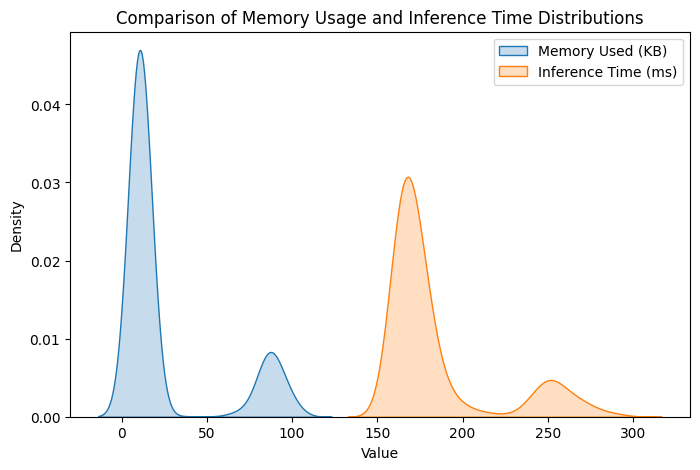

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.kdeplot(df['Memory_Used_KB'], label='Memory Used (KB)', shade=True)
sns.kdeplot(df['Inference_Time_ms'], label='Inference Time (ms)', shade=True)
plt.title('Comparison of Memory Usage and Inference Time Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


# Step 12
# Defining A Function To Randomly Fetch An Image From The Dataset And Process It

In [ ]:
def predict_image(image_path, model, processor, device):
    """
    Loads an image from image_path, applies preprocessing, and returns the predicted label (as an int)
    and the original (preprocessed) PIL image.
    """
    # Open image and ensure it is RGB
    image = Image.open(image_path).convert("RGB")

    # Apply basic torchvision transforms (same as in our dataset)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()  # Produces float tensor in range [0,1]
    ])

    image_tensor = transform(image)

    # Convert tensor to a NumPy array in the range [0, 255] and then to a PIL image.
    np_image = (image_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    pil_image = Image.fromarray(np_image).convert("RGB")

    # Use the Hugging Face processor to get the proper input for the model.
    processed = processor(images=pil_image, return_tensors="pt")
    input_tensor = processed['pixel_values'][0].unsqueeze(0)  # Add a batch dimension

    # Move the input tensor to the device and get predictions.
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor.to(device)).logits
        prediction = torch.argmax(logits, dim=1).item()

    return prediction, pil_image

In [ ]:
random_image_path = random.choice(test_image_paths)
print("Randomly selected image:", random_image_path)
predicted_label, display_image = predict_image(random_image_path, model, processor, device)

print("Predicted Label:", predicted_label)

Randomly selected image: /content/test_set/test_set/cats/cat.4111.jpg
Predicted Label: 0


# Step 13
# Defining A Function To Block The Image With A Warning If It Is A Cat Image

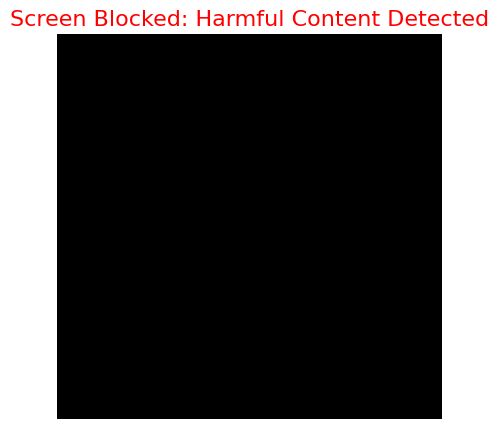

In [ ]:
def display_image_with_warning(image, predicted_label):
    plt.figure(figsize=(5,5))
    plt.axis("off")  # Hide axes

    # Use the fetched image instead of reloading
    image = np.array(image, dtype=np.uint8)  # Convert to NumPy array if needed

    if predicted_label == 0:
        # Create a blank screen with the same shape as the image
        blank_image = np.zeros_like(image)  # Matches original image size
        plt.imshow(blank_image)
        plt.title("Screen Blocked: Harmful Content Detected", color='red', fontsize=16)
    else:
        # Show the fetched image
        plt.imshow(image)
        plt.title("Safe Content", fontsize=16)

    plt.show()

# Call the function using the already fetched image
display_image_with_warning(display_image, predicted_label)

Randomly selected image: /content/test_set/test_set/dogs/dog.4877.jpg
Predicted Label: 1


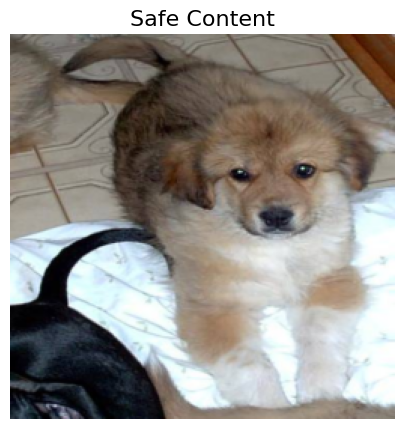

In [ ]:
random_image_path = random.choice(test_image_paths)
print("Randomly selected image:", random_image_path)
predicted_label, display_image = predict_image(random_image_path, model, processor, device)

print("Predicted Label:", predicted_label)
display_image_with_warning(display_image, predicted_label)

# The End !